In [32]:
import os, sys, subprocess, platform

def pip_install(pkgs):
    cmd = [sys.executable, "-m", "pip", "install", "-q"] + pkgs
    print("Installing:", " ".join(pkgs))
    subprocess.check_call(cmd)

def apt_install(pkgs):
    cmd = ["bash", "-lc", "apt-get -qq update && apt-get -qq install -y " + " ".join(pkgs)]
    subprocess.check_call(cmd)

print("Python:", sys.version)
print("Platform:", platform.platform())

apt_install(["ffmpeg"])

pip_install([
    "transformers>=4.41.0",
    "datasets>=2.19.0",
    "accelerate>=0.30.0",
    "evaluate>=0.4.2",
    "scikit-learn>=1.3.0",
    "faiss-cpu>=1.7.4",
    "librosa>=0.10.2",
    "soundfile>=0.12.1",
    "jiwer>=3.0.4",
    "openai-whisper>=20231117",
    "streamlit>=1.33.0",
    "pyngrok>=7.1.6",
    "opencv-python-headless>=4.8.0.76",
    "matplotlib>=3.7.0",
    "pandas>=2.0.0",
    "tqdm>=4.66.0"
])

print("Done. If you changed runtime type (CPU/GPU), just 'Runtime → Run all' again.")


Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Installing: transformers>=4.41.0 datasets>=2.19.0 accelerate>=0.30.0 evaluate>=0.4.2 scikit-learn>=1.3.0 faiss-cpu>=1.7.4 librosa>=0.10.2 soundfile>=0.12.1 jiwer>=3.0.4 openai-whisper>=20231117 streamlit>=1.33.0 pyngrok>=7.1.6 opencv-python-headless>=4.8.0.76 matplotlib>=3.7.0 pandas>=2.0.0 tqdm>=4.66.0
Done. If you changed runtime type (CPU/GPU), just 'Runtime → Run all' again.


In [33]:
import random, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset

PROJECT_DIR = Path("/content/mm_retail_bot")
DATA_DIR    = PROJECT_DIR / "data"
ART_DIR     = PROJECT_DIR / "artifacts"
UI_DIR      = PROJECT_DIR / "ui"

for d in [PROJECT_DIR, DATA_DIR, ART_DIR, UI_DIR]:
    d.mkdir(parents=True, exist_ok=True)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

def show_image_grid(images, titles=None, n=8, figsize=(12,3)):
    n = min(n, len(images))
    fig, axes = plt.subplots(1, n, figsize=figsize)
    for i in range(n):
        ax = axes[i] if n > 1 else axes
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
        if titles:
            ax.set_title(str(titles[i]))
    plt.tight_layout()
    plt.show()


Device: cuda


In [34]:
import base64, hashlib

SAMPLE_AUDIO_PATH = DATA_DIR / "sample_query.mp3"
SAMPLE_IMAGE_PATH = DATA_DIR / "sample_product.png"

_b64_mp3 = '''SUQzBAAAAAAAIlRTU0UAAAAOAAADTGF2ZjYxLjcuMTAwAAAAAAAAAAAAAAD/82TEABq7kegBQxABABBOHAwMDAwAAEIiIiAbufxEOc53oQgsDAznOc/2//85znPOd/OchG9CHOc5znO/0I3yEI1P//nOc5zn+c53znfV/9TnIQhCNyN/ITU55AM5//qfqc5znkAxZx/5gBngAGHh744AI/gGHh4CC0SC0WCoVCgUioQCHx4bYkFAuKMyDwb/82TEGCLTnrpfh2gD/UaJkwuP61MZquafHGfMhjlLTUl+JmSQ8DEvpmB46ipP+Po3FAYA0TNU01tb/wi4X8FfCrpHyTKa00zmmpT//uggpBRcJQyPG7GZ/ZF3W6v//y+PBSA9DVymVDwUnMzf+urp////oGRqbx6RHALv/8+6vuq673/6OrEE7MqpeQgcDwH/82TEDyADrrpXxUABXV6SOL1dmW490ofFda27mnRe1VdZF1LfMLFT1yfVFJTPHf/40G8MagKz3iDehlO98f1yLydRA50WFPRua8tq+e9Pj5mK+FiTE0ub5r//S/T/x0d057i8zB6li544aMLl3kzib4ZH7/m/kd8gfmgn5eaJlGaolzxGhA0WRom576eXZdf/82TEEiDbgrsKSI1dE4cE4gVZiyyozWYhnSXVjB/9detbQiTzA6hOSrIqLWguCMjA2IZvwZgRwFRcUFEx2c6zsh0PgzKEao3o7/01rtO1XIV4TihnCHcAjj0Cj1fDgi/cDUogUIBpCn5IoIPtOdx3ne/M//0tqci7/tRs2z+1vNqJm8xq0hAdlhuDKIqaSRL/82TEER97LtMcSId0i3YncS7a0HNrnnpHxYYCBFNDjQFkCMCKclFapstRRyYnkpIb9upJIlBAkgEJEjo4Gj8pUA85UOZa/qqdXudCqf+T6/fdO7eSQECIWtcwbE8ocdw4qnXJ//81aloCDSG1MZJn67ZA2ERC6G1sIruqrZmVWMARZ0RWU+Jq3YQlKlk0RGr/82TEFiADWs8aYU0cMLMMx9bnnH7ZDH2ykoszGUYqdRAZT0ZTN+7HIw1gRyIs+Sc6NQrpUQMRmZ+7nb6ltTV/X/ua873z7keUNyP7OnFR7UdKSCC1IJ+CclnGhKvwGVnKRYeH59E2/rnlF1zJAoMZKPYIGh/F6rmJy4iJaQAwMvhFFCufU9QsgGsGZDq0Obr/82TEGRyzPs8cYMSxLMLjqY8AbTpZgt8l0FoTCm5Bw7qRnr2KuaytUsCehptuVqGODcrSlmf2VkPdnNVv9ae/9qqW10fbLRytkYxWQ0w4MokgtspRo5GLkKV6jf8VHDdQWf4Lvhwqh8ebk9VWQJpnC51ZDF3zugwP0OCONAJM3POiPMsGMqnV0YMCz8yJEtX/82TEKRvhLsLu0wSsFcCZ8osYGEX+YGCGuKa+Zodq2dBDuQOfUhen20q7sID2mxYr2kllBOCpxXv0hoAiT//zAr+ew05buWfBr//skIBOKSICQdouNVSIwgn+vy+HjgKGv0mG/SpMwxfM5TPAWpDnUpmEL7lHdPqv5fsq7JWpxrLU1/1xGavSMC2blQpHWZn/82TEPBxarspcykUKKYlXGPKbtvzKd+5u7b23M5nJ2bT/q1Sqpi2V//0fuXo2j9U7SGBTzzC///+zkxccxaITIJGVAYNLAoSoF+q8cEMDTIncYGHHb1IEKNuemgHyq/34ZqXpVFn5nFCR+kRFpKBuVDbZ/3rv5enQa3GvULAhtRx2+pOj6kasTP/WmlumiKr/82TETRxT+rI2y8pc///uiezf/RZmp/n7Lo7//////1SgqgmMYaououIGYWExQxTjlUGTFnpZSA2raKAvkSPJYQkFxE3iOFuCWOE8DBGfH9zMc9+pPXLVhouW7NpfVj4lOWf78t6iX0O+n36ffBi7Xbo2w7LCknQJfK/6v1WjXf/+WuZ2UKmq3U3L+X5Smcb/82TEXhwb5r42eItTHI/R1//////+ylRXZ1Ow0gksymM3m5bbG5snrdbastPLoEXkFRw7f5QhBEkFbUApsiOUn0mBjuVLgMhxuFk6Fam62qbNXqBHcextBIHahQfp0Tp98qv0b269BF5xhmy+5az6kZu3//+tRFztxv/////p//91r/t7tqZlQOZ5WjK41Uz/82TEcBuLxtZew8qvJC3EQoAPzqU4pCTdKaJzlxBwlvqTnFayYiLS2IkoLQO8yVQwzUHgJL7BNPDiIPeUBk78f8KTFsHIkfxtf/ReDtUvp/y6lGdHb7ZGGek8K7Lb///QMOVz/0G///1veSLAy596cFwgp5MBAVwcBosqCCJduVXBPLlbYUInXGl+428heRf/82TEhBvKnqmeygTyM5nY+oCzXf3GYxi9DdItZFCUSSGXb+1v7DWWkuZQO5WO9TO9RKvVvka6EIpepurH/0bKCcWn/Q5jWYoWDSSTP1oCglLf//9lDEkQVDQqUBphLFFuUeKuJHhYGgZqIhm7+WVzNzVeitMxJ7FlkF3XS0beyQoT4+Zgwa4V1tXiKTfalbn/82TElxwR9p2e0kTo7L5NVF1ZUE0fOhjHCQixTiCpEBydlKQn/R//2Y3TkZ7oOPqd5CFdqv/25LqxU///////JWQjIQhf//uTJxBiXFGUYQ2TpmKXtvbbdd7KbDzcG2GAIQYBhMmob/nI0R3wNhWMFX4Byw4gq4/VfhsgAIFuaIgAM6AAgxQhEWcQLfQHIiP/82TEqRrzysI+wwpy+6L6Jfrz09D4hfN32EUOyUXFNPhhxcCx9GHM7T//rv7uLs3f3DvD//ifreXYguExP/8MNB8CgdYMERGuICJa2233+/tv67pnkPT+o8vaOzrTWYo1AEQGKMDQmP/LbujERm1HcfqZmtt9h9l9dPKKNtHnSoXyKTJkBqoJqg3ytjH+SJX/82TEwB4ydt5eC8Yeuswj8Y08r1GqmFxeh/uadVhdgEQY7acCOLwsraPJWpn7yGq2aL7QZstlNPtuDAoWRDmQuZPHZ4P2ZZaixIKRELshQOCptIRkDCjMv2P7ni1Qcxv/xbeq6X/WfSDP//Wf//+o551v/8f41OP8jPa4eQwZaQ1ScJPPkjnlSiDJqG9SYiH/82TEyjQznub+w9L/XUDxRrgQJgAJWlyZQAd1TuKEpiYBXlJUCCVx1bMyqBWOM1IUI0+9xFCS1rlf/+Iuv2+M++K1/8a3xR9b9rZa6YGGuJK5+W5wtvUlcVO8m7jpQHGC0gBlaJv+g1ylEBxyjxA4MJO4cCQ44coo14k6CiL15pzy///MVv//1//o+IsZlDr/82TEfCS7mp5O08q9UPIJB8xhcjGEUEzlFUFlUSMG+8K39S8IRiSUgAQAc+rFzwTXHitKpeHeZ3GcSquf8edSRW2aqVPJv8BBXqnmw3HapkgeD/0pfoHvpBdrCQ+z8GEfLamCeQvQ7wwIanzX8X+3//e73pHo0yohjzx3tsogIiuN9S83XnuY3//qwf//+Uz/82TEbCKzfpnW0sr8b/+rkF9A+OMLAIIlFzDmExVCj4sIHi40/amyKvoUXQiof9gEoC/tRsZ9qNtJpeuAeFyxehLmzjGPrUIAG6e1HsxJXDvnDMZ1AmnMZ6m1RERjEI3UIFeGChRE5XX///0UpoVEd4KZw4uXlQ1GJ7qokJUkn/pkDDmJ//0yfJ/veR1YMeb/82TEZB1jlqm2y0SMmdb5gh3nVwRTSA9SJQRRtEqVQNkVYZY25KlPmFBLTXydwTh/M45m2N4SVtpSHWGoinX1IFEM8g2rRLrxt828PA695uSJrus7z0HGz3///oZ3POUSSbGunovqehj6WeQMNGg4cIhH6MVB2TJisH43MAYIhjf2/PWefOb5idParMtkV23/82TEcR9rvt5+eg7XG9dfdqnEHjlU1mTv2gIjLXAgM7azrB+qyWCaPqwuOP6xfvcuLVzvMjyBjKnAy73sS4TKYMQExSxNxKtMf+jqYkgQnbr917I3RdFVoN0AGpw50MHoAHDqOePpTfimjr03lt+/lhObDwaksjBwOhVTHlXiwdslyu4xxXLZywSwJkMKz6P/82TEdibLtrGseJkd316i3e0gfDszt1xpP2W/M8k6ZlvrrHKNQ7OTSDJb8Rb658Olx9UxeGdph1sVUg/F2TzYAT4LKzgvGHTgZq2mU4w3F7tjg3nRttpchjDKzstlqe9//siCSG/V8n/Xqx0epk67EqEM6tFsGZoowuG/6uiPLNFjwnosaGFBkXWGis3zxsD/82TEXSDTttMcSJEceA6POGCCWBIJxjB3fqw6y27lHqElv+Yv9Uih0ynFQVVFyPxYXWSVhFdmvv2sskZp4C5MqKJpihsUARo4oSqyufE5cgLsY2+86cpsEWTxlWrl+wrwaiaWjB5tNyA8jII6+/r/dECTCBP/sdxJFz/8Twq60xwz5fijKLmUBYaHUvDjrkD/82TEXBzpyvr8SxFCx0MnkuCXSUOiy1O3M2X3Ih5wq8oMcbAK+tu2ussjgEQQ9DpTliBaiTCpVhhzuoLRc1CrVVKH1iaCX0e9eJamJIOudmkYcTC2q1X/seKDU+XybeejM1nc7/+RHoxExFr+f9iQjKoROdc7T5PM0M958KtO1E/4g5g6vhibZ/QuOSUcXsr/82TEaxqjGvZcQIeOaHd2+1ttrD1aMLEikodMaQDymJMiFaBFSJ8mqAAHg2I0jLstRQ4oKFlYKZEobXlJTY4b7eWiow5aPSidxm21Lo51UPOf//7I+v6uUS09w5iqqIlhTOXmR5ZjqoVqIMZix7+m/xz9Cv2C/Krer/iNvLe6tFRVeYZn1v2tiDSYlE4GA0H/82TEgx0K3vL6SMT3lsMQXYGPiWjQzECbzTuaZmtsFE9Z7+Lbm0WYOKtGbflJeWrB2NMlmuceRCs17s7df3ffWz2P/6dqK3lqbhQbUkdCECiByC+gL6t//nHyrXs0Nzdl/zO1+DbtLa5bjthPDhrtt2ft0jstumtjgqMiEVlgMHWk3I5BgKFW4ZRhae6Zjxn/82TEkRzyiu76SYR/N+DZJonnjmjvtxQkHQGkUDGzd3/P9j53t7uIRsUSDwYZX9rqxWRGl1UgkxiqQPHL+0qKhtkfob/+hWqX/8v9S6G7f9TCLAUs8NQVSpR5R66bCtGVaoOqV4eYiWU7CU6BeXZYIjJxxRgBIYRXcYmWbgaWkMKKMLlPyVCOpb4GiHQsJBL/82TEoBzbJu5cSYq+m7WQIUni4UKTLYZlK6Vcmq1gvFCwNiBqJAYfB5QvKk1L+KepLtWGXthaGDwojun4kA5Ajbzk+uxBbkpFB7ln//////7UOrVVSJlkgHAv67uNx4RPkTrw2i81bcGCVXfhLKxVC03KizPFMyblgVNWy6MiaeFRt3KXMXcxnoYPHRWo7NX/82TErxzI9sse1lKMLIYpa/UuhnzPl/1ahRU7GNzP+z8rFox0M/+/AUeV4t/g0yLsJHU93VgR9SE66jx5k8FG0CINVu5Vie9XU7DdeHaspTRZrDNEbmDzbrzlisNF3NSDvHcSUnrjfQzqHHoJiiyijmczZh0sW4MK3Hj5SopalK3oZ8grqGrHn/33I2nN//H/82TEvhwCQr5WwwrI4+4mxjGbQlS///K3/Nl/R/+RKHIYYUY7vvb/5Te1VIhnIMefigGQ6tiM4T/O8zsByla380QDm6xaddtmk5bpL1j8GlTOrFA2eWSyNs1lmbgZ8IbhDlwGJTQpWGJw4tfDiHMgi2cNSer89XS3OL6BMznPfTnNh9x1TeU+e/zmKcTEBU//82TE0Ryb7qz2wwpzdtH///////9e6tOuQcdARNavXKNiBDDa6gRRwYsqgGaERCdQaEokWvAACIjAOBk5nnMgDC86XKDRc4ISIY2loZIBxi5DRhgojGikoqWwjT+xEyGy8qCutQsvyDSNkTqvqlT5q69CW0oh/qF0DaacjoMiIIpwTh4JBwdJi83AuCBmhBj/82TE4R2TWqGe0MsMXKrF5KHSTT7/szo2enjVqf2rtpNQ4bjhUcBeNiZNM99G/+3/+jzf/1Y9WHirmkBHExg+JBMVOJBxAuUbp6XxwwwgIgiDorGSo40Hhg4WTQMALsAAmA3hTiAwc4e0yRtkMAVTDlbimHCXM9pVrd1NEgiel9xNx95fqupzc72Cc/+SS7//82TE7S4r9ojU2s8Y6CRd+7SbQnFY6YM1qRktSM56L/+dyFrkAijEJTTUYfETDMRI1JCMfE1DcxtDzW//b/iBBWNB4FcRR8jMeQFWmf///87///+nYy2uI1TL4/65RWVICkTZRDBAI0kNEDlqAThjqOktRykv9ddMNKZpSEAQSTFO9S9pbeAyNGJ6og1Wno3/82TEtyQz3pme0oddPq68IpsUOpw+/GHfI7WAhrRL1K1RvGO6gM/6HEf1LMEBarh56AVXihs3TiBOj///qAwkUg1kqyIMNo+TsRv/////roJOzGFmZh0yDdY81DXMNMSUZco1ikMxij0KHeBCFm/JgaFB58uOSDgOZgGQY01G40kPXFu+zrtHRJ1q9pKhKAP/82TEqSBz8pj8ygsKHJ+ba+79uv0CNaiJXj78uuzp+J8Y1ZZy8nUPxQxP/3vhPFz7xQofjWvzqIEoWj6Xnv0S5it///WxERldyvoUxNLK5bn/////pojkHBHhnc7EUsz0MhoopFIUijiSigjscQIA0BklAxG2zATB92OCpsNBQ/i2AxwtorZ42Y4MlfPVRkD/82TEqiMj6ohc2gUZqX0V0lArrv1WVLhv3Y4AgDNKGuxONO5HILkcr0gQeloZMbN70ke/arwYn4IGOdDbCTpMCAlE5QKTREDHZJ2/Jdv3BjCAEDhYf1d7eJimNF9CaBz+uaMDhyEDk71fZ5FilyHFpT/////bTVW3oVHbXuevRtF70F5PNbYVAyLMO2AnHVX/82TEoCXT0pmc0ksxoCBsBCUthpYe0yR8FMTJGf6RQGImVJ266MpEFazSUhc5uJKumrVIXoDinfc4tACh41i5dfW4AovgtW+UfMUkstbxjVuVvRE+Zu2tezHliNWorjYGx2GBqMmEUzOIUHQ+eE+KjQOK3AYKqouDa+ijv/gTVuNjIDg+sgbf/7m4ICDsnX3/82TEiyxL8qG8ygWodXWqSuVqGq5P6n///9UdpSGuzbqdDtudyFOQIEKrAIShRA4SCGOqQwIDwGwypaYYDG6JDTJkm4QwZtVEg7WQb4SibrAB8JbMgbTLW7UbeuvatSGM5Pbjh0uXgF/r+jZ9WKByw1iLo9WPBcCXu8H6fbxBIXxIPamT8zcfiBXRQHSoKrT/82TEXCKKvqGUy8q438YjUFswfMRh5n/fQQM6t31bt07VMYpGEpfs//kpxyHDIHKCECg3B0OiooYLC9VEwB0AAUp3K/vNQwj7LLa2AGFPuo5Yte1zY93lmANUbTEyIIZkPwnevJulWFkhxmQQq98MHpCmlEhckOg7IJP9kDy1DtFKrf9HxJ1KUSajs7eboh7/82TEVB/r7rJew8qVxzyB5zTf/WY78rfy8vM5dIdRVb/////32vumtKK7GQPi5XI5zB0RJs4+J4ICEmAKCnyv5XKgF49qwEVtehyk0UULffdST2mXHURd4I1Ccp+dNbZGxOBfNkDkXQgfEGd1GLkbtT1DodOhP/+qO4gNJQV/jDlKEDav/++WWz////qHzuH/82TEVxzT4rGewkqzwwqHwEDiMclpCnzvJOc/////9WyrlQ/U0gmWieoqAISb28+QGQD+j4gr1ZpVTbeH1i1JlLuzMfbseRipjwEMrAiKER1Se//y7kHMIosMIqfb6v2J2/6Izf//+zneQnkyEIRqEkIQggHAAFCB87gACAODoOFBNw4y1gIBCAICMH5es/j/82TEZhurDrReeMq8ocKbEeS5DIC9sYZpoTHoEoNnzjbpQv/LtkuuGOuOJhL7bUHXTF47iulEr2EK48DQg6oeEfDpRS1dvSPImyQVyhMZsnChUcKe8w4uGaRT4jnDMQOIFlALlXqn70rhIHSV7b1lyJf0sGEKw8+qZXtz9e9VCUU2BYpodnUXzLESRgwo3BT/82TEejKL9qDMW9kkjOFHlxTV3fgLrw6CRd0605TCBWstCBvuDgidMz91CL4N6Whs3yRES1J0Uywdkt6S3javyQePsk8zPzNaveSPsPLTtFSx3it84W16m/cwY9Yqzk1taAoHmIx+wVWqC1JrXKUSEapCk6E8jK0sqsTVCmoXuZ7jGc7+a5BmljE92bHvEqP/82TEMifT8r5MGFLMdzYZtGHyQNy9RSV3/t2vBZ1Wm3CCs5MyVfGZtNtWcfNd84QhV59zaqfrPCtycH2jmoowjXguju0svbmntQVjJGwonIoxcQwybxvLmyQMW2odnN+lsI0ayK+2jScYYjIBGG8RlmaQtx1E2owaU2rM/tq9mX0RMjxiynNy2BVpCqfhCWX/82TEFRzbPt8cSYS80dIkaCmxb+3ymeYbX9VsnSi1OXlZn358x7wzafL2exYQQQxVf8zjBAcKYXw6mw7ZiV6lejldTDJRaaF216a3PWunYzt5M9pavrpnrBEEWfWODj3VCdjmd4EaaLrQkjWb+7y7yXrAABaNqMHhSBKSmq5y0Ta3rw3L8cD7hCoL11JDgXL/82TEJByzJtccCwYYGSY6fxkUsffaibyZQkdOEntaZ+6JkoVVrIfkDpzPKk3wvmZ/rUkTnL+XPy//023kLMllqmNmC22ZSwlnPqodPYHtInw4o868hqtsLxwlvYmau5inbQYDt2hIOhnBYcVA+iQBMfWnIPcblgEbTIOJCFVK2xkF7UdRVn9YvPiofPElhlH/82TENBzzHssUYMTdPuMSlya/ySRmZVpmFIXpsu6Zq/OvMVkf5a/+j5m324myGM+co8yCW6mBHMPNwhmy62fqX4pu3/viz8ssWNteKVlDRL7mE2h7oHdESgYHUh3E+IyCmSk40OSLBaD2dsmTGMQBAULJ2HPrZu9fR8wp+lBZlT/R2MWf092N3Fi8B2J9mDX/82TEQxthSrb02YaQU9aqSriKws428RR5INVnZE6e2/51R4l1uJBqIslj4lAzxnU/PLd9gKyJVYUAUpEBD5b5HJUOChKFTRkKxxCMgSAlZF62dB8iakCm+Sa3s8TVR1qCutLrUetdEqUJEbPi9DGlfuazaqdFntiiC4a9H/29uuisbc1TpJ9DJVCM////2t//82TEWBzzOqpW0kqc15df//+s9iyqctvMNKCdftDBQuQUnMExdoYPoYAlEABBhK3uuVUCbuYjRUzXvp7ZIhZ/kGM3UQQweoLgN5iVVOoX8okI42LiN8TpHiGN0NoZ5cxrmMvEmNRm//6tI5jESJCyKIm5CtSpTN//+f////p0RV/6dP67Iky7p9YypXESK6P/82TEZxxb4qG2ysqVP0cwrmFUMLAsIqoGIgxkAgv+oQlibf+irHBQyINBUUJivPj7zd4zBXtnPNb2PRh95YEmksQ2F2BrKSP9Aa14/9/2/XI2/vRA2KUed+vn5GnPRhRSxM1W/B6hW//n+///8/eiMmvb//7a3U5Csahbv0U7kRtior8hDWxeOVqAANRgSBD/82TEeBxj2pkc0gT1tNaBoEhAUlKcIrwWSk8N4PIHAvFrK7ReFVyyRokzJlArZZN7mZ/MiT1vUotuox7P+zyr74NhLgZh/q3NnLruDRjr266M7HGf//+///7pk2OmhJPto3/+/23S+iozGIcy5XR9E0NNKNxgHKRq0GBH5IBUSHj+pTkBxR1qbKlquYHUQLj/82TEiRzD5qJcoI18xWdR4K2se+6vp8sBwFgJtBQlQRC+O2igvYIDseIIgQZxJtO75mjbkKkBioGf8r522fO+DN+r6JMEH//76///W25p0dchfyMySN//t7v7Ku1qIc6rSdDYxHMY6AIwo4Ugl2SteFmZt9pCoIrDu2Ikt/T0rVVWWORyN5WD4aZQejctNRb/82TEmR1D5qJcycTYjxne/wVM5pFioh/sXlka9G/tmOaDFNOirfKmr7Z1I8FY5jvqzPU/UDNHy8Py4EOE/rB8QLZZYMDDmHw+QUA8afvrU7c5ZwhEhwmEWhG+Qs1ute6iuzv1QjRjXZjRjR4pgj01zCz6PYvktEppq1ZGRKtnGozGMYEZ1IpxhVNGce3/olj/82TEpxxyDrJcwgS0XYjP/+pqzogfdHVg4IIpEhETh6ITK5wVtXqOLOhCCemQp6Olc2kEIIhC+ZyHMhXD0GStm4Nw6EgPgXA4FyX9cHeiidmGaxYlgOg7xHFKciogw2NnjLhQKsn52GChSpLmQSApzMgvi4PpjIZ4+GCuqU7O+rRX11eSHpjfRYeJo1Id9wP/82TEuDScBsJeeV78F6Sq9TwFQi0KZ6k8Rh/uZ+KV9E1AUDY8eRNVQz8uumkQaLGZApld1wBNPs7ak9JE99WrWHjE88HXexcyS1resTOd6Vz2C9oQCYrBXRVdEd73XXdkoBDG/5kdu250qwOSqICIi/WLftVLaNs9Ry2hyyWIF5ie1oPcN9nWRPLS4dk8AmX/82TEaC1r+rpceJlRYCHvHIzJqo7H4f5CcoC0ooHatPeHh3q9zonxoxIWJlIjFy9in8y4js+fqGJmF6CYvmefbz/lqD5+KX3Y1SE4antrNYSeJRFabPUbaKRSLt9tttsRP/6JTJ8clKx4EgqLu/BzNnIQqRRtHizKV7f5u1psz1313uYXmQZFjmLYvxzmpnr/82TENR+C+tpawwqfmfuZTLOqhG4kQgcD//6/W06CBFeJiQcEULMdvSt+UitN+n2moRZtUMyPQIkVxT7rSYusa73v+0Uq7WIF/8mieDCvXvM2dfL1qaG7btZswADWlkegDh7EvEEWvSck3rPNHJOxqv+14cucbmxSX9GhNPIIUxr7KvVY4d57HqR7Mx//8/7/82TEOhvRxrZcYYaUqRqAmsAhRrVwowYUGrQaWAolWMDuJVhMNQ6WCR6VCbsFWg0OPLBU7X/u+VO1XU9c8oKgI8SqDleiAkgMvs189CDHkEwwWDAEMDXBj8Ye6Ky3+Ut6l5yt/Mt6Rvz5aA/g1JqFDM1WH1fjFGFf/xUZo21Zs6X5TI8KGcy1UKJ/zCrETmL/82TETRyZxlj1WxgAegKhIRLEWIiQa0go+0FRhKom8GighERMRuKfrOhqdYdqJLWc/RW2ba6jbe33fbXajQWCRKQZKp0FhKrJLuDlAsrLsLAZ+7EgaeyX/j8a4YLEkhc8U+DcUpC46iJSdj3/f5f4zeLmXu8JOukO/9PxM1uUTdpiHMjmJ4TpP0/pr9nbJo7/82TEXTS0IsZfmHgDnFQaCmcuukKN2/vr//6WOyVjqiHuVWuOlyrDlpHr/////+3s7+Hh6r7KufnXqFS24MByfXkx////////bUzykjyaJnTJLHq/ZoNsNr6HFg1q2vW5t1///////////e9939L4p8fFNU//7E9kfYjXs+lt643BmYAwIgiITC4ogoBjBBb/82TEDR/KXsJdj0AAsrCfq4HRHc2JmNIehgiR2U3ECZOHqC4KRcR+T3E4qIDA0FAoXvIu8tNHD7Tk+8+6KtrOmqqor/SjIiotV+Bn9aS6SnXyYsc/8//v/dXW/H8jHauP/ydRiGNZc2dWDJxQaNP/z5mUAGjUWVItMLF/6FElKgDARfkRUlCrSEQIUuuCBgn/82TEEB+T8sI/z2gAIkpEl3JunWVMjQExk2wo6NDNN5ZEkxgrDjBxDjIw5xLyYVEqPNEzKa1Jpm6Lu773dS1tZ/1umgswc+hQsnfVrZJa1WOukaK//21t9u9V1JNd2QSTZVd6313X1Kdet//////////9Sa0FLTN9MuLqCiBLdJ/gB8BFQ1eGOBxd3Hehx1r/82TEFB6byri+ekrRFwwYqvNAxArozYbPeqFU0zZLksAY1pOJB9HTrnFRqLbOM3F2c6oqq176ucfOJjA4YzrZHzH6PQ9VAYSGu9rz6af/VzvU8itndSmoIEffmNeWpbyM5f/////3R7nft/p7Mw6TKbSitUNUrcA5BYh9DtLYT8nAwjSHmICT0uxUnCaLAS7/82TEHB0L1qwmeYTZV051s5pKXRtF0WmvSJ4SbBxxMw0llZn7s/lqa2lLLRbc85rPT0VEW5ZdnLwoyuZ26hECov7t0dczy/8s0xkf/0cxkMZ//////+V2pZ2/XSpWMpWQBY3Li6ooAOe1iKJ0IcYI9yWMpcS2liFyD9EZT4mLc2n8klW6jQUoY1DGGctf1Ez/82TEKh0BjnxWeMTUCjNAEMLGFBU2Q2YMBXWykxWKiK381kVjL9rBhVziyzJksDpU6p/93IpxhqKpF0FRIBRZDliqkIIQ1exTMZFy8weFj68WYzY5IukBvlxyNAdA6hvjhBosQcRtuKus9mGCyc7dfU3DPKtwTMg5aDEoRoi7vsbR6ubH5cnl3vOleS5bkX7/82TEORgqOlBSeEaQfX+//55pt2f7SjMXXXD5JQeKqdQKULe9F4eSfqq5b2n3W63kNs64nQh0qRQTwALA5ZMgIxDMTyW0ddVkW9VZfP99DY3vKVe1S6fOUzIziMhOXm6fNYbk7dc71T08uts5v9SESHf9+/6J6+37TNzv2f/Obl6a9U/+4dz3FuRIILvgOqn/82TEWxq6/kzRURgAjAQS4iGCJhGUARgSh9lCVrbZBbrtr5M3m9Hq7GI5Ih7i3hio+mlWSwuwrv5kOApJdb5udZzo85j+Wp6aV4CYIQHQrV8XEKknS3hzo88RVx+XJDppGVOTXy/j0zR+xx9QldMyriHvT9/aBAeUY3+9KZPoYpUK2eDJ/Sk7BExAZIkPdtX/82TEczWEFtJfj3gD6xD/ooGZDGH2/1ilMx87xvFYlX88mI7x/e/ZX+1xqBAb6Of/v74pjWaX3fF961qBE7nD3E+om9R1REU6IetjNFiN8BPqVy////////////prX//986////VkfD+a/1jdZL46VPkBMBDkEVCMARGARxGw2YGFc8+Hbtc7D75f+f50/Lb/82TEIByr1sGtwRgB2d35dxgaq9ZW7RA8Qg7x4+Rw5JQhGXT7a//0/3+U/zppER/rnJDO1ahVz3kodrAAAI0GUQodhn+wQRJiC3OItc3dz3dP67///5TN0IiEYcPPAN277f6tumsJTIUfTj5WSP0hvGJxVnPab0eXOLaaytzEJoou7alvwzGNaO8/tN/+S2X/82TEMByztt8eMMU4eIn5fVaysPhAJCL0Qxcdw3kweEsP0Kz+pWM/9+burXeXz23kpkZqTUYiA/dpbgi2dAPUUinSyUS7k9q2rUKMsDSWIc3c+7vYaMIAE20PRZPztSmzxqEMj3JcsouWPrYI5dqxctjOBz1BOEypqSHHJvYMMzk0bLOtv7sr4PAi69jjKIX/82TEQBwzKtMcYMUMQp16N2sY7ontK352Qtv/kq3KhW8yymIoEcjK2d7BjKnwj5T6ios+RUuyj3h3lUJWZXaUmZinextKX9SCEqFwlqz2lYZUDohj+KgkQlxwsedW9Tmd95Anl7n+t5URnaNp3z/z21qmZYwFDUWW+3Od5c0JtUkXOreV37TP/abw4kBHiwX/82TEUhxhosccwwxUbz1gCfrAKtfj510rtsuyj6nkkw6dEMJSz14lJfCTkpUWeZmHdEgBgv+sFQQxG/KgkYOJGNgRpLeaxRmLGBhYgYuPCo2/CIQRCymitzOY7LK1MCKu9o8jFKdrlDuZUWz2yOrI2GVmKCENR+nc+l+d6FH4I1TkNIIcvcoEQIEHWf2/Wr//82TEYxyBsrcU28SM/21GGejqz9O4aSgE0AUpAGqhplqCA7HP/C6k5R405USdJK3vIWwqR9sIfLbMlnplM71GDvKKJI7CnwuqtWKT+ZqIUGcWCbQ3bZDZLITyMjS8is1b0fShmMdJ3LJP09P/92wV6opzkqYx5//qMgYUEyMbIlXNPRFreRSS9TxZby4QBYf/82TEdBw7DsJ+wwRwaoeMUVbb98vwAmre7QJIA5MH3WYvPewaXcRSBUcRYgirbB1dzdyLs0i4xHqOngy8UGrpP4wxXOCjXJc1TzFPv1t+VW7qUQVCt/+cxyjhHClLqUxVOf2///UpSpNKHlZ3zMeRuRqlGOyhwC84///uuALZWgAXd9qwHHHfzcTQ5MumbzP/82TEhh1jIscewgS8IIMilG8HFej85ZqyM0ZUAhVNQok1USxQ1L4bVSmaoVKGsa6qFAQEo0alD+Lqq+XD/8BEmoYCMJHvsg1BV2TyQiDWWPfDXIyNQdiK+WNCUMiVy79X8q87SGw0HSUFL0BGzAhCGHIAEmZYOny34jFBAs7isHBTCAXVYLjZu2budy1/////82TEkxr5orZew8ZMqpEyyKFI1I12QVVJdc6IZSPBsGAr4VHAjZmPqmGla1rSn8a2iTxisEnXVuGnZFkRD9ihZ5UyzLDjW++3KpZUpbkCLnkNvaSEaDkkEAoMThgyCMhQgmDA+FREYOBZo2TGaQkxMxqEASIyzzY5YwaRPZfKihZqnD2skqjDTJibNrsQD4f/82TEqhx5mlz9WhgAjD5ylKEKNsNIIEcZYqh1TEobdGih8yftlUtsl08ttYJrEcShCnaKccddG/CXvOrJSHtMn9pyhhikkmKZtpFlESRZU9I1UEXmWkUZJMLtq3BRViT0evby2jAUa1C0jq6VxBOz3Rq4TqqJQQiWLd6iXJTJ45BTwjCWuwzuf//k+vOofDv/82TEuzN8JjCpnEgA0W43GDv//y9IYVBDNUaFrdrbN0i0pBEZBEojEYzryTyw68eUNgbGw+7aQPAeVhVAOJDtzcrOSw3022HVOr490MKYmBJABxvwZIsd/CiLMJVK0Q9HQpWpnOC8BbrOTEhQuCjS5CM1r+xKu/Y1W8OgkRDBxvU4n1Dp9vFs2cPO81Pnc57/82TEcDSzurJdmHgCQ4FEc6qQg/2BB5xXWseuf/TUS/1e8f+Rwfts+nTOrH2vi2/82zXf+t+n98Uzf36lOtRpyr1neMDJK9V8a2fLmvt8Yte26/P//////////+2d4o1a+UFH8CEyA6B3Z1QKqqB5bCAuk6ncuV3SGkPdBLbpeSSILsZS6zot8wRc9mITsXr/82TEIB96trT32GgC9qxT5hKAnY5hgByAdx5mZsJmbHTI8boIIXQM0kDA0WhpHkGTVoMptbtWm26f6mV9BbpLdSCC3r/+ptaa3qNHTe7vdX///9SlrJ5qmF956b//+AjIYLqKhYDj0ROoBIAAokdzMppfBg21a2I1o+1bQRd1IfAKQdFdrOwIoOK3iE97WUn/82TEJSLD7p1ew8rR2wO3xYzxRJpoSeSiIYS4fIN8apeg03x5p9DE0+MdSORv41LXFnHejtl2YxnzkVO7U6LTUSco0Vaz//I7Eq1yleJOnmG9f//8nElGMDDynq9F1KUv/////bXrRxJI8SU6FqmguPUOgACzb2l1SLDGixLZSSIv1y2SFPzBYibQudFXI+L/82TEHSKT1pVey8TRrgXcQgLvUqEhHO9UhvsalE8Q0uIUZTEGbgihiLqhLy8tAu5PjKUR0I6M/t/5n8z+UBf5Sk/l+5cUY4dmQqP2elWjZl1R3GFCirZ6HbK3lfRvnb7mgWCdVNo/9Lf////7NqVVYw8oErIcSV9LYuqJFJkCPvf7qsjVIXhvQww2NRiYZzj/82TEFR8Lxso+wk7OPoy1/msKACxqeXvFLwmHhDtHK04hapn2jM2jRPXet4Drbf/9Rc0s/qXN9s67ZHIDhEKlTZxz+NhsWFwSmNf+rK6OejoqljR1SjfOf/Of86r7JPMbTn+e1v////9ZzJo7mHlXaC75lFWBD92u0sshlc2VrisdIdYzUqLR8MgarjJcmPr/82TEGx0T1rTfTCgDBV9irQPDyCRBo0aUwiHDBg0qhwRDkrf6HO9FK0z9/VkROVpSxpTCQ8zq/9DK7Flbo05UIIBIpFdkHIUb1f/k//lV2fQn0VLfN/////2SkaIoIjmUqsK/DlmVgUQgwgtkkkbjABKMBEAb3Jiod03GlpkqGBQqu01oDCpGGIjrdCBhaWH/82TEKSd6Yp2fmIgCgYMWB0xTFmh7w4SaAIweYAXgUY546RXBaSBDnitBkAuFDChLENiFhPZXNYavEKDLGLqoEmX9iwMyT3TI006a1e6R9ugyW6Jw70UqJ1F+um55+tVlJdfJ4olIjxZA7SeQQ5QWYkMLpVPs3////+v/6P406JwGEatpZqJlWt440gwzvW//82TEDh177qTfzygCV7x7uRnxBbX8asv1TUYRYag5mmUp0HiRCEOICIeHCZvh97FUWFxYUYvnQcL1Zf/+p7iYvXI43/5WTSVJkcSMWm5Socxv/qMxYOjw5lH55LHZqSf///////nFlEXnEAEB4EAoDiYkgqkFckDK45GvUwRYVDCvO9VrgpozEtDrYBy4lZn/82TEGxvr0pGeekqfCJ5ZpDX8Umq3+UULoKNKuqSBJfMrfbW87aByNXI/IPN0Ten9Tq4RMQWqml//9fUpSCxhJjHv0IgiPoKH/l+3Ymp2GiAeEtFb///////zfquLUUcTMiHKwFuEKJMwxVK6gvYEN7I+ckNRKoUVYTGhrqMxK6etYNfJBm/hK5DjmLcoUNX/82TELhqb8lACeYVEawNuAsAqC5hJ8qtyt+hjVmepZv+VHUxat8z/0WjzGRyiaPL1/Q2hjaf/sa3VqOr/+b///////+asxtQEtSIACILpSPzq6xlI/LjGpN2GvnVqxtVZsMYUTsKCn6xurS/MIV0JhvmhP/imBh/hX+H80LOK/8ponw//DnkLEKGEK+WThDv/82TERhUzQiT0GEWUUVkhmWd56WxKstEoaEoxTEFNRTMuMTAwVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVX/82TEdAAAA0gAAAAAVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVVU='''
_b64_png = '''AAAAIGZ0eXBhdmlmAAAAAGF2aWZtaWYxbWlhZk1BMUIAAA1HbWV0YQAAAAAAAAAoaGRscgAAAAAAAAAAcGljdAAAAAAAAAAAAAAAAGxpYmF2aWYAAAAADnBpdG0AAAAAAAEAAAAeaWxvYwAAAABEAAABAAEAAAABAAANbwAA/WoAAAAoaWluZgAAAAAAAQAAABppbmZlAgAAAAABAABhdjAxQ29sb3IAAAAMv2lwcnAAAAyfaXBjbwAAABRpc3BlAAAAAAAAByAAAATAAAAAEHBpeGkAAAAAAwgICAAAAAxhdjFDgQgMAAAADFRjb2xycHJvZgAADEhMaW5vAhAAAG1udHJSR0IgWFlaIAfOAAIACQAGADEAAGFjc3BNU0ZUAAAAAElFQyBzUkdCAAAAAAAAAAAAAAAAAAD21gABAAAAANMtSFAgIAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAEWNwcnQAAAFQAAAAM2Rlc2MAAAGEAAAAbHd0cHQAAAHwAAAAFGJrcHQAAAIEAAAAFHJYWVoAAAIYAAAAFGdYWVoAAAIsAAAAFGJYWVoAAAJAAAAAFGRtbmQAAAJUAAAAcGRtZGQAAALEAAAAiHZ1ZWQAAANMAAAAhnZpZXcAAAPUAAAAJGx1bWkAAAP4AAAAFG1lYXMAAAQMAAAAJHRlY2gAAAQwAAAADHJUUkMAAAQ8AAAIDGdUUkMAAAQ8AAAIDGJUUkMAAAQ8AAAIDHRleHQAAAAAQ29weXJpZ2h0IChjKSAxOTk4IEhld2xldHQtUGFja2FyZCBDb21wYW55AABkZXNjAAAAAAAAABJzUkdCIElFQzYxOTY2LTIuMQAAAAAAAAAAAAAAEnNSR0IgSUVDNjE5NjYtMi4xAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABYWVogAAAAAAAA81EAAQAAAAEWzFhZWiAAAAAAAAAAAAAAAAAAAAAAWFlaIAAAAAAAAG+iAAA49QAAA5BYWVogAAAAAAAAYpkAALeFAAAY2lhZWiAAAAAAAAAkoAAAD4QAALbPZGVzYwAAAAAAAAAWSUVDIGh0dHA6Ly93d3cuaWVjLmNoAAAAAAAAAAAAAAAWSUVDIGh0dHA6Ly93d3cuaWVjLmNoAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGRlc2MAAAAAAAAALklFQyA2MTk2Ni0yLjEgRGVmYXVsdCBSR0IgY29sb3VyIHNwYWNlIC0gc1JHQgAAAAAAAAAAAAAALklFQyA2MTk2Ni0yLjEgRGVmYXVsdCBSR0IgY29sb3VyIHNwYWNlIC0gc1JHQgAAAAAAAAAAAAAAAAAAAAAAAAAAAABkZXNjAAAAAAAAACxSZWZlcmVuY2UgVmlld2luZyBDb25kaXRpb24gaW4gSUVDNjE5NjYtMi4xAAAAAAAAAAAAAAAsUmVmZXJlbmNlIFZpZXdpbmcgQ29uZGl0aW9uIGluIElFQzYxOTY2LTIuMQAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAdmlldwAAAAAAE6T+ABRfLgAQzxQAA+3MAAQTCwADXJ4AAAABWFlaIAAAAAAATAlWAFAAAABXH+dtZWFzAAAAAAAAAAEAAAAAAAAAAAAAAAAAAAAAAAACjwAAAAJzaWcgAAAAAENSVCBjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADcAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8ApACpAK4AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//wAAABNjb2xybmNseAACAAIAAYAAAAAYaXBtYQAAAAAAAAABAAEFAQKDBAUAAP1ybWRhdBIACgoaKrj8v2yBAQDCMtj6A0RsAHHHHEgggei6PboyFf9kq4r0MycOY6Zp/spkLXG8ZFje4AsLcExuHXT7DPiH89BephjQHaNbFFLKltROFeJld0uUUMqlXuDzkEHH7GWxwZm/wg/cmmfzOxYjf8Nc95iDy2cpIq2UZ4WLS/LLVtJdHpkUK5rMLPMmApyqixhfBmr+/e4t5u7wifSWKFLMzTshcWylCjHEHmlpb/MjE+7TMmFgAiA8ZJkJQZ9qx0g/997szmpuASC8ghzHhA+EZ3mEsnD3DdC90eI2B1OfbbnnG8MVt1SgJY6uHZ/OpWRM7IFP0X64LnnWM62fA5Sixnp7I/yV5YEnp2yVw/Jah9qC/46N9g6PY96pg8xz0/ufEX3UZKhiXgqbAESiDL6+fdl2qiajLMBdExBtD1Gicv1AMeadIO+rS/EUCIIc08thabmChEDq9j2hApmTSnrBsMR8IffSn3EkhPkC6Kk+ZVNl2kECB8XG6OjpY/Aj9NVxoIPAHO90uuesgmYxCXPp8h9QM2gRMiy/dRlhDEov6UtYWWLvNViylw0gbpz0D8sbAzSzP+epiNktyw8ivGQH1OjSrPSQuo4QbbDwnKIW5rdsVte04BCxkzpq51GvFLiVAxmOlO17feh+z74POLWXon2aCXwCr+aqkhQ9E5crp6ALf8IPDCClLeR70XFcVpqHnYOW4q3NuXOUxIVF42cTYQw8UDc7yV4ZE6rSN/llKJwUtxDBFai+9Sjsdxn68gpstKnkebKxHmISpPaWx20equ6hfhSJoCziYhp41MAcvMinraBFo09eeqyMuLK3jdJe8clJ0/HWBOBBl18CtDawiH+pPCwbQ2hhuDPDvKZI4XkEE1D/FbP7jsTYLEq/5od1PtuVVFXX3P2cswn+PVogyl0pR95lnWIDqcbeI1AEkF9rR+uiA6mnLS/axEwfl2YYTe2oK5m1Zxsr6GyAokGzLZaOZNrrS5M874G0pxsePVc5HhbRcIy6yCF27Gj7pbU6+OEZRYwYcAJxxk22+oWdFEDDJiP2U+gUos+/fxncpZy6ofH01L0Wrc/YTMWWrq2IMAzb/6P2ot2H0kE7abM3WsV4N252rYpYdnTQfROWikRaH3pk5u3Z2YWT3DU7jlRpkWY49RJvnkVvHBXCyECWyjgEdwCqrZpfL6IOis7qF+i5hCxmwZrLWWDNDRXgmjeo4VYIGNb4ap00EnwjHGeCyPSWwWis79NkL3vBmCZdLi9clu8khEn0SgjqmJglW4jW+125f06CxyGr+5Rt297oTsKxoag0zX5lfyjshchwwEj3GGRpaJSCAFxkXyWbi4HhskzWJoL8ekc8Q1h/0EZv84rWuEisojMkTMuSMFy/7dgG61ggBrbXurG6M8vpMZihk07Y8IUYE+uF0JxDhyMdt5wrZKvR1ipPvQY1aNopzmuVM+aOOZjE7jArMCXJZZ+AM4NKJgSsqfBm3P86uZ720BY7KglbPn1Wl9S2Ab0yybgDQhyu8K3oABMMEUpx4SaDRh7gnfILQrsrEb4UsIUN+fWW5GtgdjxrrWKD0hnYxkTWmjBA6+6oj+5S+a5+k7wfm3wjMwApbOih6NoGXmA3p4MbNVAylkLvaY2BIr9B/AQ9aynelNbzXiDn+VGDwINzugfwaNe9bc+Zu2ZCYqHExRw0ZSovQNeesCj4dTFcL0YWBeyutDvZoIad21cMj3G7qrR20cw1CWikx21x5U52/6/3GPGrlIL9ptgIrcrzoeZE5KrbG1dyzc0eLLTu3i/+XMCPEumtohbBuXtsH5xOc/bpG15mWtujEOt/e5qCBgCM7JKYl3L1dl4KToSF7hZIwPbIR89uB2nFbOH+ujklwjuJh5bfBXWPshNdDWuOdozIWV1EZS7vES6CPJCBSpPPoaLVZ5GbsudrryKFSUTML/J0MHhOcO6KehbnL9jGW+yEqLI1v1viv5S6N6v0jyJa9AZnpjyDbFozVdibqylLc+FI+S1m6QdmVc+A8ZP+Vs/VJcNAV8RpSEybeJ1HfHRWUEl+ZLUvCjzbE2xTVZXlDMpV+ivbZPaMnYfzdvSP644cs9Ea0uE0uMUXuublZqus00JrrWYKOWNE+JWAqa52QEi8jOz/F9sPLXtp/CL+GNF3TDuoobViFB0XW+0qyg0UmJRk44MQatNMjPyFKHE2IVGLq7PNZlVfh98eS6GllhiI+SxlWA/WNCbisEBwF+caKjHoH53duR5tNeob/8FiSYMmveQGOvEE9fyXPnOzY5t+l7U5vIarWlqD9qCma3k5fkzPIgmCuTg225LDgxi+iSSH0/as68owiC2ZtQtiLojYjIXRCEVn8XhfthhmC3A9SAZ6fwAd1grPT4bnuDo6WAXLmLcmZm6y2NRxP+aqc2vF+PFmUFGre/DXPSkNo0Qn2C91w3ir20sVYbRUaEJ0erHJVEE6GOchjiReD3as6SNylDFdswgTYqe7iFM+7n9/berwwRhd1d0BNKZPKws/KvHf8AY/yRfdbTuURlp8x5XRnqf3ZBV5tyBrQVOxiA6sq+HvKKdjRDFXmzU0Z1t4d8g5Gi/CgMus4OqZQ8aR2lMaIXDbH1p+Tcr4Sjh3da2cVh3Or3GLSLkexpasV9oRSR5UK+vr/xW6X0PbJny0B8dE8X+YBYn79dXJ/3UJBVCaeTrG4aZ+uoAc/zLv0EZ0r7B8yjRT6kccisNXphwC2ufE7pNcw3NxtBfqj1wnRKvvxQrsXld7SvjlwO/WwZJ1ciw+MNZp8isHzMtchFkAL8Q/xen7o9c8bacrGdGL5Cm9KvF/CcIeF0UZOJlhwYsA6YnJqYtui7OW7u7ODyc+LKcUIuhse1iuFzyFB0OjaEI0g3quIhxHXVsN8W1z9pn8xhOLK5Z7wxljXgrCQmloObmPAflivcaSOboRI1r9kaCuMGehb8C4ArBKh/DEjznDUtBLGJRk7CbvTbNpzeiBcn7kJHHaoDb49pVBYf8ElvxEFMUvLaptESyUAFmaLHxUbdhgUKeBTnpQkjJ6Um8ohEGnnk3b7f+QgDxdqZDcO1zPPziSK9z8sl6S4INZQ/hBj53+n7OxLB/Ubad0FEvOsZeES/bvkFduajAORHWrM2fru61XZaC1XcxiiA2Oqr1DpCjBC8DaADESJmcloINTRP73avLeSgHssL+gfNl+zgFuDpRpAfOmN/bhunXOy7/hpnIHQwJee2V8kblvScfY3s6ZnrYtKQJLSVXMJqeTNkZpR3S22JDKJ8faJn4dwYh0tlQBLd/Smgf37jISI0+7z3/Is+F/obMH3+ub8CO5DDStahkOPjNtHhTmglpHqM9wi1GCJWf5nmxPlENeAfurylQXunnlIC0utfYpvpLD4pFe3dlJBo2TVnY6vWlezfVK9+QZUhXyOAjMsolfeUPtLMcl3dK/IhXlER1x77j3PJSzkvNcaxQw9naY3mVJ/npcOeLQl+2/3pL0Rf78BY3flSLtkLMrSDRoNwYrDs6XQyx4PU4IFD+kD/NFr7vqB0PMa87PjJhiK5WnjzTeHI5/6pP1EfxC/Tr9HlphmMJUtSYQada721Sj3VDbA5wef8R/lgMw/XDbVu67vvidRrB/NfcEUrJ40oPooL7djGDe3/x4MbdUhJxUgdYjjTIeElUeURYJQtISNASdO5e6GS0e7C70IB7425gRKhSaJON8tVvl4crP7MjWp+VAtTmvxmeEWaFxzT20cmQ31n7A/gpDQDYPpIwvLjgJ/ZjNQnQGMJOnPXgDSuvFDuDMH+txhMcVP7GQkUT04Y4JbUyV4agJ9hqe6QZB/b6CHTgT0lbmRgdV7VG6+2vnV+pQ9juiiNCy5wOuyAnt0dPUYnMuOWPNx3oJxvHXUwNa5TKo7+v+/4E5GKm0UGJ1h0ph1xz13WdwL6s6sIC2I2Dpc0M3jdMs/lAETY/fcbwTszwZ8NXVYTZGcCE7eR9s/9heOB8VdL+zKn8/QNNimRPJwm1srlaRiRKRKdG74V+2LnUlCiF8ojLZmrWURbDfV9+vvzIIAEi3Dk7O21W8lDjpLHqeQC9B+ACEh7esN9BseXPxXtO0NRSrzelM9N55naVkw/XY5+dVNP1hq6MGwI1NRf3IbF88KGqtagHcg/8jfNbGWqXwp5BhGDir+ry1W3LdDqgR6wvpCIFRwV51RkNX5wkL1tq9oxErrzxOkdxr4NVbQUT9oignX1JOVw9U4QfV0AIarcNHONgv9jMgGiL7nRZWEDUcSR0gNtBwcuLWMuAkXOVd9O07ivSROrbTHO0qELxGgc4E7SQSzKXQqAZzBvbKyT9thU8fEEKe6qT67LY0ZXeXG4HSujhuVwVeLNG+4bZ79+23TtdVq/b1ztTSxkSHYOI7P9nVsj/QBLQoXiLl0TkAgvYZhVPWdDt3AqDndT9oVJqH1lmj6VCoxLav5ghI5ageccJ9NP4RnzujGD/kCz5GHIVyY7Z82qMbaVoSUBo4DqjLvyGbPA3BpDBY6iybKkJeGxP0iHg3p1kN6bPtZSoWz0joWh7gIWcokymB9KBnlcviyd2xtxpKlg/CbiqVnXIpzTkkmmgpUJJCEziZyALGHQB3r9Sh9r/UWxCut2gUfxugxMMiwZMxDC47VHAiI07KCCwCd3GpO1ITntjZT7E2pIeIIeuC9ngXWUB66B7EejUPwLKsRARHH4zmOqLvqAPJ7YudtZt+7aa5ZKCctAsm+w3D4DPwAEB9rgSbKbX7hiMaQ/TQpJp0RpMrnHiPT4s25Ot+MQsUeZwkMvmxw24SgW2m41njXC8j0pFzNFJ3EWcgb/kJ490EiBzmTeYc1UFh8ms7qhrqFwbiO+cK+Fz1/RI0B2rvwHVHZj1Sgm4WvDEqQ6YXcs2nSjbGXrWgfKVXruCqMRC8U1G0ZPFHcuxVO5UPfifhxisY+SSle8bAaUElp7GU0/E8dc0UJJevE80OtmqB+nRMPrpyE2BlAgGEzuwQDKFeJMYtoTOY+75JYPweX/ThkPd9TgxRAnhsG6MAzFiPrBBUh0pKZd5gaB60bU9//lvw2DeY0m58Q9YhMTfSf+w9zC30IcHfZJh6MHOOn5qcL3ieAGe/L8CEoAJ9f9+pRUloeI+845XQrG+vbky7TnQaJHBoa8fP+YcbmGMS6rVaza5ByMA6kpB/WYJKgwrzvfsGysDbMILj5lV1+RHZdjzHwJY9ij2VV5Bo8fYxDR6gWA6CROpwak/jgSfPVqdAAcjFK7ef+/QRCA4GeRnuRY6GIh2n05lrp0Q77CZAtUdv8AbWRE3TCL1+lKsADnAOCLAiIc6eShyipk64m0JwAF1kvIa1klpAWtNAlDj6P+bHDBu2JLCwkJjVu+goDUx/ou5fUlwkDtuoV/qIT2odnIgYBkPwwfi5cN23I0okdVXkAEvROszYfp2viJzGMMKLUd3V0APcREUGwMIwUW2RfagskykjK9iHKg7l40hOH2jU1+CGmR6cZ7rcFlW4diJ7pSXL36O+RPOlzKzwGiKXRMhbUSlyuPB+W2FrsS7jV80vBB61zs9D0kBXno87e/ZbsUqjHkrF71KrLQvDeA6l/QEriysYnRfZuXzdV6pPxa0E55Nh1jw00D6+PMuNNKhPGvzTjm1ccNI8t424aXO9SbuGaWWZ7khfpXy85JHxBH5CFnEBQw58KoxrGzghNQ0xya4eZMpt6p2x+X4JJsV+2xDiUqoFTJY7LgDFyYgeDNfKES8jnkDw43GmjJ3OpOLdbRaWcPy8cjOWx+oivg1dCrM05PpWLayaQnlFCXV8YDqafEvNqY99z8ygK3Jm1xDYxpp8oUpPoDtSgK3a7f6ghlAQM3sM24hKg0aHr6zEefs8nmspuqx35nNnrVMQtr1Th5mKIHIFGR5REzWzDvF7TOeBFdKmvYVMTWmnUXM/hoqu1+nGwQLgISJqmzl9eb67ElIDSpuX8eImfHIcfmaO69oIX82xTd3OiejnIqwak7LLg28KTEYWhmSvQI4zJ7eMHc97ZWcwZofdU6dvhVB0C2ituU65j0G3g8EHQ62qktHhSYAPBb2NQ76qCisFg/70NIYx1qzdV+a8s2PhUzjCmbPha6p4A2eC1EIMXxGu2BY1JjcnDF1A2uCBQ5Oib/VyeNOh/fjIaqf/Ab9wDfliD/8O+N+txFxoHarCpuwsRJeMgoFRyGeMC3V7uh2GqTloPxA/4SuyelyCLBrhCAdCr+nOHtGgIDmVzbhklPLvt5thBC/smI8FPqbMp8DtR+Rw94GH3G6nEM1bHPjt2hC5UtHqwNvE6ov/afoG5NLFp46l88VAbLuQh9473hTeah3l8VnPprWMSTcETefrKtkgQM8KC+LiPT9R4goIKz4d+rn9bIXIYVQ6Fr52A90SNTQYwZix5Xsv2T1sDU4kKlLuaNAm29OP5HWIuTvD7I84OEwyCcmOeyvzO49WizK/60Ry2reZr4qRW9AjXPW1Sfxh2gdOHPD+qsGP4aWJvQ/3WV4QrmqBANgD5Yl6eYP9Ih0iJacW3t4g7zoPlNP8oAea7nufIAORbBdpbWjGHaPfq7a4jF6uhtlVO6ysWekMIBnneYF1OReTXvRlFEzcg/cb8KrqaELvFMGQwHkGaXYdD2JwOZMYJ3X8M3252ueR3DHqsuffrI5M7JTpPO4/tORo1FyPrfYwHyoGXqToYCM0zBheaYUijWJQmkLwnPsDbpJcJSQ+xUsyBF0UMTmfGeV9Ia2kmyfqafhBiIjttes7R+794YXPgdtu1+f7+rib3YlbXghz2NCyaqIersTzqFhg4aIu11XsXC0vsKGSH8632+/X/8iEQ9cM1Cnd2fSfztcqFOakhU+ZJ0xtq0iyRtdhhX7ULmOfVRnybYRXsTgPioRMZ3tq/EyRSPVpzNI+pEyJC1+QJZUHbXyS2JdD8EYVILc2LEGn0X6T7KBA+wX/Mxf1WdjYW7C8G3VHki57WtpXwqZ7UNMu/js63QESF/HEiau3bvoq5WWlo8p4SndYwfSB60z8SBg9FbkU9rF+SHIeRPoRhlwmzH3mNZcQcp7suKSGe0lyVy6B3xoBI1KZIGfxqxP0Tx8YJkqOuWHYyLLjkDyPyEfedbNeWw2VTN5tbkv4pYQ5Gw5y+oCbEjnatF1WpYgZcAHuDMKyYSclYFM/O321s+hB+dx90WJ3Lmq91n7EOq7u1+0opymwtlIZ72YdeLcOmAhuHaXbwmtT2r0cyyoRo2qfjRJsmurd0BEsjv+472p9iZzIWFWkN8Lue6AAWBohg7SnQI1KvVz5PjX2FTvCgn50qSwLzPIFMBRhw1FtIBE161wuFHVLzvkskWzst/qHvtjhukAQbNAEpQlJri0BCfWVnGz5e/IxyUbt7hiAq3SK30vqAlTkRPNA3L9yCXosNEM5mZOCieL95qV58nUzknrZIhm1QhNiPhkxFyvVJ/AVkYPU2k3Kxpp6a6PMRWeyIWS966QPbD6v2YsNehBXcDYpQ71o5lHFEA7vX/V7rYYrUO1YqScOGHSxDGOur6EGH5SgFvBbaRCH2Ji/d36MSrBQ52F3u8WoqZBGrq1GAIRQX2b3mQXuMOjlKa6FGL8pkwq+PawigJGBcO2smBrXo0OZK/4PTxdoi513fRV7Z94a/HzGZqXnXYF4o2kL7rVRq1sW72moQKLgsLxa7FKThDVXlXwj7EWgRbY9Cvs1oQJQrQCbGqHM36dIOQlBGUguWoX9uMQs64gcikYdIKHWGvDB00/aO0ky0BCjY43eFmcSbMrBZROP8LxqieWIhB6Dg5YceJdyoe5JwugPCPNucgGUUDyIWfPjNRoMRVa/QkOVxymlnz5uYCY1Y758d/WuZLcLI3dEjVQ5Hx0NjL1Khl5fWzn5iwTLaTyIdkdCnh+BQZFeefhwVHjag4GqcANP4jNAJJzgvqGAyCb3Ccqoa6ix5+McRClnaCYY9FTEX2tfvOQBsgG+yaj2O7scg1FBRI8j5lWK0g+McMAATF1dJHQf8Sfa0OMfD4Ubvq/0IoACeu6kiBqjXBo+EoDvaq+nsh2E8ByhdS0eri8a6KM7twaPHDHbNv4PTArH+/xU/RqOJZYbj6wOiVBNjbtp+m8SFTzkSfMddYjy/K35tzBGLMpcvQekiqiKwtOH83M+Wgc8pRB/I4y/q5qqHYAdeaegw1JaezF/Ep4WNnIBvrCxi98CUd9z6r4zJh5wG8p/nhF2frgGfY/waKiPfZNvsofUIBvwCLUv4dXnmUSxTOYhZ3vMHUPyTvqRuZxhVtm+RF12ZmkWLxnKSP8FOqUp/d/unWJlmVq3Nlk8SsXNYQ6+j3K0/aBAeuT+F9lBtORitrkz1B0O3tXHFziSYthcD0dODt8Dy3Wjzk397SHllEQ2WYXbvDqBtNA06Ioor3303Yg+dZyq3sW9Y943wvoYBgyCT/VdKz9rWAde/UQV7ult7flY8PffLsipC5m7QaFKSudL6xg/Hkp7iR9yRXKhGQV6UWehIfnCFminjet0z5E55/8ekmlq8OcgifQCuuc5l37nq/+/1nRRUuqfwfNcxV70PrAYTVyRk4uXTSx3dus+s6/gjsSqJv31YIfI35eJWMIkKxCDDDVZ40gNXz6NXS7it0m1R3yWNTj4UPmAi6NzOQis3DVwXpoik/OUwD9hR1nu8aU1WCKJ2uJpV2x6KTLPnyIUksmfEZXxASkXZ3OeuTEE+D4Rcr/WzJ74vsEc/JRhedVnD5M5LNSkZHCzdA5BVC0Bjdn6+RdhHRy5UL3K5RCBZN8IhIqSLnFDSsky0xdD4jfh5EiaZAr+LeAHni1lJWSqXrf7lUCaUEth7Yf02P4dfyU+Y2aFYwB6Kqeq4tg06eMjHFspFjrZ7kxf1j7GloDS2NnsCRyrFydD0puu0wmZ9MUXk+eELihnukqHCkSFsNCPZmLXcSWpxiq58+phmR57hliGiDokseCHCvDVbQeDn2HFE8w4S5jgRggVWTtTrJqMbuNZ1IX7SwWfJutgP38qYl5xK2c5rOZqfZXBHN6vONHKm4rlFo8Z4EcdzQV2uB/1XDyHsDTkjcQKJhc5Q0+krYvuRn/YvaMHOvotdLAwB3soW1ytR8pCKoheSw7e/oTnSloMDpykZ0h+FXzA9kDHnJsiP4mAOZEn4sSOYW/vROidnZmZ4+o76Ez+XnkMcTVofxpP3qDj8pTbXCQ4CCLT5EfCbvEvfPEehmjhbAIi5OyIdnIdRwav/DaoiltaDg5N1u29dXJTRUyMgvmoAMf1tfnKSzxWkK0Qc3lyQnJe/a4cwPB9mUP408yUh6FnXrcCvsjdcyuSwQ+3JZVpXjUyDi7ftiKKRzlgL46r4sLNyhclsvL5sC5vg3Nl7fax4GLjoJiIFtDiofGfYi/+Ia20ccbcOG6KYRoeR5Gsa0844EBFPqAQTC8nx6i4y+0B9l/h1rjj8bWk2pdlqPB5SZrRej2VFQDXD+WhRN5xZNbBYFmInTFLzcKmhrSrAiw8M7zilDyRK9fWjPhbICxMMdbzifKGNoMyj5y/D7QYSPmlO4nKo6oaszhyPcMDWnWsVVzXUOC1DtpK9ecKuGhrZdEfGJvQOmKJTcu8eunj5Sbf+SP5bmtJA4ScMDhTcoc3idsZzbE+9746DKV+N+N+I8hC6KAaDydulxzOVX4hl3iCidzX7wHu2LJAlt9QXGhX9/rVlOosUDG1Fm812rz/sKQCnPYtBDO5ZVS3XzoMJGlfYqqPGvEyPZLupTE7M/z/9srQYRblMqVhBnPXWDLyitw+M4q/uc2ov6eYG0hD68xB8ykM30ET0D2Rq8zZWNYZUQOUseIWxIE2YmSqWlSuSo9pVhZ3d1X+SKJVNMFW5HlDrVsbSY9gcmdwnB9fpoa25dAtyKLjAFrY/ltYtjJ6KqjngpREbJU/xI5Wusl6VJXw75ti2XJBLWRZZvTFWhNDqi++dehKWtKSARLtuFcL1q+uIyxy8dI/saF+EA4YPPcuMbBkusawWis/2wmxNEmw8w2PQwfNDAit4x6PkhCKTSHzQdLLap1Jnjp8ggNp3sUuCiyLLNDoihlpEtBNV6gI+3pPG+5kVhcvV7F/dRIuAQitNGkEd7zPZJoDUXq3t631FSbqtHmQxl3XgBnKDb4fKzq/WzIQ3OYFgc2z9nti+aZQBt/hHgcnq1Fld5uiUc6aBsV23o2ADHMPfqt5mqwW6fGdxtjXRM4yElBoF85+Aki3J7ksewqblft7K3w/fEtNct1hhL2ql2rQIiB5KOpq4IXZRa6+xRD9QMj7hNB3/5rkrNZ9Um25y0y+/WeOtKkKtUkkWyKtfFluVSUoDzCLgdzi9cCzZGy4WWBx8JxE74mu/K6ncAjvD2nC3nbEKNy3Jto35AudskOombYMvV7mc8qaroWCrHfllntRvHNFWnBQTprX6wur0q33upATiMIqhDy5uKkaJNoCjYmbUYj3RPd8+WFawMCg2dDU0vZ6IhwdsRxcPyI6JL47OtdUpQi3wJcptrUwPYfHqd2OuRBEwtUNXHZjZBhZ4JOiJa2uBYQ68akR6iinJnv6WP/NstzuX5l9Fg6CydhOm/F1/vDBAqMFYToeTo6U0Kk5CUY82FAZ0TKs4uEWlaRCbN8oMU+KJEwpxULFz+m/utrCYnq1ZbOKWrB+zth2r7n8x+au+fnN9sx6iz2JZelGOAVJcswxrcWZvBVUYEsbs/gna+wojRBLh2z0QAwGWmV0Rj56N8IcOjv9ACTfwESKK2L+kaUyh0bgon25X6feB6bF+8/xbEfAZUXTDUrrWUyywdGxqGjWGZJcfP9SuJGt92T4RsuugksBGfUQXtNY/RcoUfxVdQ4UxVrGuwTXxtey8JB3NCet69RWkkfZB9IVHbRMzySCny1pxceDVy58Q9MIn1ken84GREk6P+ewI+sfpNiiCNcwFgg4tTH9Q9bZ876sU9MN2uCR4lcDoQqytB0e8ZA/qvCVcHGPeYwtHg9hkUz16QGCdGLNSrWOr953oN0/SIQf8pj9N/hRW/MpREgEE+SqfhS9s0/J5JehOGnbBb0W09G6nZCKusB7Zch3qjiIt+3Nv7Vu/9aBeqdPSTQaISzpHuSivl6Hhb1CYEHLuYqqIARypWJHfl1cwNgBks6gT4+atjnFj/t3Ca1xI/C0maO4ETYn8h3ruEqaOg2K3JK0DI/0GBMiW04gnDb/H7FJRQuicWVwKbK+V1rJr/0gv6W6BckTqktqQ8SsQRBHkacmK/roQCOVfomlk7mcKv1ZwjtNE2vEfwiBLpAnQoRdizN7S1aOwg+fuWPhkJLjvTbFQXYCg9JL9aWBMMlNrdNqcOBPxfvAcXOluhANc09gj2JpO/ljJ4JE17wgI0Qmt6oVg1X2UYu4NhEoAM4Kuqmc8PmETjuXKKIVK+XckMJyyNrKmW8kISQR96uoJOziPcV7VBEww4QdhZ2BVqzuWNv+y0SWmcf7FH5I8EUjqqYGCwdrU5pehh+1KmqWCn9ze+2E/KEukJ3IJiTnjCMzoaunMFetQ5lCtvwR7rD4W5OCClkKf12hhFcpz4SEh4Qp+xTnD3MmM9EcKMZARpuhudv7P4BqJNtUwpKIgh4oISCIMgb2nXlh1WlDOMpb8qmjdNq8FKVtU4D76BxE6uSjOx55W/3vT/0JwZmZrSqIgg4Z3TLUuYmSR+/1jnEPaOBqUjKtXaBF4ZG3lxqWC09ZrnB+H8KuN0FmJlzwM6NxfDm3v/OwWN2D5o07amCE2UwxYq4srAItBFpwiv2O8SaMDd7Y65I60yWrqhA7jKddk8z7yhaquYcjLGBzxpqs3qyb7Pxj/XWE4onwd+t4HGOfU2/D0Xj5aJO01YfeBr0upTI0Ds9wOU5rvJB6boDK2lwPATJ/piauRL9PheYUTMJbyzyQD1BIss9uf0MELNYvgbkmd//pYVvLcYDmb6FKvBKGyVqZP7EcIF2DkWhQGd800VkDCGQL9fGpEO5E3HKYoeZw3VNkOXrfqqv5OFtSqGrSWUZLpToxoIQSEzFHfCxkINtl7YN/zOwzKsfc8eq28ALH1X1PhkvTm4gj7YHU7eNR5fKVBnzUnh5Qz2cqNf8PwN4ABk1pgUx12DpdiNLVKpBjy0USemRJRdZ6r/kL5kyxOInNFBqnZLJNmhkT3juXNuh6S9auUBeQX8zbRufSO0Cy4QUb86aAuzkmwNPMZ/ilb5CNXTK6bsHNOfAzKpWuAsazdu8uxQgZaDT9zbcI5jK6hUBuFJYuzWSPLvw5n4sH/0Wqx1zyLkQbREkLO08isPDkWfMudHpXfBEtm0BSejFYcr8q2AcXvfEwZ7+UIT0nMB/N9veF3Fsp1mJ7M88M61BoJoBc40SjC0ZvjVaqK7t3/zgwO60a2y+nZPZgk5l08qrOVx0p8fagf4Zfrm260Lpe9JrQn+KYbCWHzK8GELc4VklcjMtBV9k+rZYQxTbq2qJ7yfQv34i9HdlDOoh557GJ26QcrZgoq7DusnBDStcVEPGt3VmpLaL+ArQpGwX8Gc9DCeJvvamb+64I2nbdH4D24tTBW12M/4pU1hnjeM2hcsfFc7LSUyFnnue42+hnJEzuzXeTfa090z3h131wmOyVgh8gNlUJSARlpTSZcts1TX7q2jet6uSXrtlHZsgwAI9FLbQJAJF1e0oFrvHv7fLlgrRP9SIX26Up3xrpyBkdXzuc1gzC/ZozbrzH83qj7C/cBRwv6LjQmpEAFmX7XNG2wcRP4Y9UO7rROrnppeHe9fzVdxRvtassoYvksRoNCaNlYpgj8S6QZRI73gSlWx0Wm/QFMyuTCIWbHfairW86Spjk8aJsXmoAmr0nZKTLOZbwiBXpPQTL6GQjDNEAypFx2rnbu9xhV+wePWvtexNvAnefpK2KkdQ2WoEqq85l8i8jU5XDvdVjIYHSqgrz76yHSqeT6YmbNoLlDgp185n/Rd6ketXnXBPFX6wQO5ofcY00HNyuVowjwl6x0KQEVcL0SKp6bHPM2xnuCCkuWB2QkpuKZSUGi2F1hpXgBsHf82aS9eBxIZuDdSBZYZ2d9z3FpXk0e/AWrOXvES1/KjqNotRaT3hyEgGUM8q8kYfBrwRn+aC/oWj1G2/G+hSMOm1SIgSfMzejhPfA+WK+TgLjGcuftY/RBwGMiC4ktU9X9BzD26iS/gxun/AsmchzyXB/uJWxA6ICDu9Sxt7j0HuuDd5EuR5nFEtWAwdpzOTM0T26AAjdRqcIkxPMt5YFRPLmNM18bR4grnf9lJFT9CTLeMKW0x0607n/rREAgGSFXCXU02ij9zVqKVHYDzqoTQf4gGUlxRTGzbXREoiMMFV/y1giuoRwun8SIE64xD96z41rBBkrw2hJpQrl7kG37Oenxajnok0T4pQ5khjCGTmZU0riUNhOvX7QD6WUi476eE1+4a1NB3yCkPylO4aZBg0zcCIPdMpYpQfKRBmh6bTSdWO0notvD+XeZlkq+Uk7Av/mKFQApdfTrjrGGixkbl70wLw+ehqWynLARUhnr+C/liegV8Xn6tpBU1bLCfIbBNpYelyAoCEZ+CD6d1+gzL8/0weKYwaXtUx2w93E7f7EBNwQQ5Nvl+Pbha2CvIm83YxQAFhbN61MhzYDeAo3E8qo7NhZdBv/37oSqsg0h7p0jV5+EhwJ94Ju68qBMZt2UGgWuDV/+GAubUajO16rWBTF7ux9JWeuENQrwxpvOlqOWUq9YYsXsPNFuAb1E+8s6tvfUPH4M5Ty7/lZKmtqyqT8PR+GsLQeo32Eczo/U+AiipfvLWIZk9Y+XVQiH4p2tTMlQ5ezBJbxdPP9PvW2/5nKQBf192DakDiqZuKrYbihU8kQfylGPOh4hasO4s/+2UMK5Ub+qDSRXpHbTWhaTkqzvzfVU2utK8LOouT6UZCg5x+PnAJ95MddbCfWSHDcmD+ra3k7cuB7RconSb0oi9w4uKvnttNRQZouDs+9AZWwIKfle7vONiEnNmkzdGugs7a2thPLkb3WrznmOprfTl6DH/OSA19Kw/8T0wtSmsYYRfL35hW3b9RD8f2Yt9gM/27cFr4yfncKFjKx0Gslr53AHAGm9mYWfDWFiqISGNgRxOuSQD6y3J6NfrTHYVLxz2c26xy2vIKY6zVIykxZ8lqWmSmDdCoR9BjUGjF5AiLdGjqx/flGX2FHTbuhezfJK+JytxFcGdDc9n5IOEo8ChVZVONheEA0sF+ewf+vtpcKkWSFJYmGQhutEFrOo/JI8RsNPhbFOLemZzyY1Reo5IXvjAIQkODhrgyjLo/LpkDWkjBxRwcfVI27m/78iJkw/Ay/iEV5g5aK5iAzeMab6nWHngfy+YgkPx9p8ZcRcXen3SyftwlUjYumy0daOBO15PaEYQUAU22NjnayLtItpOssgD+1B6wq2bHO/22kVZzXwudDldwSB88JFt85OZa1S3E4mhP32YmanH4OAKIzTAc1vJuql/usqYCjVlZPoDF8RO3SrbVhEYLfelnR6EZhS+UTgJREenkI0lvFfQqtrA3T3ikXpgZLI5VJadHx/EoGPXP0lxvrY9bZuHV951lHrpLEDD3ALkgX2GhKYL+x/HKFprbZeNmiPVj3ZysW/DDjbDGED4niDu3oeHJK3J58CW2zqEOXdo30gVJHt6NRzlO5KEC9Ja+2vw0BTAO4xdKaHLD6zOCdbaCFrpMe0Gx361DCtVelf2/9X5+aOYV7aVnlyLdiJBR02G9v861kuM/Gbgzw4NoRFa6SrdVvMJp67VifYKlfCUZXcNON7iSXuJ6/JOYeb7VL7Bg+4eg54O2LuXLjyCcbLJ9bTA1LTqmfcug85LSSDvY3A0jFLzqClkYug8buf0xjERxaGoqM9zkpS206Bzs+Fkwpcj+a/wmfz29wHSZMkskZ8Q+lTrt1mybk0Yboi/g+CJ+etg+IKp6OVym6Nrhm1BU5mVYLz55VMkxG27Iq7NpSDLuVSI9+f3pP+V3BvcaiZHUHxOzx71uTUpwX+pbWAlQGZ90jmYzqEAX2MEvmjGPfqOmPuMBAv+LWSGOaTiZ8vN+CAaBWD7JW3CdQ5zwxb4aTA7lDsZBlGdn0MrbqRGutikbhxdXeEAeDjQDDmuIIV/r6L9jZRlIohWHy+L1/XJDINwMMpO7EI4qLkqsMJstWKVLaUrGF4LBA859HSZNdPuWDhd7gizUILi18H8B8D2G43kpgIZM8y6X/w5qRAZl2Y9wEmu5DfAj81rXOA/AQSgxDNmMXa/2bEdIl1TjdHwwMcnrI+86tyxz2Tqk2izQ/bU9TJBT3YQrJ5ogjFmziBd83jHi7pMpYaljvKJE8TWpEYZIMjueczSLrpAFoHb5Pu3aLvryayqlLRvkff6tSKrqFsDHa5U/L8Taq+dnPmr/vAndmPYCGVEmISJSJJqU5nWy+JmgRZiK/LLxmGShc4v1uEugHfH2FmdL6GkZEZZkO+ZzfLQgyBe8g9ya0hE2LH19gZN70a4S45Zjp2sMYxQa6cEGDQO+lPRXNzxiAUEiW3hdy1SM3AssW7WRoYzwO6bVl2GE26l17+FOfhONeSp3LdeUXKi8y2+W3AvofyZXVe4qFhZRJ4CvleF6PRYR1JgMNOt19wbHOSZYnDae23Exoegr/O5xa1MU5yziCsYVfCkpFO0MpL0abIfB/polBMszHxVu636Q6BYBl4XQJxQV2j5AdAD4xGp289GpFTF9CR7NNSfkyzB0VOASgmTC5XybsiI76GHptzq8mrI83d6G/f54N/lroan11R2zA3WB2CJo1gSpNf2bOK6XQxps+yJ2ZTsJRxZPb4ZeFkGjXSrdWnMcn9ER2H9sr9IzVVQIzaUWslnZDYjvfcmc/arlmosGC7AwAQN7vcS2ntevN2V8j4CP96CtqnrUtSWWYzONSPBqNsfV5Yzzo/9U4SLpMFCGFm3ToLea2oLizgGLOp4TpvoHzssHznhv4cHpJCgr+zm3+rcKOT/+TP9DwLhvKWC4k/tJKVuIjcdz9HKbmlIzmNm9Ble6LvKMJ/TsfjA/wBPawcwaD/jvsfHB2MRnOylzOUL+HPzwSTpr+cC6KbPNX9aeJo5jGbFo9A7hkT7EYqdK1XNPlTrIgzedqe4E70UZjzIXhiUnaF2tuyLZtP6GXDi/zmYtUp87zEFmj+9OxQ3Nf+N+nOR3O1AwMoPTcOPm56JgKroezDLHubLdmsBKlblZISUoIa7c6y6UEsbSnsYI9Zd9Ml2xS4EdR2fiMLr6uKn7ydnDuPxLnOKMhPmHsO9XWfkXvW9tMbmZfE1k50A0Vimt8xPMi+wJa4Xms15NMqo7mZEhRygKiTQ6kJGirB1NouBDR+W4sLfrybFGzTsebMUgYlVUko81q/DM7TpTy8V/01LDjtPE0y6cWJTQ09Gk4OVspTeFHZ7I2+EW8jtMYKzUoAwZtvrbGmpiYVxSS/qiH/+8cRXrvonTlL3GxcKH7vTX3FPemDqraVAR1vl+qlDYlEawznOCGTHVUj1A3JEDg0HhQgyP3IPt9JcM6c/kZ2QTq8ybaYGPIbgmruVdYZTfKXJI9VWPXBG8rGLuZsSYkKLKYIxuEs6JdN2O8Vc+KJnNRHXf0fycbupRywUy7enkxWRrCKpeVG41GDdmu4/0SAJSW0puimWjYbQN6KNwPxKQJpV/8rWylcC+syaE5344xuSHr8qfWTLSY6IRXoFB5om8OyVDUbWI4y3LEj7bbRSPpX0V59MxG4KHvdc5YYuRBkO2AUg63s9oGPfjM1PBICqGhK3YNI7obDj6TE+eABR3/3t2BUZr+rQ66AOhWrk5P4oppbmj4QUeciNLWeJiDluQer3Ffi8VK5LbUyURGl6ZW0uqFHVyR9Z7xJysMbaNWdbizo2FMtbyTQFEIq8PnRlXH+s8gWwR6R8uadiGJplvB2w8mRBIYNDb5AHhqGGb1aPDji4XYRjpxik5cPKbzC6Wb8QQwxXAUoNMk1JOSWbFwufVIYlXQYAaS3gtjKaRHCKSWSkneEARp2lbVI8iBXlzZg1lZxir6uGhAcqcypiDIhqj1LalMnzZ16HwfrK8LSi+TQFKWZXNBVjJKwbcwhj0dXqPHFD+hJXkeYtf6ZTHcFtvbmga3V1Tl5pBWsOfiiNqi457pcNeJCC9yS/B4TMZBQqHN/dgJUzrz0nB4j3HJph/Go9X+yIbvJXFdMaM1+PPJWVJQotfiugq3XhYwCpOse9AboZmbDQVF2mrxafW6URR5n1kxLbbg+qpSpf914xngtCZecJwdUj1pg2Ri9LaoR/KEcV8ZJ4fAVwfvbTaAYeS295Kg2wAHQezYtBvGceCzzCrZ6Un5fY543eN+ndm7kxeKf4W5GBUouvF4jaHn86FSu74+tCncK4hvOFOo6AKwlTyf9f1Vc0AjShOnxH9LJRqktTGuseYfYmTQtcGeOoQin5yjuXBVCMtDhODd72TWVAk4e90bH/pMZYCC3s0Qtp46bXyA6SB/xIBodpnYVSD6lekxAO3nkSCIE4Y4AQwDaEDzQdq20A+yKkEm++OCvI0hoBBobC0ff5JCYe5UayqdijaUp7AehySUG9q7Pd0TpFavNkQ6FSNLhvFLghNhjB2rslSt/G2U9YaanH0X4qUg6+5V1eZNtNN2YV6o2zCJc1zKm8C0MrN60k3v3AfoueiRqyCo0Amwd/AuXvklsIbV4cWvE3sQPcI+Hn9OyobWnnKsfzX+uhGKTreUMh8EGhH0Oa1F3vBfby94ttpANaLfbMXW7QyOhRwxiqR+7PLXVBDedrKxcbqwGjWIgoiXF1AmncNF2aQHc+xoLmAxNOU+Hx8unM5Aj3XMHCPu7+SvOmoZpztC+FhM7/m6KpfyGoXhH8d8FpyHUqPQUL11MdMJBJVjJSva/U20beRkUsCva01mq16820mq4x55dvDNvbtJkpV5nMxapPzBSk+4d41R/0GjpomMAZ48ouh+Hoi/V7W7auMuPHItH5bd/0dKXy7J6sTeSNqs9zZiF8hftcEGbU0Rg45qZIC2A6iHgpc1dU5okYYsABwI6baZEGy6sjVUux+L51Id3okzIzQaUVnZ76dUOQqOWSrlAUWonDQRTVkqhsS5A8VQaZNKN5dm+xj9O0gjHD53wCpM5+fbFK+yMZGaMady3GzNNK+p1vnIgN/TIE6wY5QMfffZF9dnDwaFy5QqR8oD+cKyL5vjlbKb4I7FQtz2FCLrKpyzyKmAX63MloUW8Crwj7ZTFlcYy9tOPdzhGnLIw3x5U5QO+rhboxl/sElFVHyALTbgNnYZeCi5x1gP8QH2zH1aUtfKnDD3m56bDDwXpOIaqLTf5ENO5mPCYWfC1NKtD7E1ZBvVfXvUz2S1qdyQqMWdskDV5nqZHdEeyuPA9nnK1A4QtFu3c8qszhSiWJrt+IfP/JdsBlhoOfR+WSW0dwYECZu3T8tXy7I7L87c1ZZt3IKYfTrolU0NS+bRYr6a5Bg7fcIaF0djnWJrzKSCuGlMjPLvU5DwRbej9cO2zSUX8kMu+GyR/orNDHtMQTxv7UzcLEaL9XxykKyQz8Rv9K+JCRUfn4A3UwMrswwSS2o1XxL+YzfUDto0CHytIgDOx0hFu7w3m0/73OrprlULEhH9JyoJ3OxTJjcssTaYm8YZG+1OHDQ5BT7uk8FBJe/wbP+PtEuvFEIAe2Sa++rSsg/w3t5WnBaFIqrQ9xJ4oz0DQA9Mz3WazDxoD1mEjxSFhyAtMVwmD5OVUeLpM5qoqHP1SuA/9zsML8AKigfHd717HdZ4wZR8z1lOJLkB7PDe1ldMvPuBwPt30OF2Ddk7g+Khocbjaxyz1NC675OoSlVprYU1gqi7MJEg+tvEwmWHDmrTy9C51qhT4nRnn058ZeWImdL9XI7EUmn/SnvdyhYE5UGnnmlOtTN/0fuL4muGm2OeVQU4wtltQZz5M0v1vU/keoxpGZWA7Hki58f6Nf5Jp3/F3fwPYwfGvHgrVmCnBfP23nwiNuoJSpXGp43JZ6/wxHD4mJV0DJbGRYzuwofqN0wlC8Fpf8xVxdKBwyqL5/ePhlumJX2U+2ld2BXobXwKOZbrakc1IKcMsdO8nfSBXcSbLQsPnZiBT2tkAqwNljZk/tLIQmi9AT+LzTl6y5x1N6L9LOfTmXzoQaADN8lOhjnfLikGrflUhlvJN2NWOfC53vOmIJecbB45zn9t5LVd8jcYiBFVBdgeCHB5k6TARnhIIsvZRmNuMt9bR+6GNdJ2Lt2QSnHUIODQLYA6ZpDawHH3do9J3uu5DB5/DJ4tTlG87gRwJvPYBEjgde0hh13doJc31bn02tCIBWXrisj3ELNsl08GDfMdmee0W9V5MADi2wEii4jNafjBASMSmByk/Z6enWVooj/BvupEj/bZZFgAs39Jfzv06whEtH8bTLlO6ZETvJHL3cf/YrOkIy8yl3Cl//5nlBm/tUDlGelL2YlOi5soLWgeksKVHDuzGi7MGtn4RXE/m8vRHPQSU405FdsKzX7+fIhnAu+BnFxci11XL4lS0JDrbj99umAFF3XX3jXitMUR4ubs8I6W9sEtyrGN0znV2XyFvXjo8bbOZqZyY382RSHwJazYTG/1IU965ex1ANYBP7CvsHOXj30aMqldzYLE2vmvz+wIHwCm7xcB8zFTzopep+cS/lH4l7EzkYn8zKku5ndOpeP8egOTSUrqOSqwDxLnsK9xfGc0jgkRawQpw4llPWi+HQl7JitoLtOM0MBVAgD0Hmw47NPflyz2kwA2irgeLGABvfo/GiElOMVkGtRvo2d2sdxTgG1WGT0rspemFePDlLuYWiHFkdWEmqe8rhjr8DV9hIeRDu6eKqBgXk8zU1cHELx7EDVRFhge5KXbbJsvmP167HGs1NdmCEzgvkayn2PBkN34uE+xq3lUSix8nQXV1TYAd1RwFqQB8T0bGAmg7le3rCWZwRHEDRe3QhF6gYCLG0pF9RyQaq1zJRolCP0M3wjrPjQACkc9q06atpk7Pujhyi4Ywm5HnXl9PozvLP0rv2FUrKBCzN+/ubZ8hmlT5dKzJ3+2d+2V20MEGoy0oOcxNZYBV4GPubVlFYN0QXSreoLgmfImCYBhLSGlcxv0oU31OWNKKcTf0oe+r2YQ55IdULsHApNnW1JsWLXYR5V2051BOuOdShd8JcwLhDCJPBjvFOCzgvsq+UQb3MGrwWs+Aw6WNnbbuHbAggIX2JYChWOtyTjrslk/Lg8FYUBbeiF7z8l6KnCv67ytiTHsnXrMt/q5Zp5SujPbGxXcrVgvNk0i9qaUoph0L3c/dA+oA0qv8QNxXZaCBthve8KYIVAukUWuFm3yxGC+q/ET5kLfYXFuP64WfIOuV2dpKJAkMqwib4dWOS+JZ+uB3vrHPTvBOsE/HIsqZ+Jh9/1fOMG5Va9Zc2BivmXUxEymE9bvnh3ZQHcjp/JPb5OF/TZKVGqQM9npOuTvQSkj4w8gGCfALIwy2uVs7BE02ruDhSYwWnvUSdwnJ3OmFVXr+uSlxVZAlkMU1r3fSGxubU+KVYJP0tgz4GaUGd52vLd1YdtTdhGzAAWQHJQLo9FNsyJOxZzI+Szl5fh6HqXIFy7h/VugHiRKKQEhy6cpGp4tZh8TxIl6BK+vDNueDCtAb8aDVVeaU8mM/geqJ48ENqshMpNZGU+ydeZFqh0u4DFBu6Yrq9iHPoFt6aZ2RcB5CaP4JOtccimoDMnbcz784ncWssAOuzbNZubjn4VX68Wzz+cryVgI9HcxzLHmCzgOJ26wgssXsCIhAjJwLjS0M6GiQCWQH58W2pkJ1JJHZtZj6vGGBv8Erg7beEkZH2UUJnw566GEiSGXbppTt0W2hErysvjqQZy6oYcH8VDaSGCb9WcQ+Yp8rHg00fJUItYwsEJTyFL8jyv5KB8Z2MjCe1TBWSwpvUzbDWf+vnnN7mbeJYv3yAtBhPNeu8mzE0PK23+MSfKxo91v5ZwbRjUg9OmH/4eMEjLvPbX/Hwt50FjlYSmyhtt/cD+N33r2/4PZ9XA/NgbEW8MSS7QHXa5dYR3RwFPJEd+CcmJu2dVzV9EV9W1hpB7Qj3N3VhIgrDE22msLOUxI9bxS0AoPjWeg4GLyPFggLhdkbgMgcSCxJdmnJJ1Z9PrbTXkEoE3sVkDIohmmnAO1LcaR2QRQ8TthPROPE/kduRJhypA/yFLxMoPZMCF5ZOionIY5T/1ogh1dbgTer/t7nOYZRw8zPlCCfJV8O9/eroNPL5D4F1zDv9MeGkp4e9Jl0g4lKVfh6YFtBc1jmg+/D357Mlk+ta4oKYY8TaIUD67JJrfj83ZD234tNDay81LxyyFU92mAi9lIuYFVgkIVV4G889PB99uS7uWJ1U+RVA0353wahqJFqbYgs4x2MfAJl09P8dnc4Rxh2VG4SKT7qt+2Hdc0mItftCzWGRgHhhjii7sAelRKzVMaDeOMuBV0HTcn77QWVNqI7SHB7RGVI2CK/vUMHRvfmb4Lxt5hKDL/xKS5K5yVl7FPgq9MEjCzKs0O64bUV2ACH5ceE06RcL0a4HIMw0ltutjmxyKGsw8vtzpCCQqKFs52Z+jeyQOQTuJR4tMZN/5lgN6ozlOF2NtbwaYtT9kUMabFzeDkB0e7zvxnA4gkNVb2bc/ZwvkBOy9mq8BAEcShQAloNr89/LquY2LwS9KsCg2LyZIJ54x0Lt1n9lkMiy5NDNFrCKmiXv9VBCKLE7bDnh/7Yjep7u7qwvGohX7qtHL3/fQO1gFdlNljCt0YBVv4peZHD/KdYL2f/iT0KwOA0wJpL/yuVTi+b9fAMFlkiTm2yiTqF+JXPYisIB3EMl/whBslrWAfK3EnWuHRYf4rttZ3cpBw6rEnAXufcqKfOAZdwYXUtPZ2zPBu+AxhPCkzjf/v8dTG36tpRxkW273hlLr5hD63xhXXg8k0irE1a/YH7j8zaAML4iSQ6VuwtKXDhfexHwHnmIjt/4OUCgNlYWWuSiDEsFdCLej/oTxlI8rMTHwPYASoFKJb/IRBdjWc5m4voAltrWlYwDzw23mqxCOCMHdpxk1aVz/oV25qORojw68Y7Ejso0f0zEvdN2cZhrc6LklN+MyuJ6MkiRYLGOSAcnMXx2+K9XA44eoXzCyTd3Qciw1BtWfdDCSLd93Y7CIw3UpmfylIpTCgbdkwaEr0Hwv5Y7ElQF1Zf+GkUYrMsrUH6TaqOkSlZZOrKEjeBk/0JLTDhGcTExrvdbYIZL8GUP+PBRUqDHpDZJgyxEea6F3MakSx60GEQnG4pT2CHpynjj/2vhTWcIEqQpRy4zzf1QQ7jxpDbZdDwU3vdGM4jL+bSQHc4UOzpogKDK+hXOqpMhle/zbOnJXlYRaSnCTSfqvZdYtO865nJgWd0PwNpsdjM9KouDKGEY2QyqacoqiBoFocIgeZd3JB2OnzzF5DMEiFZni76JRDL1Jy18wVyA6QekZ4KJBy23Zyhdlu2INFA25SjLmhabwHkKURzVANDiW1QGZ/PvM+RnAP5wtPK8iLBqbluHJA9jFpz1ohl37pMBoavvy64IYmxulEGWKaZyikxRCH4gv6awYrlW0kmgeovfFXsH+HFKcRzJ/nqpMIv/8I/Uzo/Rk0kigcLarMjZ4vAWhmugPtSGAMqy6UQ4FDvZL4QMd1olqH3MoFBAErFkPavYGf+P5PFH+Sw2NcIk0ZzZlNpVXSPpMUNA+fn/qJ+2eHylupQgX1tcdO8TgwmnLfLpLBHAMJJO3XfcHva70HclRIeYmUd38Y/Z3edgZgHjrsvwQheY4RtpZwqnnIlvn7yXRGhXnCTtdQCIbCDe61allyNmKdYYeLeg2RLdEM967SzqBxkTahbtNZ9Of9rP2ybznhjSdLKtlFG5J+z4CqJJsBdLG9Ryex/M5NEFbbZmByDknrhsWnEwBD1lMLg5H/fj8gZpQfljdl8NYVVqAltpRpD+yAe332mwKvRYC8kBH5QofwMmkS7S6dRQ++92Vej2yCLrpoITVkAu7YOUH62/dHPk7COjjnDwELca++QcN+9yRi7p65kMSQ9K6MIevaaEfBbwu5dwr+luPGUk6gMPQjW6TkhDaRqoF3xYOMMbq6cp6lYUigNELK4e0R7jcNoUOQPwkenkEbtwikgCHyZxmndilGeoscX4TnsvrCi+bOZJeyY+O1rx+XSKsNfsul3dyIlKb1zZsuUiKUWMaCma/751XZQ2w9gXTj992EPq5rFX+xJM7bqJSMKCPgpBTNq4i0aErT6ovFKZYM6myTYcTKiQdPMT3LDRaLink7ONm+bmIEatk6k75ZX0ioRdTqNOQV9l2ewrnYL6713H+gX6uD4/LsRycMPTN+aakyvX3j6NMm4ThkGUt3P/SEcZv/pZDVVyXL/MCzzpezsQ4JZLKfoUWc+1CKfDFAs3+XgAHh8MfWXL7ds62fQ0OUsoXOSCv5w0gSo/oih9Tj5BaBDfkzAzRln8s0GPYyVRv8ttMWlLbVOShJ2sbbr5pxBzXJurRx+XEKkUXNC/4zBW66Tllky0iCXK3ot9fOCKVG3ZGVr4t//G2CQ5oVXZokYMFYfTvzqiaVuzBL5oRTrmdRdLDJWaGXY9mmAEq1npJfjfuLHWDwNKOOrXYcVnXzjUFQLP9kficQWc1AtEsrKax+SlSc515pP/291ibMuSN86T3L6jVt5PcFXXY3qDMXnNqQ7LIBZ8xiytn1G8uLH1B/4xBljBlL6yzrIdzI1GZjZHI+h4UYzYEZIak/IxcZ0cr64eJWn86n6li6bOqDrsqGieQ3kneaZpLwwgrGgZc+HQzaUXk/mHc99EAGFcVm3BW6VUJpd/zwlgkgk/T+JixgEyAfwLQqVxWpqTTz1vHDLAC5u0dfUHnpH4pSBKZPurbb1bsnn+SrP/ft9Y6s9zr7XZeBpH+nP3UL9LqzUFvYK0esc81je1P3uc8fZjYqkHCSm5HNi/TWa0S2utoe26yI5WNnNS4kdFwK1MEdW7IMzCT+UAJgIStESvoh66zla0hxlQCmlmtzGI/a60ds5REzoixPJRxZ/JROJ+/FMgAcWtghRj875igEq8w4BWmoiUnoDLNWoCuZjxPQpJvJaPXGVHx0aRUDCwojlR4tiJpg6zUmfdPVnkyHGuo3AMrvmD/sXtIiaNIg4fR3DbQ31vuS/z+vEyz48GiSdcrz5SjeRZ65EjprTLSPtnD/X9uJBYKzFPMR8ynaXft9YPVntpRCgKzUJyukASUWuQZ0p3I69hJA/eaOK8+y8APkmg56TTTXpafB5xqubAU7zjKsCphgkErYDbEQaB177pZ/tBRktC7OVQsDHIrYPT4UGhh/hlGlDATRydoRlUzZDQTpCMMllvaRs8rE3nOZmON4EtaoEix6kyH86g/umSgjZWj1a1bjCrx2X0RGZQlIbDijNWyfBX6I3Ynl8/hnKNq+rccK7x8BYOtpi2wp2Y09HhNeNLHewCfqpfwuEAeemfa6XgGNxKAJv06F50CafjLCkx6wYhV9LlWXFt8lYCfLPHq7Q67QAQry7V/5/YviyfbQecxdOI1xF/gWet5B6oL+oy73MNPF7Ao8GHLJtlOlCsewPhpqCeOdj0ijUyC05/SXzNEXC1TryAMVs44vsj9oyUzJLlTXNK8N24nYUKRWBkHhLKVSGr7GfsU71tSg2NGuI/+AqNei0LhW64kweTB0cKv/PDVoCFjCetzq3VEFfO9D542fpf2dep88nm7n/TozZoI9IOQqrUdeWwc+oFjV22ESaBwii7n/CpI+ZjPXxl1+KZpaadH7t7DQJtA7+4SfVqow0LvyUZJ3TTpFf+mnXINhFWQawW0CKgl7IERjlNHu5GE2qNT+FI6xrnmzIMIWLkqi8xJXgm9HQQpo4GCkN5NUFRCjiqRfGrwHqoYifdr8f3FI0Au6XI5+l8CFnnVhfwXX1oKrggS+9srwFwBbEwo2iXKQS4saE9eJq03yVa+BwGnsUznObTHDwssBlUKVT3t1YPapo3OEH8ZMC5hRI5dckEUvWlQOsaWgxd+V8QlZDtbEhAbTLfKG/Ta2NYiTSX+naIqsWNaOBzDYYA6QrC+9WZKy3pAqHGvynwZ/D+nSXJpKVMmbM01oMo8AtBERb+zcZCdXka9sUJ9o1CdYIfPIc2TTbLR0jLb69HWsIt0k764TIPpAlDxr4TtGPBnAazZUgC0sG/Yl584Uw/0x4mIRVEC+JaemgJBVtjHJkDpf4NyxuCx6I5IWIEqoZ5XBMiarnwgpQSgOMPzOjizuOOsDlGFt6c/cESrrdhhZvRv9boZKiGUpVuJKvwGYxQ0O4SFppktektwdopraaLM3NWwlpl/XpsQ/FSS8bmyJWtL2u0vseBHrdqpGMkEIP8WyUllD25CBqiK8lHQFoTHuDsCcbEnsxJ+LV3t/WbQt5DIKCsUuyjtrCDjMtTXHDJbHlAeKvscOaVFUNXqa0Qj/nfFxw9yfDvy6Fq6DIuirjI2HgkImEaJ6ZJCwEAAGdVvbNFHT8xNJXa88R7Hp39EVdU+4TFAb13MGGrGRXaCi2A9FdWwg7ZR9R7avSNBlSsPe6hE1bfiwSsSkJlQxfCmELhMCHCSIAfV2TcImN43HRpi9w6/6RucxWQv+bosqG8rNsalMFjvB29k47lF81NVzPa7AWpGQxlaT5IxmtCaSH5MKjz0dfDMI3TkvYKFLMGzo/te6tmrFLSxd1VnNmDklchj0jyucL0hhjf1Ap8WuJ+9z7LbFqNfmj08Ska/NiHrgcgKSgzg2V6CSyen4rC0EyD/H1Lf0zNmb+n/8KHktu0/8/dtUZrTj4mmUzLrR/BOOquqwuD1p236bW+mLJBt/0VkXU/YGaMgEjeImXMd0BxidKAk4G0F9h/zkGChFCknDigrwSXal2zppI1W7cG3aYkT5khu8WzBqdEQSvaXFzNLoR6EMRzNYkkC6KQ+Jcbridh8VHWSj93ZCiKF7UzHqgLnO4PX5KWrXP1YfqviRQrdRHTig/0tUdC6PnVhOnxPiX4/LqJ5wFB57LUhfSet8hnIJh4omhVfMRK4j6BzRCEtSsm6Yc8X+IYc2DpEPuwjswgp+1KEp6PF12iYZeFmu5DnxfKd3upm6hVhWN+2Iw2NKx4W2v7T3d5XRjnM4QqZ8TN6KulGbmzADOSBpsZDPhLxh/IW/W8KwMFU8w7eRtsHiqpMTzHmrJb8KBBlMouhZkYpjM+oPsh8grGfhwNlii1/qISdQCylAn5M475SCbZxKEs0OBGWYEg84rrRutWcspAl8pIfgZ5zX3ubbZ0h6tRSezlRtK4sLzcdLw6wDwYFWJvIeSS5EAZKr9sA+jwapqjVxhRq4AurYhjT0YuPNqPbmNWZ8H19CgmqDUdusKm7KriUHvxzRLOVhaLJeMerWgahNuN+KTtO7KSym8pEkV4yNcSt7Mwq3Jsu/NUzv3YqVpy2EcwGzpW+D+Aj+GTbM9BEKV63A4bgkgWICCb7EwrRUrZAKaUceN8l5Ej6HbAkPMQF78dDxQWGPETf+33cY9UWp3j/EISyci4xelJc7Pmc2maHeCMlF4QPRkTW9AepKGBtC77IfdFTsJJb7oABZ5Pu4OEZ8fPDxj0AL6E3BvB2wWJ58R/ukQqkY72JgG0Rvi/MF8l057OG3kKp94HU5FuPA8uk3MNvQnxPb02mMEtDOHNO+cyTSnY4s2rgSeBDJ+vqB79Nj1jd0MQl57eHQwXr0XYd0IMMjZ6JwjXlYtCMTf3+lrFKPFr1w4pOjQvx/ihqA3+b37CgH+tEnMGzSRGHfV+RVj3Vw+TB4lZVnyV4Y96xk3hL4x+lPV7ecDGSix+ctxknvcO7Nlbp8Cdl/gaIUf8jbCqxEaS1VmAZpey80E3YWDKl7vuNKaW459jzb0h9NoOR++U9XDVmSBrkZI32F4vi7q/OAT2aV2E4IEYvHNTqtZ7a7lOjRBm+/AaIQeCPYYSB5WZ6gHQVvux09T1XpdK7wkBOUi10sKHRqnPRVP3ofLzzYWWgs84KJUgw5FkORzNElvXf/VKXsEDOy766e+NG8lF7C/Xhbz7Lo/vhrCgsC6nFm5mwNpkleQoq2da44I92z3kGc1xdXYgx9CkOsO3cyP8e6zdBogLfQnNncalxp2/HjXLpV8eeTizqZlXBt+cR8+ZnACR4TfDfYAk7BFm0GGNZcl1RQPGsGL4F8ZCSwShXUZxse4n3Ye13SokRXGJH3fzGbL4fiGd6s20Io1aqRidAqlkViSBEJk28/kasXhX5OSgDVSDY/bUvfKIRBkeCD/R1pGz1jxvJeU0NuH2TrcJkAGZMT4b7QqMBg2Q8UPGhraat22OsUF5NGpbHY91RY25+xPJ/M3isPYuhLAdL/lZjCChi8Na+QwpV7TQo8DyvoX9k5rMQjRJ/nAybY/zbLLrbBldyiE8+/rU0v5+l+2kMmeXiUlZoCO27WwG/EWURMwzguFdae+Cihk2nRb8KTwJXpfxyxHoywAk2pPCwa7R1jTua5Y7r1e5RXDEFDysTnfIHGMjLnMsDuvpI7GPQLzXbZk8JNPeRhJWMEEX63T/gjuWpAGSArHs47BSLir/Lv+fmpDK86qVwFveYWCXh/QiA+nTOe/m2rbSf0r8zTFk2YnAw3momeECZkuS21X71YGpN1tVM6GGX/cJ+Ak74ZwE2zHYDKr89X6OMyB5ANVxOvO4oQeMavU+QSPXnPoMHmV2zbH3bYaou2j8ch+xvu1rkFP2hl4mDsFeaHiUzyYo95fbfk3HSeEY7CTHoPliC7sCunnIic5GEjsRTgos539u2EHidNY9PwH4+ofJ5gfd5pXqscD/5K+B7udgYQjx6hIPyfCbYljIlQKhrgHf0TR6Qy6lUqiwvLGizxk6Zz1/qC4j9adtDgGxyahWOzz2vHdUJvdTN1xlBbzDxfaPLzbiVzONAdGGz2eEiateFZNkpXetKC+esntPAkyfZQ5ur7EHI37Fzz2gyJ83VFbiiz1BFvpRBUwW1mAw79t4tnitaCMnAqHADPt9v+kJrqGSr82XajmHB1cfy0o3v35+3eyJkgJI4BO2QIDNhcnjKVndVEKL3CXqrIJkytBNVmM4NYjeTBExx79f6Ta9DU0WxBy2pMFhpu2GJTyLdNzvsVIHx+O/xDJVgQwyi2BK5HgYlzxM01Gl5FvZ4zPkRgcu91mX1lLyFiKS+T4H4YTKqcnJL3F1oEwYgS1yvHX9l6NwlS057YUs2epkZ99qfom7Us9vFjnM9E/JISvowjERxPaPf0wHD2f6xz/ICSRuUZcOTw5ryaZFQMpcpyymEIIa7D+aqVKwwPLrQbYTaDwytLRyDpXIbgQVhwqlge17VYAu6VC5uTI00ytOhaHFHSYhEp82e4T7e/Oe1KkRA9e2d4XN/ym8Y22ETxfMbaGLOaiH4AL9OMKlghOxzYLEHamEl7Y6uwzVXm3vm5UbDYbOxFlex1pBDCuF5+qqldbClLDT+3oXXnTKiG2W7xAQX+NLtVzSWlnxvqAda/6/6LbOO7btmMqss67C6S56fGzk43aN7Egky8Ud+kqpxm2qPbD3//KV1qTDgWhujvtVnsSxEFkh0lq6njWZdoLBgrJRa0QAMDFkhegqLN1HXdvJ2qg6J1QyQx0BD5Q+H/GtNgYM9cUIFTYRbAmsGjDTvmAu3wnfHlhgTXRLxHiw9PzFP1wDErIsUR/rQFMZitBe/V/rqdl0JBtx/1FiBc9RLwezqWfL4xX/CaE2uBnOWR8LNOh+t77LarxdHIBoCXRVrTREQAG9sgvVSphYHrhS7BkyIsZdP/ia48CeZQ/OCd5GJWSrh6OfLWG3E63gsN4SL1SUJK2PxV5YVyCVYJRP+X4PzGsEk0pzsX4OtHnoAzig3HGN5+intHug/CnzFZ9onNOy1HT2BCD0+kT12EzVuvuJWWN2M+orrd92FSFtBVuJNRIAwbYO0AcYVIfx66zdbARJEcCbQ69tBeqV4CYp/6HCfvjhfRvDFg+HNsDMSvYg0zuH50m8XGwTskV6i2KvrH0pP2mSFaiKKqOl7kvvJkdPk4t9U84vycnrm6U19P2RUHiUbRYLWbOywqSgTqI67707yQJop+mN9d/e95QHvDYjyXZV63nEuJrLOrkAf5fQcY85ciQMT1eAsWCQ3SoSkdenar7JD9QAAAQzhp62hfcHxUfLACXUiTY/lX3CvBaDSeHiMZgDvaBFni6i6uiUD098Sc9ZJKGrX1+s4FVt//Lwff8FQ6DnOXjwomFfDx4+GcDYqH8tD4iCFx0XPcaoMM7yFm87QeXXyz3QDQHxhuT/8hP+A2rxTN1ILv+9PxGB2j2wC+ZeWfU/5NLeUhmEtTaRMXKYpg3kHXvSm4Tcp99DNTARXe4U3hW44vBFxZN73NdUCeu4RnSAUv3WfnW7R9HTdd1HG8+CbgIs7GMi/gGNow0zf4A2JqzeaKCfgFxQOpBgTpEMm/dwgF4sLURM/H0mHpH6BhWNUdCQQ4nKx0AaznY3MwbajeHVUU/bVOi6MQ8o5rHP/RMfQffYCmdFhDFaV++h0Z4sQiNp+saSQZGkTgk1h/CjMg6sIfDyUGVXCjnnohltED3Oy405jafb6T+HeB18M9zlnHN370ROo1ry1OtCxyW8I8fk2K9EAFJ85WP6jCd72CFkOzD3Qb9ac1m1+JltVwpnyad+aPlZFzgu/zWLU4v1MGk1jevbl+1HtNMX/P6JkBRA3YAi4BfxsmRFW0ltgN+algbrt5vLvrrzXiuH38sWjb2TjkzNdE1PIIHR2sWjsaSGVNR4PIxMVdpLf+pjC0K4h6EBTGw/wwsBclwYjlCFZw54Q2FyhSPIrza6eFBNZ6vrzeIR79OgijNKcLifzmoTfQPDZjSopOk5SEaW4uv02KisKatpJLp5FSw4bw8nDWQ3LMTZz/bRsjBPiz70VayfBH2qiNsGu2VAduPFVSw+Q0Z+TsgQz7d1hDS+E7kKD1Rc/BlXshIJz3n0zVaRP+Vw7MDWJleV4cMlUb/l1b71z+sVv4dQqBdHOTt91gudwST2RsCm29rDdVr07ZZzVlAB0Pr9xQrdsPVaiDJ/EL9ZArhb7s6EarmEbzZzNR5ma20yRyVLj/zWLsvbNLT1M1IxXsJ9fW5MD2swzuQ4om/hvQ7rltAnWAenF62DCBsTmWV91dQBaY3zHNBRa7O9eggnyVoOK+/Uw4AEoIVtLSF/ufg5erojsF1Y5a3LKGfOMiY6MibHUu8XzwP1Mj7rt/5/RpNAgZHAEi2EXA5/sbmfEbPlLBECndydU3QtihLpjy0oNTluoCp1ZSaOn+78LDY6YrNQAhAa7WlYa0I/N05YlBt1j+cPdDgbAV6gVFklBnHs0BFBMqI2eENbWtwcS+MphKrzFGiHHkang+tXq0QcGRoYrT/3wtBtHjdF6b9xO4aTMJpjH2f5iUGCXXA9dkDP/yxvAq1i8v6/YNMevet7TZGWF/LQxxWucH/PwJmrEY+3FzCcGd1VEPm5rzBZWELT/jfjxoSaUIwc5R7s8T3Ks+2teQf1EdTU6LeVNiLYZAmfysP5bILX2uWNKEJUOpbP3ufyS1m0Hl5BY1mHkhRRArPJZQWbCObbhuuAjwHuLFtCOu6TuXQ/s7PDiBfX7TljaJ1IaSUhoYel1tCJpg8KabsycYmml+rTXYT9GOkXqVTJvIRpc5U3PCtfuh9KJ9cCpxdWYVXM1UCTvOtpCMrJXV1aUuKbPiYYAVBTVLoQyz8jMf2sZieHEuZEGEr7HV671M4ZvNTz9Rsm8hEgKfjAItmNIJ94Z1nOpKie4YqUvudmS5gbc0B0ZCYlVBe6sSwq6C3Wj//9nW55Zob7SpH93xx2zOQ4xQ2kmc01B3MJWbfqiqi4PZ9cC3AKKjEUcFBhzRRSQpM7QFpX0scIhiuvusmAzjEjNULTSoXprkAVBM0kt+/vtPJbniGulXAzMpXs+/044MPbOE/ey5Yd72ZTy2kwh/+07iZg2E3uVLpj6FEjSCahLiPfFhMm4MgmoC2X9HrL99q/Dahtr2V6L1ahbuGPSclVEeHyLq8vo0EDWPTZOZ8wXGpuPkY/zloR4s6R3/NTI+rFsKT01XTb5VC8Ge5tWsIYQl+aSyYEVwiEeXTp3jubVM0PBng4hXS92BCZzwCA1/BZfSgGOQswriWZdKq/+Dvdvk42WTRnEW3Np01cLgN81hOaNwofAXpG/hfppLlPqLlm0WcvdNM1StEdJ5BpifCYuYTUcxNUO8f5G3X5iBpoiCTNbFxetnKeXXAf8i+ea3eDoAv5GU7KK29e6lTQrFnoKgwY12C6BXnE8yVqKTtDXW/WxLajQgTRL7GWVG8DwCbtYhgFvCKyWaWJupFRGhfqTOsVS9KxOjhaEY9NWFFU6+Ujr7VKCtHy2t3U+Nc0TviYn2pgw7ZdMW87k6gmXiPQXLWspApK5YKrNr3MzmtRv4SqpJ7cR6LOF9UcWMT71FsV7qL+dLRBxh3wzeXOtpQ+Pmc83zRy/ioS39Am+6IBpW9bIIZpkoA+eyfTDZRV5QCQiyhP473X4lU3HGL0HjOSPjYKYpslwGaX9aubWQphH9Wlc08Uz4B5LZRtcWtq2zRn0LUhJcBxAnre1T/8Ng/Ulkiow8659xUsCVpTcPhnLhtK4Tn0nu04/Py277jJTUH0p/ZWHzEboKMrgPjbvHOpJb8KYju8JRidLz//FojJiq3JKHvyZ+XtJsmt24MysmEheedpgWjyv9eoJ52gwyyFEv7jc9RqPVPIRzmeQVocH07CG51ceWn4cq18o6287QOGvGY6uNgYFebn9SpSkIOnK3tyoF4Azx2p5mJ1tQRLIQxeMujypKNRaBjBidUELrmodlUQFB7E/pOtOLmr6cf5lpoEuw04chVGlqrAcWHpOcEzi4CIxAbWwFHLqsOnkwDC1VyRcl6OjP8qKjv603iR+3qhJt6FYMIuLKuMeNLa0i/089Jmd5pyJcwV39OS19K7kUYI6prPYLWWgfYKxswuHqjRL5xO8WxIv3YhxAXv16hEETLR6sqfsNr19TnD+wLrfhwox9+vPnASNtAgqMOMVmteF+jXqKTpJHSvEW7OWYi7CAAGOEE5RC0RCZC8r1i2CFBGhZKhCcgFWzZ8IgCQGQRBevt7hSG5k1q5GAEZ372xZ/1/EmFebLeuM/3/39eIfLntgjMLTB1XqdS7A6KVzKFmO4eYCHPY7FvhHqBiPe0d/kiHdWoQHyesDi40UIlXBAqxAWRBVCAeuJXbIF5uNFn6QfjjPuL93h2szeFW9SrxEIPmQ5DIJLNM7RzA4Thznj5Vq/9Pr7ZTAnZ0i9GzhUvDOg9XESY4djxr6ijQ1gafD3ohoOHElE+QwdRKi2CpWpcs2D9NNlp6dOpyhzlM3K1a7vHfAUOBvGgiYC5dKuhZELGC9UQjMfBjgvPlQC04ivCUmEDgjpsXfY2BxmHcWf6AMV8w6eKDQ3Yv9RSQVrvDo1aFQkEJF+rjPh3LVGS74TqDxIbUy+EoUVJmFB6q/cYxFe9B/cM6WYUX1s1TaMxHWDlDKztx91EdhsbRBjEejoBXo+LiUFC0XAzA/tMadE+hI3zH+bW4mqCnzYPCY6flM/moyJo+DLNkSfL9VJrYabZB0I2KWDjTZ70dBZD2fMVV4ag4MQuJhw/0Q1CiYRuGcWbCmisKD2R3uqHNAUEiGoKL29jEHv7+t22CsjFKeEABCEOkeFgyaGGQIAgA1xM7zBgtuwdDgOiks2ftLzkEQitlb91sUOShN2typf8prZws2e/P4vAcnlR6aFHtWa24L23SS9j0SjfOXaK2qo31OPs2F9Cau5zdLpo+X0Cl3KMrE5SmlfVegpZftvP3B8NNyNNT9G3Ni9D6Zi5ziQe/96D9Us/ZREtl4WQJHNxmJsZ9M4yIxr1uZUZFlq6MoHEMdFs3bVOCzjrpsQmxkfy6EZj28NDMDsf4judvykrwSut19ls+bYCtZsI+EMR3CD8rLh7NYlMZ3z7QvicLpNztpRwF95aTfYUe8zQKKIe5bdyu0+d0GmcZzTiMUa07OKN2Wv/2vahFNDMcXwxLK40Hp/Ly9e44tMfbJ6LUfSsIVlzA02lWtFAsWQ3hnGkmH2FoTqoMTAmn/ZOwdByINZ01rWzyolf0QYHvvM44pJ48KOtCqdXz2EwsbefRs02m+Vh7bzzoPMiPvY+TeDOph118xyJNgI/mHpnIWMgna68vvEt2YclCgRec7T0XWImUcVeHeOCoxeBMpV1VrzvZu7fp7MvomdYRS5TbT8ya7FIvDxyQgwBZo4mmQ/GU/8lz5S0KY9FGRyXnxpMYrDRUNc6JoslYSCZ6pWie++DoOnrVPT8k+x7xlzoo+9q/PR1LiC3dBGCmnxA4Srsi79+dG5BnC6jQ8TnWwejUH746NiEnIumzQVAtRloYpVjfc2JQuPpxcptAotuq4aiiV33mRcvwnyOIzPiyv1sacHe2PtgQJqB/fZxX5zOemycc/gg6uF1l0fVggOikfjywNfhSRuJLI9yJ1jqps2wtu2Rt+7B+xX5jsFALUrT39Oq2QAXSZZOMpHs2yWTG5ua7w8vpU35jUVdwcvqJvdLzSquSMU7a2agdAR3USFPkdPt2HNU/7hz1PDvubwyA67sdUERccKTAEhMI/40uGNt9Xb4R4s5ZJPUBPtruyYsVoBbTPv7JGXemC7HLpIRQ5UtvXJhmwuxm8xlx+tqma9tOiR0BKU20rn8dDD/lTc0+19VDltk4qu7iiBXtsHQ3DrR2+qm/Oo8S4ZAWV9cdWBY4+qTkjQ3ASltgnDlvHttMam76OUsF3vnDu7YEc/upWqjtMVqBET1pXigb50f9nPAHwbMPProipETSRD/1eVzGEZslqtr3d0loju3+2PIpaUs1dNQTwmni1SyqXER1y9bEWs7/vPZmV912bx6UPTidAighFNWjDteVG52HTzsVmIcAMGELIFw3uY432+5Znifb52LlQsJY2VchK2ELHj/b73GL82svGOAL7SELtxsBE1n6OFxsqgCNondhxfKp1xTTOV0LnU2lV0QA6VtnJ/AUadHPb7b92KbmQj3S0BjVExMncQEYQ2/M9H+mtJs9DwP+Jkl2eCvI6SI7SVP8N+i/YMUiSU8RlgZCvxvQzC8nP4519HYjUQSVtDQ0MVlrWbJFUkJYo8cHKijNtWcxVNiP2GZ6E3llM3O2ZVxmVAN997LRASZ5VaWvJI10/SYNbSWF3Voxe4sIeZBNuTuW9J3r0IhiodxjNcyKtCIUX/15B1nhtMy94n/bCaTRsuGdBahMVADX+xPMZiLOVDKXOa5TuM6yhixBNi03ldT+rYjeAeldsOfUxYiWjpLKN0NVL6B6PH2BdYsYCGJSa77cHmoWtrkFdIXjo8afLsWIq7efsbICT08j/QHgwoVvpGWQxbdzoVcClwJ6yD13Wkf6wIlVSq5gIeEzoyGLZ3fQdPRq2Nar3DM6zRjWdUMHlxrzmdGeDW0LNGf42kbbdRje/Vgp6tr9YNNMz/KMb1+srZYS48O5f59Z5AwR8n56/32G9GUFUSGoKz7KbJv+WQtCLoyktOepC8nAQ3Fthx2LlaSQivRtly6IIhpYPE5mIUiKWzCdrt3pzz5I+kRhof8aHtJ+o/RuXtU4i5Rw3fJCQkLE2Nne6XF5e85oemEfur5+Y3jZS8dKKA/Sbk4v3VkrHynyCVq9KnFmqwoQVp0TQrusq4d1KA5S1pBvxT8SZkMTEZc5GvhSR+d9YCj0gTMl5+/glrgd5yPEkZ8DkJSQHq7/PROT3zOq8wBXg3Dq1CbW3J1Nyu03TG5ptSqsdXF8Nv/hiUBsLo4w6Eyri+HxxAnZ79RWJooS866z1yecKbJayBauIXXpFL8dlSKdOZEA4nqpCYwpwLd3qS8/IDEADNUV9fmZ5YkcY5K7N+QaS9gMbw7qVKVFl/uiUrWeJpphopQwBE6zDz55t0drLj5bKkBNKu06NODqM8GnQk1El0yTuDaLn6JixGhVHUn2HUV+v4lI0y8lex/dAd240uiKl1h4Ra0bnG4NiehA7La8co54BK2ilZX0k1zMf0n2vzxKitLdHFnchg3x6Fo3eROjN8CM3c7vRfDvkUToKVTUqGcWdMfUEfoxdO/iciQdsUvwxOR6/ZIaZXLAfG8nF0+ybWPQoIrD0C0m6GMK34K6b851jFbwCwFIPberBiOKsakzIKCMJpnaT46//poD89gG8DbMHZDn7bxAUzP0o1UpR+ezavulQP8HGi1HEm+xZSF17hh6Kuah87wShkJX796QotpVyDyh8Jap7fn7qv3uXcxZ2ErM/c6Y0OqaGIXHPJ9++BYie4/G5tRoLxNCf62NwjP4vBj8wzfTIkofKZbz5oh0akKSHkSN7NWbPRdoUygxazAylC+pV4KR/yu0bSDDkZbb5byRSVNvas2bk50sxD57fmu8xMs6FML/vAmCr1t+epnM7mlCXmFOYO5DRnXCK569B+MB9Yn9QrWZyiiWD95rzmnfxRB3y5pnwdWInQyMJnS2Frx9Fz7nMG+rADoeJ0kgFzSArt7JVf+rh6jWkwS8aLYYjNtcxdU1N776qxMl964ziGHwdjArZGTZOTVOKSLsXF/51vx4el0KRm6evF0E1xIePIaZvfVQ++svrCJrc+LFY/67dXX3ZANHztKKBahtvTdSeJpV5b7ND9Ck9T+zc8oOmp1VUTRepBbf6aCfmJLyo8JJgUWFTa1O05bznCtl1pyZzzu/eKiQ/TbCEVPd+g/PW4vZ2db0EAwvNFVJB1CHlYqHIs80HNVTYrgLflsNKTrM7C/4AH4b805qM7MXXScd9QDR6VgqhFA5mFVG/cUnXv0gR0q6EDStOHOjpgFTp3Rrd3n/g8JFS0cqkx8Xg1ddx2T3fFdAnEtmGu04HCzza1LbH9YccJbuQPutU4kltE/wVch0iB4k05T3oD+cA4jHrOfPSO+PT7Dvs3oMtTcG6xmA5kHFf6ZO6GGarPKjv+6nuOBQqkQfBaspKhm76bHxFc2bwXQoNro2QCUQWAdw2HbZ3+kLzQOXAH5DlcubDE9LaWqtSiT5KH9c79AZG/Ypox06aB7U/PwD6OCN1b0jyDD6M1WE3cBfLfAWeG4nPHhw8ugp+4dyHEyfAo8QAxsOMQ7N9XzyHiQoSU73I1OZh+Pjn4X5kz0271AHUiL+kl0kqlj9bCVPgDMyfA7PEkDAJ5VPWaDAj8Mw9SO0FAiSd9OiUZ8KVdbiiVljfyLL4Q2Ht7npXHQREel8cQg7PMTidnLafc27dqHbJjTEBkOIKCi5xtsLiXw9a4j3FkEj4dKMzwOpOnPtNoY1HqUCzKXpnO74UohFr5XMd2ok2VK317JYyYWfJ51GQ4+ZgW4rOCKPL7VuVmU5uXmRFqj1zwyApcLSeUKjgRASs6wxu/xW1Y2jRSlow+IPmpg7UmmLcGDQMZDXBMg5Ej6z9bjqNDVafJBnO7mZ2ub/83+vkie5J9j2pSfLNQcsbyD8K9hRJDZ3RDoNqRLg8CzoMkMFHMtV/DOSop27btoeGeFR41X7nPMaZe3XU2b7xCQ+KPKHBBu1IvyCn3Cs2fRC2IbdOosZKeoaNFGBDv2Hq05UOGuJNlQ8tIrfm+19CnbTzVQ3x1iQwukGqqUQVWj9nNT4FgHpsZIF7ov59gvGpJktgUOOUJeI6SxEbey+kCs6vlhBMuQKxaTWxKLGTl2zXh6tKPaOaXoiNjF+0HbYz1odmXbObOLwG7ZNewijgrVZMHTKDpy5nBPuczJHxjRNjfF+D7JRdGZJd/s4zgWLmDFCuf8UdK7KnX084G09DV5k9appEEYgWpRxI/WgxgNbD40MOkBFKs783SK7CpKN3nbVGqwbBSLRdB/c6Hdpyn0LareJEKRc4oio1SpSP6uEbbhB4MCiUXaGBcZdFCAPyXoWI6w46pEi2s4D6QA+j+8ojW15upXJqbNciSXqp4fg6yllNPH4MbOk4gi4y+dV9vTDRNoZ/v3cssWudiYGuptjeZtzHFwlqXOm69n3BA1EDxyzv5mQqRF4LjG9xh9c7YTg7fEzyX3hUgGPVcIBpC5oXeCZy/jJRy3J85V1Ydq13Ah0s7t6mTSElKvnCtUKOJdBrmpnNllmtqUYUsMOk44lE0z3teRBYATBDbb4YLuO/UYWcR49Hxrrz6rn90TOPqX8upznRJGMrbeJtj4zAX2443Mva5u4F+RQPc0H9wS42oJiwGBeeS7gyfvSoLu1jTBydtLUwCAQnVIg2IUoP9nsO/t1BbXhxlGWZeB/R1XxP8kD8eAHsj+0ISfxoDJ/4b1bc/ddPqC74ufHd0k4RxeuKlI2rpfSb7aTA9AGpX90ne7Y/3lnhZCVN0zhUeEAE9mqIGOVZki+Vrtd0N9IuywuG6CcIm4O9HjVzdPQqlYdE8DQ/PFCcjtMgnQxX7st/sZon9FxwhB+y58ZloNX3N/dR3cird6zN+cYTW/TWiesfH4qXsPYmB12isBE3aWikkji9cSzaMsR0kIkEICncVfAquR0UnIpNcMk3y4X0vM1UkoQmDVWwJSeNAEUdb5zyhfe9cEhGuIB3WoUs5++Rymtt4PgpW/4vzQ70B2j8MFOvu8NS2fbLgAgggp/PLL5joigLOHh+/NSvAzQ1BspnEoaTzqs+AR2IvYyx6G4gmF+4Cm5B11JnBfwcBI5oCrECzvwJXB8+rv5CH0KVo3YdyQgxeObOHIrV/0y8OuIOIR3MDtUBDui1cCW5Da1GnNIwq+YB7CsoP7qs/h+LAu0O+akF6nYv2d5T4F2gbHiwpRyAT3qgwM7tgd/zswChZhPhAXxx+/SA19YvVkcRD/SlbvJoJfJfiqX6XzMPBBLSXCM1WJgw6cj8warJ11xFM2gLC2SdMWUkTnvpecEx4jlnnJnn8D9gKMK+tbVPWLNRmMdBryBjLP8dMIwCKkYBMY3DWk7s0PvXO5ALVP9DSdsq7LR152ExlGqDKxbf1iXdP1SxOSqlRUBvfDqBdv5EJh0fF3PJoi4a5TEya0aYhrtv7LvkOQCrvBVbJVbK7kiSstci9n8cU7fgpqPkEpSEzSmOZ9L8eKTneZJDmHosIWahliCxSRgQbYCbm9emPX5YdQrjnzJsQ7EHHjavKW6Q21pZteZt9HYRAmo6yptZiqSIN4rNfOjbvYPTWC+ozJcrL6pJdEJm+SR6WHOqquf8c58ppaP1fXYOeuh4ZfsHMxdGiTGy+F8f8uE3lUVRVWl2HInbC120+kGQaKU6jHW4OU3ayFG7GucRs0HTgVijAtWRxc2YP1b91ToJyx0aq5vcVb0i4xdk/tWX9bsQP7RxJRHn6GuSUTqDzt3b68CZvoorKOqtxofhxZ4Sir+uTSgijLikiZ1RqXbJyREM593ExfcFbNhHc7/vmx0v6J34useWdG3SCwX2qLTsq81MiA41dPK+BzdNxekbEWto9thoUapwfezXkOsQmvvsi8OclifC8cL2H++BUpmfPtdgKLKUM9sH+k+wC7Jc5xdhjAsPZw4PzBYlMjbkKzWL/1U/y3VePIipUJsvjeskowXld3dXRQlvvPUoCDpyV7KbCz5MKqabmHSmVVDfAOiQWOfa9Za5LqDJHQ7g0VtHtLjkq14+NvzxIMd0rIffJ4/CK75R0Et9r3a5ZGlao8Ay+BIzTObuQA7dhx3AFCHt+T/LhT0lKja7fUCID+12ts+Jx52tdQzzrrvbeMBCD4vttdUR0vwnTtv7sABScbhHWkmckTKwYj+elpFgLhjp7B6OsDAsu1VLS28yLuqzheAf7GW2SpJs9BQeNgryS/wFcczCkgnXdv/X1XpYHZj95OigaVPQ3aBjiPEnBMPxDsjAPOxBnWSUa2MRoPGK/PePOQOnljoVRNaXpZ63isOCxTgmEgnD8B3fp9M7s3ZZyHnXRMV93GoIZH6v7vFtuP4ArqcdIFNCSgDTQc59t4TZJmuMLXdEjnmtpKfDqcMzaLgAmBd9gF4WsuxUVukAF3wtl4aeCajstPKRqENcKAf6hKedTgULww9G9LaSzGmFaAZ9sBO2Lh0d7dcjnqcsurk1pK9OsTrIr8t+4+Id0eToPX1QVjYFm1B9CJWB84GPUuD01X6ezA9bggBi+liO6eTnE7IBOTkJA5B09l1IgFdGSVs1b7NIcBxGx0UNkyw7Be6kmA7ciOZAVL+dafhVOLMzC14uvY+SReINUQ1qglJirtxyF0DxvREiCYzSwek4CqH8n7Cv8GCotpGqMTirupUkrLfbymB/2++Q53ler997ZK3F+FXViHJv1J8vR4Zs/tprEZRdT5yjjZD7poF5m9fxQRIDG8tg+YTNrYQ54bIzs6R4GdbB60owBH+FWIwEt0JWo1hWjNkqA/+yVmywxfTfQQtCANQxjDZfdvwN0/A+FsLEVnxTxC7fykoQvMTa6rXX7O1ukc4jn2IzjcMsZrq4gwNLIFQl/1Ls1NbnbF9kEC0QT8cTmEJmcnNb1VwHCTCEmO3Lo+U9o8LDMzGnJubM++C49dkif7lSxqUeQUMlHBwMbXXAJ2c1I+o3/oTuU5T+GKIiIRMBvTqCG3c6bXGCLnVerGrYKlM7GrrgMfuFXTtEN8tmJmr1OM/8m/ykw7f9YIMyFqjfkscU2xXwleXaoWHifUeiZfE779d6enP9TpK4yx9ugwzKkM9AYJMg2ZTFFPXCLYt9JZXMxiZ0TF5EuYYO/rZChYL7YD2yBLk01elRe6ELB8YdPjjrNKeen8ukIbTw8FeirEDcLYSsJD/ZdPsVCzB9ETAiJ9U4Rrk+iVFLw+/85pvVEk1XegYMgxphANRSyGUGtTYQRQhspoZPA5bbISFiQCSHTkR7haDjZr031dkKtlPS2VbPeR4MnEkS+AbwRUj/c1xFtUuiPfloFD7ynonb8W2ip2U65xvAlGYg3J0WyBrEa4I59O2cIBOU4ZMb+F61MrL4O25YKj19X3vajuVOUTusYa8uQnIhnmG9hSI5bKO3xGwvMbl0QlpRNsyND7XO+B0ZIsbt5y5uTURBDCdVJHowOl59pDSkICVw20qoobeZocCFKtSSHKmmFbklF5V6TMeUTNyQ66YCNjnBI8TdFmIyL69JAvyvZdS63tbxWgJkFxUuwPqRnHPWnRzqD629cBTwTp0Xl7TQQsYESWUKtFpuWI2S9ewj6tdspfGV5v7hZSKG9u1f/YW5qEWa/074NPydnW6LGNIzpGmg+Ywi3DaRNoWjRzmX+xDYAD/TbTOhze77Q7sLfSCCcmPDWwGrruk59gtWfHVvAYKsINfpPfnyDIizBwG3oa/e9iAMO/7TILWpltJGQl7ykzPnqdL857akNHorAm0JZblwfMw9CfafxpGwp5OsWfCCJc5AMLPPMsnLTZxvbDRUeFaF2vEz38LYMEpWDCrWhUqlo4VdaLOUjZ9UTkoIyX1o1gJrb1FFOQ0Ub6kf5rKqoYLOrGTZz8u2Sphl/mr4BaZ/qyMtMB7K7q7T7F5Z+UqNtQag+uZqtzTbP4IVQoAOnKdz4l3ij1WKVzqMOhHN6qF2/30/bESrPhHj3j8IuznHbM2GT6xMMI42C/5hmu7wEiHuZnhiT4ReF+SEb6ASsO1HEzmAsgU1hPxMmTlGbkHbcTLveIMN8cdDdxBIYROFdxdt1pvvJZZGSP+7oiasxHMOkoh/W3lL5vg5ULmS6cP7RMHD9ZX8qFL9/zoiTBDSOSPNLoSHPwVtcIlm7gbUooFn0hKwBBhWBtaNXcwnm7QYx0MFaSx2XfFfZKpQmKH3Snm5vrVdhUR3BXuQd/1WPPHb+TGIjVjS92I39GTtZ6JmntPXKLvkKDO3V1Ksu7CpLS58C/HhNPHQ0RmaYUTLnG5nLjwoNsaKHIWWx0qS+0lqPEjg53n1sVgbcZL5+4OU1QvGPSHmQHICzcR7Wcc5j9g1dOHunhx3XEEzrK4u+mrBcZsNgWFytgjoyZmAC1Km3qB5EsLiAFxxSssjDvFQsc+7u2pS4VgBxVQVEUzTEWEeFsU5S/Y4iguN2Ww4vBbK7+eFWjzETFEORa2ksvgU979/xtF1PRxA4YQCiOs6hsRl1uadPDZyiUVlCPfK/eEGhfSQQNxumY3+eZk28uzqX7+rOPMZT8QbRwVy70S+rwNsifHYkY4hoLvRHaZ03WOGu9A7TE4MY7mmj8RXwdsdLd9ob4e6z2GT+pCEFHSj2yQcDSzE4PtfIAJGRwn/uIeCT1iN280oXR4UsCMc7IDVCpdSTLK4W5rlhc4c1iVJx75WnbuIS8kz5veEwImxzRT6U/oBPj3DYuCSaQB4HZfFUqUs5M1e67ZrGtxyIYV/WwK3SpIK7xjucxTXo5D+hpGUqud/3TDICgIcLUcZGupDHUQl+PiRXlWUw+ZwxEO6x9KAMqIQ37HyZGL9ywWlZqPfHltS0HIIMArcYYytCFZeZvnd+SduVq6c1fmBY/ct6Z4aQROMwKHEt4msDL85h0GoTaRzC/Ny0FgGCrJf1Q3xza2tLGziwkN4GnF4qLehB5Kwgd7IfiPwsTlhkr/yKVGjuByH1S/CuBmN8u2upLJRIei7Mibeg6cBHn4nTOmPdc4iJldKYMIJiXFEXTX/aHGbD/h2aAJtVO2noBReaRP5K5PUkNFcxo4AClrk7jZ9bXpkuMPWhuGjtCnqTQDlrsHuOfi+m3EAsQ+xUEOtn1rxLokJr+XHST4HgVA2fFov75f0ivgS2/OASGcbgB1Ho4xtv/KrlFdd74dytf7VUu/POAHtOqGDF4avNGYmoO29QAk+rl5X2sq3r3o2bRv+tbtYstHxM/jZDgt0BKcfq431AsbPyPmXr6Id6uKFtx1Isj3IoCr/FFmM+YI22JPIDU9uqxrcdKCK7zvPGP3cDn0584eLSwQZgVkwclmbx3rVI35BZEhj3CXLxz8V0yVF+IbNpjovKgQHnsRRJX8hLAFtwxF6VSVMnh/UHlXkG5pOxdg3rBSzA/Wocz646uCvLba7ZvkTOH8E6i6Km8jSQwvhq9qw3Lu4bOdHdj2pJ+i04Hfy8TJnVx4GmQwLuXri0G2m22+4oOI7PH5VNGoBC4I5O8vhIAEYCngJnXcmzMsLXS67m2Lbx1RqWM8dZoKNgFNY3pXsSW+K1ys460z5m/3dzUj6Xe2RbwGuKMf2y5uwxmdxcN458HJDWMSnP1+Kmi8ZLPvI+v/iog5rVUIsO8MYl0RA+e5Z0DjfZmTZNkEgnxKCKpf7o+nlDDVAr0yvZdX85gugtGWxTeMRF+IJtsTOhNReh5Mc5zPVR/C3lwk47p02/kRekG7MIhXEP83eJDbxGpUX/SkESli2SxpoArIB/TrrpEmKdDSE46RvOTmHEvB5y9QyTMXJNi8tj6/OImdEYB983TqR1b7obDu8w/gOp6a/nYmt1VcJhpCcrb7yYQq3iZjt64VwotsIgSqJfh1oPxp+nR7uVJVAtMQ5Qv6lJsRNBJ1yekJV6LkSbiZ/kbQo/l/ScuGjFwQcEERUr/hIJwsLaSmtQm97/0t5e/6qkFScb7J94XepBi7ppyiFuuyQiOqBKyt6p91w2Ov0G8bFu+aOU00lU40XalK4SuBV9vE7oMlEaFqlWzhXHmGZDUVExh3jp21pybhMsVJARSacXcPYxVARvQ46JGMd7jMnmutFTaFX5FbH+lZXG90S/B0wAzaTgBiFv9QYWXE1gXr2H6yBJ6Z4U02GAteACmkBxGONL9voPwqMczmGS3TCkoBMdG5mWTEL8YThomCElzPbZ38JA/g4DfBguit9soqNv1iFaPcVvf6Uv3XWHK/AMbVVyqhOrmIO1nGKHjoSkkRNfITq227TUOpWMIPbXBH1E0J1PvSAL1/z1F5mm/EZ4KgDdmP0Kkasqa4rl7kbx91XYMHxwhGYwB3JmjIkDi9Ge4pIqHKDJDPcwS0Y/Ja3UbRU6KBi5nXESJQZiO6gUwHOlCzqTiCcwk3jMKy+abnfAvCFLARl2iF1c4Rsgy9AYotp+D1mR7WhfZdjHBslhNmc+YMCb42lBROcwrRTBFBD4mLmi9po3xkNT8FVILzSRglAKB14N8l+sbwSTU6/Zz9ROzG7Oi1khMmspC6T+bQAyF5QFY523ebBVAvX6NKx/B13fKIX5k6uIyRo5EOmxovb7KWCo95nRAZVnwooklsW14vSjVE5lOmTQcJErXHk1XBHsSw3aTf0kwXrbOb/DyAa4SVRPcCC85EOf/tOyBk3xfQzuzqJPyyg8GvN6W8lW2z/v2OOcYZMsBgqvjozd2ZWKZy6IaGd4UuW8v6BXrgm6gkmJcMkOXoYdyvtAdWJ9wvTUmMSyB6qMUy5Mk1FSJeBbXr41BvI64wyBZmYE10qW+pCS4uZ0nYMTN1NsNmVcqboHNG3nP3rqroPsSQKii/iLCK86t66Iw2ZuAE8vN3ON9CFfHHgh/KoDVhMKPruJLgVRPEqHRbxvaC7Oqih33iIe8xmvgaC9RssRj/m3zW03rdLDrFHcr2WrGy9D1rim8XtIFCkwDPLiFz20y8Xs3rpMK/gMrIB5hbTYHPRcDlzReElyNgLEYgIGE3dpIrtbDJXVzuIgkjnlO/+HeFOtstucoUSFn/v53hmlA/4+EEHW5jvx0RYnXb+xQFD1YJY6OqCYFuSQi3w7pxsHDJkggx/ZqjXU5tu7Y18TQ+HF74sCPfGzL95IpY/1I4R9sNKeHujXn0J1QUJNcSx7TcpFP1MWFK3W34B1FjtXISaUNwzumnzkG8oS/7IECSl7M0l63jL4tg618nO5KVIliGTYoqLEHa1xG2WDrtlggC04RkRkteMBx9n9LERlY54/UDTaLBII/CIwV+nm53fWlmpdfkITMVcb8jwbPgRu8x6WekJ6l9xj3LSoFek4kGtXy2pwYF+pEMPOXwe70wH1V4IO5qW8T7Oru4rzYyxemrW7RtG+xZPro9WGc4IlgTf6Gzt7My2bfSPH2Sdx17AJ3VX+MSjQhJp3ulorfc0zXz2yLEhvxlaREOZVzM8QgLyl68DttIpAbun63mcI8z8uzieicq+/d7lq5IHOyncYVAm1GvU9uEd3Ku+FHaulC8yobPTdGsgtsyp4u4Sj2dDwdrY+Ccz1OMLiZuariEPgyI5ulZMO3mxy/PPzFoL6EuRDV1ixXu+AJ76wQ3ccCvjlzAu5iQnge190Ysbnt4gZqnNQmFIod+pZUMSEf60miJSS66uUHmITCOlRg+KaIcX196g8y46pV6WIgYzlPEk9qy8u2Ca+xyXhR4raRKw/tfMGa6P28TT1//SLGr6fO5HnnuyJnoIImRcUo6XnQQGC5rPwlHS3MsSdWbGuIB+vL3quqXAkOR2BH+/+1JuRQNJuGAK3Iyi9MUrW783kT1ozCP/bLofsaka45hye7zWRUbBKESUBg7WrPsa4dzWGBE8u9csiuWF6yS4VPpDt4tZIFR/C9ZT04zDBkDkOsC1eIiY9kCAg1Rma397s9uW6HYCPSwny9j6kOia8TTQqjzyW0r96UFcS9AA0RggmZdwHzYVju0/BEX1xVX34YE0Kn8eRl/xJmna5wk4c9Px7D/gYiPIAlxRk6Yz6ZKOUNksFsqU8giI8DUB/Atarl7QqJ70MQQg11OXGSstvPSzFWFff96/w+6RoToX83P3fy5nreMuUWjpm8+ku9ki29uXYRrwbLq3C6V+rBzVCFnXE0xugxbiRf9X+qmVRNyUzXJ6yd8Gz+ttR3KQnivEUCYAwbRE6zcGHWJNvm/81IGG5NYw8sNMJGYPdIDp22kIv3DOlamJNt/NMERZOTe9/nRp/975I3qv29mjYWi0flnF4L/lUK4cMF6uZaO8EU51cKrYPIVPNIDWeDziFszc0C4S1j24gMRHkKr3K0EHFw7jqBGWkhslBaFZonRulB11lz+3Q6fIPOXqKjv/NCDdsVEcLaeuuNh1XpZG7Fx6GWhtPPpy+xC2KxyF8PDzzB3poiUovS5FYu/A5QFFtAqM7CrW86dJHueCM6XoM/AeCiwRECMoS1IptYagubavDN3ELJ3AMvqo81gZdPqIfW8XHiBO9eKs7R72YA4FeF7vMYBf7IDhsBapHVCir7PMYV8aYubfgWkbwKsFSTPdoGUMj2xtbrKOVxTC82yiphOkWABt4uWwRm69x+lmnfSLRz0VfydQkjdRPKnZoUg+VMU4fZJ/NCmiVp9nb3WIRuB2CN9bWiOdKAlsjX5vnYOJSpatgnqBqG8hZiLrAES8oCmyFNqVY+UOYOU9VFudI56WSKrzQT32ur6yghBMD+EeRaMX5fn/6DIJBWqcABKryaS4A/zFxeqHTI8v5c7dSnmt2nMpS8eqFZcAnacAmOv6vikqQtCCj+XcOPa7rkhK/saDGBOk9uRkbTNCDDDEZ6HZyTGQ86QDIeXNWohexely/NK7rhmIfTkPd+iLCLUAl88eTOtS37w0+liEtLsoZof8RNnimoCSKWBE5mfknd2rtTqX1EuKGIG+rngJmIbSFL+9JB6wu1FTN86XFskth1xSnrrlNVOOg4Q1qd5308jA8iWenl98GeZJLNwJjHGqrNTVqgmgHwhrAVH6WiKuUK+mfMxSzYBaYfsWW5SeujgVBgYDJ7ABKddRuVdfaA3fMg1gs1TkKBuFLV0n5OrS0XXqdflWZjhBGDeICL8TIk4tU2zzl6KzydrRs4sicKzShy1wMD+k8PTnqM+PaVk6P/8iEc6Ck1O8OXzTK4cpv7g5wIRe7jmncOKc9sdRNtqxNIk+mRtVPwdcv5N9enlsZ9wGwKfYHsyFPdh7h6Dl2WbdYFoKHKS8ZJyajUInEsXzeQSd58vWq3tOsDjzpcSEgi43Q9uFpPX5vZatecdTNDD7PwZmgUdMONVt5K03POo1VYNFDqtUT+PAus7jhKIsixsQoStRnbqC910JnU6LzzAqMYqLOkhT456RaQjRsvYIwgY0Ec2fPrZ4BcA9zT1mbqsm+nsy2ZqhVgDKNTk/GP68+v/lKtRTRX9d5jwhzcfBEncrJ6Ousb3v0b238C52zFRQirkkfrQNxWjccBuhNGuDWX19Ws60BzNJ80ecQPk3PqB2DILjjPoLiWG1617UGK9yxyY5Y9KrTfZOJQ6EsusZTEYE3Uo9DMx42hSVOuaHxSjCiL8gZCuWTZ1YuPoK4QwFogMuPXRyZEH09dFMajkq+TfTcBEgWzzYk29J4JmCYZnBB7S9kj3AegIejiXexjK4rhl65YhqHUKImVY0r+t/5JzP9znvpguFB+y+tyqh9OHovkxafMSMY85uM1IAygXd81OpiZUewy1tDe2Lph+dvR8IzwX/LW8jXv+7SDsi9FWwS+cqb+JXJhVzj0Wh+NCjZObfMCAnWJ3RswWeOjuydQfjiYFHfAM44tWRSsI2RX4ouOJllTOuphA99dH2E4Dq6TH1ijcXysrzAUg2oqsnfJmLY3Y6rylZRp7jUN5Rn6wGVEr/pY3An6hXnJHGC9USZbaTFdwZmRoINbnSjc4UptJXTptqF+Ygoqu/2m5fPGj+7llICRVfU1+ehY6rpgak5pcJzHfl9haI40D0swcNxqRRs6Jjc9TVRynHTWuD02xFhzSvcrAf0HCQ8ShOm94BWbPBL4Z8NjbHjtmlvlY5xtdo0IvH/nUdwbCRviTRbXehZr6lu/Mvn4q++vC6aZcY+5vFinoNqAykitViq7mDAk5OXt+vShtHr5l5Vd4wtOPxcdDnCvPsVYUQMNz5dkv+CdvSyupfLwXi7DAJPip4LmvNflIGWnKYjOOReEMwaHngshJZQB9NgXad89MBgObEFdEC1C3IkC7sgSbBltbVEFyCcV9zCGMtYuSNORRvsaauib9IJ44E0q7rio+jQkjTqlhUwyPb4vXeXxfTB3YSOpFB6LO7bm0pfb4lGZJQeoWoOh9xC8UKwvtbjd6cldMkUGc1o4lp4CVsGjbNu+yEFSYcZ1MaX8LhOup3HrnhG33iB5EENJ96Hrekt4F75H4mgQQ6HuE+4gGu2rMFjMdUV6Uau7ePRBStiLC2a1ysj0xYcIbjy8WKry4+gmADGsy4pGixN1tE0huAUSp5BwW0uTX6qXLMe/9O+MvXh9ZQXBjVlfwCLzdOLxxrrvglb9w8W0UsWeOV3zDuL6b1QIiQQW2t61mNYzcexkMYGuq2X8kS7QiScIp/mc5tTPHoR7fy2myGfU7YH0dp1XphvHrg6TNQpYYxqPfF5j/4sRQfT1WhQPV5YbTRXeHi3HJDXLQ9lAekroHFw4esdbROBzkUHUfkTc/iAyNBgwQo8bQd5qSbcwzmo8HEud0XP9whoi3/CizNvSTCc74i0CsR0N6Sfnl22fPuuKuOjy+6qX4MvF/50iOlXaHU++Nb9Nyyqodkdf0OEjKV/VFK3rJ7CVh0cfhXEdqo6t1Uf6fqUSvyNrLPn7IbNFO3+y5VZkV7sWRMWwcoeiBTMWZzH8Jia+EJtGl1vbTHdrrCioaiD3AZKRWs1cjihllr1P+BSveejCpkbCn2NbQ/qurBn/3niJnQ74+F8N/d/3Aozu7ptIgnefrXLAzl6WHY00sp1zICZp3Datn0dNLNkmyZSygWnT4TuJbqBsMA7HkoKtXLfp78y9XO5SBjeglScxit2G1pTH/6DOcwLMThda6M+dkyAHXWWntkzS7m/HuUSjOszrS28OgIMJnRfbvq/2Qf8J6Pb49GnGfXMlgByl5HQ7VpmjeVZt+ZPTIx4/5MjkdxwoMPhMwBcbMrG8xJe58zZVziD+nwpf7h/wg6U+cxtejSdqZ5Z4C9afobqDget4rzJpxvGAaJm9uMtlWV5WSIpld49cXvQc7HmD7VZALoycYcuWDWzmJhe43I+9LELjeT8n8ofwBiVemmiqcmb29TW8UXVbjOPjcb1ezb0UkN6ChfQY7AE3DPxTJpHWK6U8QKFv0Z6GUtEGsereJ/y8NepdTQsCR6tRhzNSRqC4+3evahvZMbNgAUqurv0Fr0kWAEV+o4Uh+wkSNWCuoaHQJr2x3+T37DzSIvTJzOAqyH2kmfXjs14qa51iFWp8oqPZPVUiby8Boanh7D9Ce6t8sV0iuzKaXo2eRc59O9CXGXsY7YGBVqK03Zfnhr3T4MGMPOGO6bAthyqPM1Y2fB57audNVIX60jj/Ob3R36TmZNA8ZIRqqY3yc2q+1aqOrCEwetGi5x/jJVJ2Q6Hy5ikYW78ZaseiNfwTMUlX7kcl3f9tlyk9+S1p5LelpGKjHKken1DQDN1KcK1pgW2K+dDMJ8N+vJlajzL8mHrElLo+Bp/DfhktweKVWsa8JYv6ftWC8Zw0aQ20lRHTnLNdOgFNGxmmX9GZpka4aYPOQrOGFz/VEo37H1S9cSp+FNN3QKpww40WQJfj0VwlICgcwolLMEKCtkY1UxP5T7O1FUhG7PnpxKBdj6lvBEPRuU3Z8b9O0AwTB0VF8q1OIrYcIztVqNepSOqm58O6x4xXD46rbOtHxIDhNKFKGZcJaYNdcSEdSfiH2CParpQY0t37EXp1/o/Wj09U57HkoDBVXQEAnuqh5QCDeFQR4fZgwBAbEHtJnU+QtnckDJTZt72zaHzf6xwA39DtkM3FRV+3f2/n4ZFImph5yMThZt4I6n+NAr8eVkpIpeIAVfoMXX4NVJWXwD6NgeR5yBFPLWQLVAdae8+H+9gYpo+nenuo8TZF8KlXfturcZn5yO+EikzAsq0YceIyCnpGyfnCHo9zTpLb5cnvZdsPHSXG56LGKS4aWXVZ7tOrF00fKGlYnsXgwNfTMz0KJsQtkO2BZMiJgnYvb19PybwAZchte27X0ayM/Bs3DKzRUjNtMvRs/TuvDAQE/LKoGqBxKLUjW1J87rtqRs2avgpYw2SI6Spq2tltUGCZpqyjyZZtzIJEKRXvdZ9jSdlLWNtTMIYkyOpXzYXLGu+jietLTfdxHn7omdFhvByM8h6KN0b1zEoc9GAoGv5eFm2GL428ffceVU5POE5JZhjijLMkRm2NFgEeloEvbmGb5yqfiIdyClxfaGJNTlqaxc0J+aI27AVuO9Pz0BOMNcqCpGIaJ+ZlHFdVU9zvrQ0AaPw7NXnN2ommN0NnFqVLulobNrlYWcXqh9hts9ncWoiQME4CSOdOH7MnonaUAZsv10Ax9elw4VYRuGwWg4Esh6qtYBGCyusTFg9pJr95lzkFuECoYDZEKdYxPiVPF8Ai7V3ZF+lOxQyOYYmb0dkWdshTK9lvJbpJ5QfUz6Jkn6G9H5ihXn3jFvasGw+/oUN1PBBD/PhW2fonnl0q4pg5Ms3JzhaN+FxZ21ph2ZljmLaoNnCGrLY27F+2XNDVr8Re1YpVlKeznQtBOmHbYSFlsYkGZ8iJCy+5wVlK7YY8sevYsdh2amxvJYZ5zQ0za/kfGygUxUvStAa02DC1nycEqO0vCHWxfLjHcxYmRPLlH4p2dYI3ToK00YuaKupWytgsG4oG0RueMPmRr0GEovEiQFw88GjzfqD3GfgUr7V5aX7i2I+6r0IUY0JPNCxyp1pEhdOD0xMyGbB6hPtTXdKTpFMGDNJAV5CidQ++JydTaSz7ooHiz5iT6a65K6J+CjHLxw3rPqEnuFoVK8d0FBUXThu1TYmPBYVrGa8XS6SDgfCjse2ijagKtPDIb4V90S/crMF6u0GFDGU1YKUeH0GgdW9TVR/JgNyk/wqkrwNW5kP86DDJ/EE5WCnr5zPCoIXkBv7sXGTnH81UBmyFjRDxXclljicJwb3P0JGXnCc4nx/hzhqqP43feC07M6fCjfQxC/C9SEkvxP2VdQGyQCtT5gnvuQwmGfk44kCiqrvHId/ASv8/vytv+EwrLwEgDYkiG3jt0dW8YV/Pu4c1SSSuCxhRH0U66TGlR6ymvwkNiRoDMyMIeBXVPSXCozfFHLqZANriwPbaiUVjKjkAODeoIOVB9GDX7JZxkeVfB6d3yC75ZbnmUIBY/xAet5nLt5WkrpwxXktQI2hopzX6gwTAdd7+H0F7hvs7rvLTkj8X9mKUS+l06dZ6SFIFXnMCVyZD8eGVZqi2utf8Sj6k0r+4he9WXljNQBdym51V6ti23V19TAvnfzBwUqKH4IbYjBdzHLDgsXOwhDB+o+eDdEmDPsiqA/GRL+g4GuQA6EWVukFNo00EfxT68KO5+lBMl0VLVA7Q235eZjCORk2ja5LpaXfHcZkDizWXDRQkMCV4wojRCr+CPAZovfgJLu0x61yERodQKjNLp3/vTO/uvTcQwXxHI8wp+mtdT5ZQhEDag4qfBtjuHLH+bEF6c7/83zmgOyixyey4BzjHkODXWUaNwDlZpUVHb/feilGHE1WgOnzpIhoJRv/9IEKDFsqX7tr9cn1jj04LE3nYxFYAvZEQv7srZoFuUavML33wQMiimEFqdWWxqmYQ8/gjcj+jYtUo2zDuA0/Uf/8L8jPsZ+TXiXnyI76FUZZgZSuE49VbIWHn4qdb6EKicn5xTMOl1M/1gzNjIspvxy3QapgzK45Ec68sCVBDjPzhLYWAD8u008cG/hHIHi4TKPFR94kE3Exim93cjI2V+09iW5kiYsaInLIqq5Xzf8s8tfEv1ZzCCq/8GHmDbYgHtNrDxWLFuEYa7b1RI6IKTPC6oeHQlnvSMV0bUV3swyYrlvbjry5VBDRoAeurybVFwMzrm04qJIX9ZtSBM3iMXoAb1skUTox1AqPVwgtX60VXsdKvq0BjHJCeI7TbDn4btBKYZCfraAdR33BVpMqyZXLDAndRHsEbnZmJGROfvPnsKFwbjpEbBHWc3z6WmPa7mthWu3Cf1FxiWCYPYpst1dRmW8Vexx1Y/fTu45xSuwIzUEYFAKquIDfTFc3T+l+yz4shU7xZguhUliTaEmN7SMZIo9rI8X+VgsKEGEPVS/k+b/fp5bMe0lVGFZv1iAVHrDnn/1okbA1UOVEmjU1aeFzWuFMNucbRPu3GZQkhXJX/EtMzJAEi3wqfpJpJ7VhreM3hysAbHe8Ksw9ik6B2g91/c+OuQumzQ0Qp/R98NhWYNnnQJhsGuRIqLz6n6b9wX4L8LgM18Mb824uqZwft/uPYu1Qufpx/4FhdtbAyjNZxvfAWtgmukmMW8YyTmJ3/zi2cAxQdVzt4gH6PA1a0YygwcwV4N/34Eos39mmJW0bEcRwN5A6zfpjx1BE4YVESu8dpgZ/Hz6VkndmIr0RnygM9BzAmvhQypOH/jk14HIpR/M4iPFjJcPPP8FxlJ1U3m4WGSwFjuAlUOiV0leRAdMq2m88j7fDtUW53J2gzmzT6/YYKEcyJrjmd6WSGLlfSr5J957yIeQ2erCPVEX9ieMGTl318tuSUhI2C58UTrTf4ekak8mcP+9PdQdcvAnGKrVpwuMcsCIzKuUGvcasisiZmB8d4ODPtMXKVtJl405GTUzej1Fvtxe2JzbYgAWN9TcLWgynrkxyE9Y0WgW7iOjdw/H0vSKHmdVOkoHEbCgIn6TXrpO7EDrQGlIFgknTLb8f6SarHwyX8rv9J38/HCRGMwRRf3VyPpE8JsXMmSmsrddh36gV3/TW+rAEHA8kQKvFzwkrWGhe3hzzx/pTUrQ73nCY5VyCUKFHZVqhRT4NrZ42k7sw5vUOQJkhh7GS+cDol45+nr7xLeYGxt0/3ahEPzLA7FVWDdxHLjhKaxDROPb9AtdVmFpPpIekvI+DQM+UETbAIJNbq0lWbR9JXEDu7TQ1UfwnwCQJXH+3uskUD4KswIJUoeveiX5uCI9euQ9L2zhS8DkWuitsb5E3/5Ot/OyQJ+UVgRvo/nWon5qJ2AT1xr1UzAY3CO1lBz2JiW2FB5OXypRXzer3B0EU6wP2Wc07RFyRAk0wqsKjvl38fOip+1EQ+v7UwIdhxqQcLNAn5jawQ1XHStsHgiTCiaPxl2ygR+wJVFHJsF+amgFQyvyxIjdihGaOtW8xQFP4p+NqmoQP16XtsMSskgxCuGUBbYPpksNPnnO59y2EvomP/V1SCiLH380k/WOfqWAtEHe9xZSX1KHmMzoQluMeM+TdiQdzIkiNMSLRlhckqr9RsMeJfM9RBjnUwIXmUJYe+npZ0HCONplvfAvoWF7lM3v5FKPXtxynMJwVMw8mO052wclTySPh2yLUZSnQMc3ZxQN7Jnz/CReBMzSistwioiFP1XbbXeC5J+NoqfSIAC2dDmljjwi0juyZwQOqE5kTCijN7ILCQnGzpId44Ex56n+IVb4f7yQFREdHwyPg5JMBs9d6Oj6FCtDwPFDMgySmNZnHqLjohgfbxG/YAmOouPM6MdNBe8QJmaVdzRncBuRw93pVKX/z9kXl8jEUf7y/dtB4mz6Xs0L8PVmVOrMKRX1bWoZno9AkKORpjVmtStRurK7CA2G8y/kfatVIqU4F017riq/HKi2Of+MGh2sFymtQRB4ktyRYVRxWnOVHTCJLe8XE7oabUrjIXRmbcqw91l0BGtvkpHPug8Il7ibLytxeyEJ48jN+UbBVs4mvQkGgeY94U4O7mZSACj+JoQPYdDi97Y1njGQAQu0CxggIo1nGW1BC3SF/IZhitSW7W562uzzpqe4VNFdqlLDjDr1VJF01+z30rhaqD1JAocI42RVV3bsF33NLq8VXmTlljDBYu0WjhHbQ0fG6H6POPe9LVTqssjSsbGkTrcrByHgXnXJjfAttSNmLsZj+Q3I2TghxIdNkn/C4jWNRTDNiSz9nrG0VWyWWuPkun1mMYbUdazR4Pmg6fKTBsE4PJT5kNPch8tkVaavdPab87UFQggIfQevqOQrXyovnTT1SM9NFAIkkxHNkxxPSlg4zVCcHlJxNiI99RcFDy7l/rUd0omqXxudxd75ivL2Ec4PnXkp5K4DXh51v2aMWe8/nUU7CIHnqxiRS0olitlLLmrt62GzsXmI9lsAJPr9oHIJE2lbdz+f5BHILbFwdKuh+pbOoYxzKYsG1E9LDK32W6CqKyUdwcPUanAjhWHD+KCoe6f2qJu7y520n25vcfCCnm2N7FIc2HyPEDc3qjUx/tduoCrmmYf2jYs08IfEFTCXvg2fnyELzggcDWmUNXBgQ/SrjvTF4IoPcO78zGf0vXXzzbfhXXnPgRLpn7U1BreMm/MWASqv0xk/3VTUoxxvR1e0G8ktp8uo/z9QwvdFPRBv3+onwDZUDdY7EcVGQR78FkSasrFHJZ70CiVub7wgsDcazGJaI0zheIzmbfs5dwbLbu5un9dyeTOJN2TRsJF/yc7mzr6u/RMiutB2NEdPKERwJJsjW1FViARuJz8sPvYj30ka3udazgr04tPzqdgY1wnCEP4H2uz8VJY50W2fLriisdw19QQ6ul0fvIC20NXp0z/WxkoOSCuUDVPaOqqkGhNCF9PYv6OOoT0QIUHaLJhwxfPu1bUX6hUgk55wJsFrklQ25zC85vqBP+etWfA3EzFw320JlaCrtVmKfiTgDgwITXO7g6EMHlb7gLbrmPPUJTSTCpq4Ks7wXq8iMc8HhBaNEyrzE51fxbGWDqsSlP1cWVwZ7UX+psPQXn8QU2g5PIIX9/WzwfQYxEVhCZOr+4sPsLyYeAu4rMU8sa/45No8xmVCaQRlEf2XCtE4dLWQGXPs4t/hoE/m86hkAZ7UDxttgFXFHJeF5lgH28FgC+RQe1rO8Gw1hNTPjS9FK6aftHCO66PTohiCdcLKEsio5sg3tk+9lhJzYXq8YEPPX6TzobR88uybWXGwzUe1b6XJb3zY+1T8RFeqJEjAefJa0gFaY54r0AhVxCDWPaweI6OyH4XZummhvaj/8UJc1IbqCjFfwFNjdxoyAjamsiDxVMpsJETmREypSwEWy2XKNUCg+oB+meAgVQ4yig2lqJ5BbORTg4BkxjeLb74XLhPw3xt8CihAAbWKoyS1zk/qfcoenTQJaXs0vKtPDA9EevzYHVvtmHU4dUZ39AytI3/ERDW4TuuZh8zmiGRTlhsU9UHBOd1BTcAPHrMY4OgWB76uCOze5y8Tmmk5VtqXC++WU7k5vE1mlkp3CARSIMwgomGdRkc2VKEonlgQ12c4gjOKkobqTsgZKodZBAGLp4E884ivBT4qFTZ8rbUUiLcoNZPQy/Y8Ok5R2chN+eXUOU9+mMjfKWl8ywQ9mqD+FHNUQNmj0RyXhJHtCxPHOoblrUMB2ZeOfxPTkMIz47Zj+zhRbbiOeIoDwmeB+povKlIOyd9gJcGWcEpENjVO011+gvUuW5QyPBYcRZY9cXqYanjIeqtV9kPCVU/klUAULvmdpUkkx5CHRATVWYMybnovD9QUM0RJeOVebvV4oQ+H0FM8UV7+b4Lk4UBq+kS+PnFfifEXr9eWgTJL9f1Zj9eTevxO8h869NyFbQKlCH4Fd8TX0PyM5iDYjWz/jI+m6TfHviOrK6R8YVognzg50ilodZ5Zp+6ZOx3WmlF4CKeLaCRzrfZCCUC7BMYksud5VkFOXUXS6ZTnkUYZG38fGSXZgzV3dVGH5iJzLvyiIaywK6IjPBLVcutuCSt+8/V3Tl57n7eN8nI+ajRWOeyO3Rdk+my7eMmxb5+Gjp1cBT9+wtey+43s5fwybtSED58fwHf4UxkzCQYeAZbTZMgvWvQcHjF+9WOml2iQSkLhqZtCye+8DF/K+ZIpKxYLZNrMQb0dZBf9EK189RNUuT0eOGG2yDUb1fXOlC8hwv3j3F16J+luXvPTZfMCecEJrAMxbk//3k7nUZ3nywSNtAelCxMhI05ceFBtrG/bmM++P9cj/XEuGh1hKG6BpWgFqMVAaVQgaj610gA5PW2fZQs2FRfaNO9/A5zllXYNUNWuJV7LjC3fDkuNdnHAtxozskCovDg3cc/lCTqDwTQ9rEhVl+RTx+M9DZNFfHj1vglCyFoJqxlK5C6ugaDiax05+exoMOHQ9hddUkH8NzVQpuKVrQGkiFnt02pDRnEynOeXmG9j2WhNgXVyyRoV7x8Ne36VNkKwGB9RiHWg9BDApKUHji0i4hSXQkrLi1VbG6UDC9HxB/lgdCty0dFAYBHwmMipGSLbr7aLL4tRe3R+ruwKOq4GtILib2RKrNpFr1W3X/Ira42MIIhE/gshQBHwf1QM67xbhUo7/YpKyqnrMB8jXOUpQlj7UKwdj3U4GTp2oU3p8D84X9tQKkQkCL9KDgsLE+zgoh1MEZSTJomaKV/OUgkLtjcOihmUoD7pUpSGjnQjE1kCBUWS+xm+hTKL3JlnGDrJwlSrX03Sldfyk7oUQi+7oRg4gxDDNqnnOKc+s4OXi6nHvfBQHJvJJ/bTZ9s4jV/sM4QVeZZJSZKyJhATpCJjRzLLj4yvdd4YOnmXUPWAAKPhs+DeKJuQI2V4CqZ6c2hF2ucgh60cQ5GMKbEcPkApIhLAqfLPelyMz4Dwokc9YEGScyD2XE9LRut40acGkgUoQUdMZEONKZeReN+55Cr+ERCtf0+Vm9+iVVR5ZZrM64iqOv8IgWYzH4tpE9TAGTT9J+f2i6guqWy3bSnCmGL8TaTrU5YMhYBZVmMqpucQcDmxXACVtj0WeuHk7juhWXOso47wrl71DDisrc5wt2X7oaxnVyYzUQrjMjMAlyfLU2k0IKYRdfVl+SQLWioC3SWyNyraBHc2zzu1y9LFoBewe9cZJzBNP+XdNe0GS37XhFXqOzB7FBKAZWzOngk5WTt7DFDsfxqebk0DVPzA9X+joYFghSOlhjocbwK9rVkUdbRljF/MIcVuW0QAitIw8Tr8iwvoETuW7ov4jujuwZVgOY/zOvcYgbyGYQmbZG1IdpzHtxnIJrVSOcmT79brPR5y+crnchl+bGdx/1M2xkIDvIDaMg+MHKASRIRlPxuH4sGbZ9zKnnAeZkpHgkT19X9pxQSzfkpX98ya2fi6CgkV1crVAGTupPBefRo6OVcK9PTAylnNEMuUfo3oN7CotWO7TkuANe4zArWlxRo42EjaWy5lUGJAhOhsYvvoUJUHuJnOHuLXpwFdUNi4TPRAwSa030CunfqcqTxVf7z6ry8Vg1vqn3zsyLZXMcErcTen+bqRqxfOKKrPiGtGGbdrLlskwPEFtdFZbd+lZwuZdIDANiPq+Yatq0PrmjlrCEwincqB7wT6m0TMHM+x0WLV6KiOH9zh2VPyrwJ3UUWXYkkHdimIYNwzNf4XkrpDwkfeDuRsT7iJh2xoHUarvg8O4a68FgKD3lVv/ivBRD5fU3CB1Dpqv52psj6zJO2eGfABmigb9bjcXOcEPLLB0lg81uKObzjcN09ELsCDgfYlrDS5Qqmdmg+lz655CRqPol+CNQPrAJIbRnCWIerBICp2tAWOGAWOtRbibyYYIlzkSJMiXboXNzn88EFjYWnnbYugdaNoun8ShweyxIsb63kuWXRf1gb0rBl+yYezT2WdlVVFDmauHKElGLUxqvImxMtrhRySkTS5fOof0EOkF7s69UElq/UHxDNOx6Zd+6OsNlDODonECqvBKDxkz8jGkzlALDAhbY5awYpT7+MGqZcR5vIc5PTXoa/oRVMofuNnHOyy4EHNEoPagTRSgL99jAaYKjc17aB3Yb+3d7+8w3TbZWnZm622WNUVcZGdBzaZ57QFHk84KoILxyHw1aeRpS7EYVzbu8+6Ru2De+qKFjOMkX6R6aPQ+Q0UDwvO7+rRRhxrVuKH7ZTywqlisOx8A6fkoPrX3lqM+WS8+S7hiuJt2wFgvwxvf51rINFHxSwQ5uvyBSaY7dCQJDn5zVCW7qFwrrhBN5U/wndQ7WXo9RVIoMdxqf+buzKaRfrAI2oNaNZQLzGySILdJ0f4eWHLVnRKb5/uYP/H7di9icTfN0iHZxLLPQ/ypH1CGNBu3kG7BPo4/UxcjgDeSEx3Uc477ohVudpaqkhSNWHr340OkazD98gG8oRJh8oRR5YnErH/HXlGLZTSie+cEyq7dERe3lmNg2AoSOtR4fIoxP98x1MpSU/VAynlCGW+sgPKd4ahsCzlLR5r9RbLO0d855wUxMNXv1ylclmXUlDZHGCltIs+AdYM2lYg3MV7howEgqG6yZJqpoBBtUNn5rxJ5hB/Z9Qk9Bj5gNovMYP/8uMArjW/Q05Vy94hjPp+Yl2cGqbKzRggSKnwGW4Sc0EwZR253tQkMsstNJMCGZhhr2MaQP7Q2jwrFxMXE+iz4972j1ARHLGDPqYflZXgHxIJg9xzxgQFh++uLPThMGazlZ+1rCkVRrkXW/UKhvZi3km2fc9vTsFUATFXH3h3e5vxIjT2rlP9d6/R8q4mH4Y9WUPtSl5MINnqzJzZ8/i7+RU9IQRo0MV+tkIpyu/USx31U5NDdWpYcZVf9GttAzNzl6CDqjokgeY1TpEiWT9EBWYeEOJO2YUo6O6hwUlpcd73ulSEJfxPWVul8n+c4WNlMs0RbSifVpQaaIUjkd5NWVwRGiO9eOLVIn++Y3FdheECdJANerUFvLGndBJ+keG1h+xa4l1Yl0WMPMR9gp9xIaFYtkT50nx/ycRhe9nQ2BA9YipDKbWJzYPiu5TU7kTGjXF67kkcnF5hN6l5nLHiIfmwakRB/Oe2esRhp08I9MDS54a43cftx25u+WrGoko7KDPOn+3v7ind2X8ususYEtH+c6L5BlAYu7XsnBiLTqTGLMvJlgveoe3iD0JxFX4ZOpPfVB3IDkT9Dg/UFZAxDVf4Si45sOZJPUig3vRr1MBOSpUBCykYE4mLUlyPOHLILXQttrJK0drLYg7Cpf7EFJm1LYucyGYMXY9TArddJiS84p41ZtA6eXWeh1rnb9u/yY/F2MEmGco0Z4feonW5U35VMDaNipA1zjW6oc3X0WQEeUrOirMwJtLEZvAgZ7M4KWL4k9W4w75of3FhTCkoAy3EER3CC+Fg01jyWdixaCrMEcxtg4eYj3tcJ5y06IWk0hf+7LXEsYFvBYvDee/bNkPFPSZ7DUtVIQ8pyl9MZjQt8P72wXT0RmZqZf8sthIgS0zjc2tBQPycbkTLs8FB4BbKGskbdQaGmHHSl6nF5BscdaKo8cp91bXjLy9bDl7oXro9KzynLaKLaLkcclTViB1ANs71d/6lC27uoO0uL5ZRcFwwk6Ks0p3CB8Zg0SjpDxxdkkpsoqNpnfMvwAa/LorhSbKUdJcCjIKGwwqUfbn6FVLK6miZ/4h1SpxEKFTMXAYv3M/x0QMtn0iyVsMFP1LsYS7LMP6Ni0iDeGBqL3iNG6qEZjBjWe63CjA97rNg4KCXv/l9yD8OyqkPWPyNScCiAg0hzMXCLsYdyriIbzYoZTBI+DOtYvdaGjPxl+mTFNJIjojQE4RhvKlOGa+YV7sghW2XWXeiRTNG8Qz3k8Ik4IR8fIyI+rww8w0PLq6g4XtirzL2hf4G6k38ollz9LQLI1bkxbgEdBM13FzWUhRPGKOr1LxzdfJ45ixre3+NRcW/0kV5GMVrLCfupAGb33DNxV3F00HayYCM15SRfH+A6QS2FTUkkwpaPdW3zNRjRb3Z5PeECfi0XsaO4/vfqjZo0T3vOlOLTAU3UhGuZJJm5/xznR+guawin5ePq0b3wKCZ4pZdYCGSvEZotJN0qAScxfpcLnt8uE2uExKD0q+nfV6liKaF/UmfbTxUOBVAFheD0daSItX/uT+0EnkqRgSO1ljpsydLZrSxDV+tIZuJZuLF9TM71pKUvnelE2m2LMJ09q8I+8Z8ehn35n+aQJi+MbDk9SW0zfd/sVtslbmiIPwFGs9vkKONwbcr0uPmv3FoSJ/mcO0/VEs04C7aqH6OMmya+HJdTa3otqtrKgmKST4onrcN8SRD3lIU1WIVTDCxNkdG/pOT0qYqUtcHXqIIJ9CLELvWnxXaNrK31+FCOjezIh78p4qahwpdE/j85QqzOZ1wz+nwbHMOXodPG18meZGATGCNulu8iP81C1Hjreb7d0zPPPF43OMkcRLf90+Tem6pUabamw4UWbs4xgRz4NgpnzHw3+Pie3Guey59TK+xw71giSru7vyWZsSdgraCLQ6S8QXbcOxqDYd+NnfCiEVPukrrmdYEmT2uJBfZyIGO5xsJc1SkyOA3AJ8JHd1NQhBYb1oHv71e68SpY7xRy4lIFKYSh0gzkgB8OZEN38FUl4iuwVvU/Jf4lCsb2UcWpt72TnDHLx7p/Wl1Ewd1mlKOCxEEBS9y8NAukGXFrwzph3B0uoLiZqX4015P9PAwIi7IFi1y9pVSIXYo+QuWcQdCSwi+4dVUEHQgi2kcsf9EjTzPtO9fTe15zHs0QXTYLYJgrdtQ0SucMxqIEiL92CYmTUUjzy8P2roZpjkvoT4TsuJqrj/bPRHZdTWBFoN9gAWrL3IZCWCrD4NwXIMQgBv4DjdOOId8u1Pj8d+JMcVY5UO/+PacuUKGzlziF319S/IyThvNYSY8zAr5V6cQXlpnO487KmNaaEaAP5AHBy3Et0bpl18tsvCLRC1NiFX0YEfxjhgeebeN1r4vE0ZOVFWrQGMYOzLWYb1FcxaL3rC64AToLWOH92sieXDXaAAeyqt0K+/5BmO6wW9k00/qfN/q5eWmvg5Mmgq0IHC2nS6zTmzwt1fTpa0MNGM6czvzmnLB5017zw3zAGuJDDkdTqMb1eC7cbK6g5+tNv5SKMGRym+6PZp1dBylwKz2l1LqbBH4+fNDYNzDGDdh4jgiHOZaPKsyqa5/uFmb9S+T6tFGdKS2AKrijoXSEno8YdyznAC/91/Xb4gDBsqNmAxNiNXyquJuS6/9FLiw/HBJE+y6mXBL4y+r4pBBisF1KtsEdWKrKHgnK8k+WWKA39BVydjt3E/1H3mvpSnp14TNzMmcqDmTy6rD5s6nOKaSwYzeD4kXcElkpleNa//jj4ZwlIwXfI13lhlLuPrs8KhiqWEV9XdtzGZbM+v2tOx+N/cmbVZKpEZW4Ls2OuUHkqAS7ULPn79458EwnWJiiYSLezJf3FJDS+Zq6bGN9rWt3xbuYNqlAbIMD5RXxHBxnBsTn97sHaxqRePie9tKcfx6rvnEwLajV4rcYRvbvkfSV1yvZLPno4Fl3XrRrecARuWZNds25SIL5ueA6k0V8w8sOnc81IHlKtX6XXS3wjBN9yp9PY5AVjwqzieJwjDuapzOVyt36p0Dx2yxsQFnzPC0RbC89bwEVL8PjK3YnOz9S+G+r73qIwg6gBjm1iGaap+6u6yrMcYQYx9AdbABm2zF/c96eYRf+C/Bn1YNTRWLB9Gy2CUjtBpSPrC2GhNyeHmETINBUzHq12Mgl+TJHmSxyiMn6QCVb8RjNpoqqwKpBZNubeLEz6Bn4yE2T26xdAcSNYM234tG0xP1Ma49CFlDm7o5vnPT528seyG0WeRMaGIWPvCPWr0aGL3pD0DA9k7d7d+pph4oViaPQGjM7YdM6ZZNPBstdmHmOG14mP8U6N0FK7X+AhIOkRe3/YCt5D3o0LzdEOeQz2t4dL3yo9l2+gXTY7GBMOy2VTHzhWMt5ErpV3Yku+tSYhUI6aDaoNbBTgu9bzkZqzVgTa/jklmp67TsaIXt4rLw1AvJYyoy3RBhCljhOqEhrkcjCNolfQeWTWjPUe7BI01i/dwjwYP02BD9Fo0Qj05iEv1OaBvg7Y7biV+yX/fyy9SasBHmfA5AiqD8hQNyEBINbg3OchuRA6Ui3Q5ETgF49ooPjSikwNzdHhtnoDo9e32ORCPjCQCuZ+rbhEJi+MYebnp8CiEkLqTUk6Z4bdKiOuY6LHAuiB1SPXXYvPpNCLrNL5LEPA8+keWucqe371OBPXbpKgkinvJNhuobYd/koRRgQ0/wRA/183HiBlGBnTxBFd4bJI+sEZ6H5JJyJ4mzP34zGFWDIS5lbMzF4cCEicp7hiYSiSM/xGDu5TIEBkVkatfztMaxLVgjH05SFE4BdJBdFfuxBz19WBYCpwJIWPe6RtEvKdeqPp7F8v8KDVdDoPXVUF/+j5nzJVJQYXHWG2OKU6ompRj+nmYw2QR1iC4MzdYUH8Ee134oqhZe1p35a86hMAIUEwRE02m5+gjWm3tWVBvy1gUgYsuqP9VjwqteSs3JUPYgKsQ1yAoGfMk00ez+e96iYGYxi+s3ZXZxXhRm9DW51m71gh5aVsgZ9yi2vH28BcAVwI4mSSojqKPxQcBrYRk2S6szy0KKDoeWEEYVR/GmrhkvZ24tkE4uNGrlHrUT1eTVoGIZUUenOZyULB/xFoYoiHh38VXt7SAswxNHzeJiF4RDMk/zNCvE8RLY/Rt4MVEaLgvAO8V9KOenyzbU3OcCMHBwhZW29iRhiSxVxheRQ9G6fBRiLUR5umf1biLrSERT/h0UiuUiR2/HlD262LN1l9iFSAKchrcFEqbn48D9ZLg3Q/2gnISbOWSC29MhPYn2M9jaZCuUrTCadvjRHzdgisP4ZCW4pnbJGCgJsbhiULLWJwIUXgotYpMAw/S194lARF5GGvY0koN3GVYGOHKKOCrud0yDdz4cklcI7A04U6LY5Ac0IcoV6FjNZGgF8KiXeKdRaOORJDf4KNvOQ7VThVnHSKWCIOM0FuANOBoBkpusNi5egFgP3Nws9YWqGWlbmsjAYYhbnA6J5jK2xSMIiM0Vrib/0Gz/mVFvgNxmSHqIS7CFtavWFv4Z+iA0MDd9Ju5aJbIO0x0hLEfRihCBWXS88CETX/RsLgD/ou9QNmn/Ov/tANnMjloAjC4nwLtJE+zl/YBDl9Z7tUavA8wW8mD2i27kzGFKcPCsTgfX7/3ANdE3yee7ahp99GOzKgJDqHk3RJ5/AeEXY2gSeK+ClZ9ajJKzSiAmN+U7rFdZ2GExwr2uMIlm3h8WBF1S0/y+TnT7GbdcNFIoI2F8DvfuYbo4fQSnQfaL5gCXyRRRkAf8eNiH21NPMxD5u++btqXPEKTWcI1meO24BQWmyaOjC86yix31pcl00wpLRiIF/7fys1X36MldVaNLmqrdP5k6ziYAygXeO/oJClKMOtiY3P06NciWIXn8Z5Qxvp5UkuhFQgOp43uH/cioa/lJuOUu1VCgDbbqSd2n3z3NEsBP/88MGf3mIWKj9ihcbCbBEArdpi9BA5b6yh+vPTcZgf31/HuSJmT67/TIjNOc8wJAzJJ31HvIU7Ok4MQOaNA4zU7GZEbTko1Mkd/Ko+od8sGqfDRJKlsoxn77PIV+mc7IaNmnQATkWfE7v96Wzlh+f9TnTe0Ye+vRTkSwhIFoxfmy1vvzYvgMTMX+KPclCZ+PjoPmMkSalZ993aGbw0Ynaw1jYcNGVPfFZ5mvHFNKxV5dE6rwuGejiMUwpuLaY/5Ke7E9iyC6DCGn3+0OD/wVjg8F2OvFmF2vVu+zBWHJWt5bkbrQ8Bbfj+wX4jBuLeqYi+h2lNfIx5IpEoegJr34+GPUI6QS6nxTWInIk8JhU+kjpLbtw3/kJyPF1c7391r7NmCXZLFE+4PeKvU3J1DywABkTcr88y8nqJq3R3WsLbERM28wIldX1wevRmnBVHbu8IPQeBdUXHZ2C1v/eQmYYKLn02sDhikwiwApUqt6cTSVM6wV9sfYNJplrvhLI+QBNwbAlV6vWICHh6gg9UxmMw2rYKqaeMeKOzoF17ma0nxQaREeIRtulnlj2aYP8aRKvrQ1oFIxAlmeAJ/VX+yMtH6LTu0cHOU3yM9HNmEzB5PH471n2oYanXQkgB72QyCvVM+Xz6vWwmMJWVHEtFXCaWrh3NiPzl01PN4vZ0ZUVoJ1QK2WUwN00a+cehHhCX0VYHRWi3A8WGorBvAuIXajHEftyK4TSy0A5efKXT9ztcKklsc7i8XP4z9zQM0BwqGoM3g1yrtcf4WahLOPp5Z/Jpdw/9i3g5bjDDDgtRzwfRjiePodSw0/sAID+J8KuKZwNeM8729oGHN/Jx7Vw/lGVtRJh8+XY1ufd0bkDuNTHamOplr9FiI7mBkQioDxIgjHVXA4Pb9iDZ348sqQbTfhbEZM7Q9dTQdIZpWFRcdjh8bNkGMj4qxWAxEjV/IiUigQ5b/hiLfnoe8b24DM9wMU+Om8i0wNRSZsgXvJIXWlfzNEjT0d4e3Ci7FulikAe6y/QbtWx5E5sxF9s2FUeMpgLQrk4+tTN0hWZ8ONZrxOzNP7/lmRjjDxCLRVpsSeyet5LJrZp9KmUWC3rmD37Jxh2pCHofL0/tMDYmbUzioq7I3t7Z/oTYNAAzQFBhIu5OiW94W2xLIg0uxZG3HpgfbirDKoEEPe78nHJqxupHqQflDpaOSBIQTjrQz39vIsMiU6crGEHUWsdE5dXnWrUFrXVev9LnLo0zsNnyQKaUGRvjWLM2xjMxuP1SAWW8OyvTcIs7Afjt8F5UOsVeWBzSuW7natuLHlaL+HQPMRHEArgsAa3/8/DeV2qC8uOhM3wgJzPjZoAJqinCwpiX4UzvrnaUwDZqpTmueRP/mKLA9Btva8ilu/W2vZGVdNrxy7WF72zMz3QSvtrBmzJo+t7AGMvhO6Ww8Jff/RPZpkXrjE5efylkQzrO3HyQlU/lHGE0yv95VTRodCYPnAo0LglTpH64VhgoqbbMneoMKitOskIgyPhHCAH+0GESkd26syEAd8UUS+xmqmb+VU2/ZdK7C/l0nmA3d86D3wGp6++xXyfstrqQrhwnMQYvToTZEVsLWC3flHjZXpaAZdkcvIMyxVQflUR/mqcxNW0Y4BpWXPECo5COQDqHZybrjAOyMTjQrp5fA+skQzQ48eLbC2T/ES2ugeCwwUUbqlGQsNj3kvHxwNULJoJBOSkhJLqWE3RsFO5biwZD5EZ5r7nfi0L0j2MuPKFLImLx4HELSqdiT/5JJlo5ZdAN8sJNk0LqPVG60rzIQF35gncyuF0lkoBWh3XeZ/WyzBYDJAOpYruvx1ugTafhe7r+vq1PnJqllOX00Av03mroXPXLVdTAKWRdsN/GJBGNo0W1o6rQHtsxhKp7NcMst+EGPffSi7E34C78KAa+ptL6BaRuPz5ztBAcvFx2jX7NxySq3M9td4XmK+sM8NdMhjowkponNd0x1CALpeS37/lX3PW+jy+k+bztHQ8V7LCqjG8eXqNM7M0f+ywNAfJ03hhau0yMiklNqdtl7VOOlgxhj22v2++q45wX+MVzllQlCJCugk9mZdhP3bdpGCNy+ATVqDu3lwHVO6gM/wfr46TKcUi84IDRaCBIxKXBTtBaXsNbCzc0mKdZkoHUU8WnU1+dgp4lC2pV6b45op97AzEzzKgNYzcOpQP7k/gpNlOEZtsUnsAC2eWCQsjS/YsPbKGNC05TrlVdz3SKDZzhmPKZeVBf10gOpGneGt+KTTCm5PPQnISqTO+5lwm1f3BefQRh33XXprQ77vb+leZMbdjGf5oiatTDrui06XPeQIKD/DH4MQ11vd6xxLa1AvnfdDWZl7XwVBDQkdZ0ZkpBYv0PddhDqzOJTl7JTqV7g+s5sr7TPQr2tRljzFFtmcTAsySJZgiamtMFXvAGrl5ge06UfCXNJsazQd60lD829+LKeTBWLwxBTK+yeE6nbnwuT330EBv6SJuv2HaSzDaV3MqJRq4eBN+py1fVBaomd15BS1bCM7H3b8tG25M3/MZrIKaHkjcwhfIfjSvibP30eUlvkYDprpXOjOlIkHFJNmAhHxS3qAHUdzg1zEac4WbmMpdf33G51HW0BcG26ukFeO1uyoxWG12CMTrcWEGZwiFB155GGyHEjJ1RzFdUTRfUryuUkU+nhAbT/Iy8g4WtzaaT/bqCq5CLDs71/VJa136m0zslBBpdnn1iPPnKTbIYjq/HsoErOA07YJNiD9tC6rC1E14kryeYapinky5a1Rh57dXE6YB810DrAZUELp+Dso2iusbexzQhRW4sAN7AG6TpluI6L3YtgUQCjYfdGg5gWhTjVftx8axQS5fJuIuNGyDVexmmWZPYFeLHN+m1CnA19N7kwdO8yBnx+XuL1OTxhBhIcxevdlZA9xN+hoZ12/3+BIlAMp5ipe/ojrgIoFju79WfIKMwFRJiiduUbucTm7IJ4KFsZLlt6ZzqASi/IqgSKjGog0CmPgLaHVx7GsewmW7RNvQPLwMTqcpU1SQAkHNn9m1IL3aFM5gaqXRK0tJ3HfPOKa0lrPcHGhm+unE2zBAzFvVZi7mPZo0F03zo61gR+ZQI/aG4uio7lw13/EnZTTSirykL1v8E8TKjEpft+DeKclx2MNlvgRRCQyS2iQIa50KMY/AkAsL1lDjWy6+09wuHeXXwQ/aM/EEFAmiwJ/D3+AzgAltDHgPLYNKw0PLY11gAzLQr/PMhcSjFbyrg+rI54UvcRVVJ7/rN0KDEjxJ4h6lwvmg69iMFJFp2avC0HZfscMrDWeCNa3MrSTt+gFEykdeZo4n/v2FaFUF+1IRukiGDy0OrwLjT2FMMCgvpRMwomp5HbHK96HwM4PiVIa4WSbKcNUGsWjn0mcoTGNezqZtl7XEyFRcZWQyBJRiAE5mFwDKKX1UBwFAL2rJxpxYj3PMO34JG2Q5AzCKEOEAA6Qx07r+dwSA/xPAUH1L7rZTJHYNQYAXM7ATzSbRCGcaDRiTDh1yVD+znjufsdpyccG14i1upkaktW9Dx93UG2dTuz5nwUvQnwQIvrTPfpzui1Y4dM7VvfDjzY/PzfdsW13lA8wIAtXCLB8DQQ6dRfSACLrGYIK9N+/TI2Erzqh5hXQuB60dW+k5vLviQuUGHfs6PCJ6G1+QOjVQfTMYqczdK77a5GqhF8YbTzakh/JbPebRyP1GZRApK6kFjqfGIlo1ovNQ0iSsiomeOjrUHJ4eVXLAohChuwLsWmY6NfG+yBiPNEvBkmJJ1AtCsL6jgdLXzhEnC0Bvv3xfuEWYmzOa5GvN5a3pBA3VZ8HH6GFjfGV2lZ4fHZOUn4tFHl5cESNNI3V47mLyWxsETWkO0ZXluiMl6j9ucTVqpKIyc9n05TTosXLo2DalBtKCZBdGdToZvGNqdG4ENap3N4uBDyP9lcD5UZZlumFTmdPfv2eUZU0pP47MlpaKxoY7CR/fUIHrkrmU4WWWfNt7dgeLGKs58fOaZybMH/fGGSR99GdjEUXxXm69P8X7u1vRs3y7STFmIbFsGvxak3D6SjkDkQhcfuIwugm5fPM9HUd7ipZbS5MsYDbEuWxOMEkKaMhGlbCB9Qep6cCy8zsDVtEUo+F+brxvTkkva65VE7uGf8v3pNKs5/+QDnX+5tTeYwHMmhAEQg6PhXCF2z1Q5y0ayktSFMHph00lMtJ9x7dCkxgmqQEm5K695GBF/HPDbS1Bfh5GjtUymmAfV9nwBtdfcfKotVli47fWqLgZ2OdG1caAJtMmkzoPitB3pUBas0pK2MJOy5XoLj7DIOsKPlTEFWF2vhE8AzSHnTsWYXqC3G0c2PG3jF3PtdBRNu8Z5uzVy3a0Nh8oW+liyi+WcMQ9mOq/jWFN6115V8j2DjolT9H7oeBEbHnbcfRKQ0jUUSVgMAE7r7MsTNBJ6KOCqC9xyXYhZO56CMiwO1T4cThZbAmbF7idoL7hlrysFftfgQjNuePqujkwnayyigXyoGdOVVNvONMwCRjunFnQABjduIQbarVO2p+aWsz3MtpD9z3ZPWLNAqMOKzT5VNyTblIcgs9wrIqkz1LtGFA0Je23MRsZFzl6AwQMTdrKbpaxZG2LOLtsAFUxDEgTQSsJic75Bb6C/eTZ43bU+SsaPiQtoOe2I+sV1/r3xvl1GgZeSY7hGvyTikU7SogGTgkENNhE+HWMQWQfa7Pait5z+e+1OhAXTcLlljYHHjk/fk7P0LJqepUfHK88v3i36Ziw6dhcXbeIYZ9/uF1muoGs9FgWX7ziFHe+P7Grg763+yEiaKpZdl72mCC5ySgPL9idTjlJeWeWxyIU7WmzYS5G0c0pCaaspnMBdISGLoTtIK7oIfoVnscCHadeXD2XGUr3R3r61yL+5NsTDufwlfR6CR6Uv4Jq3xrx/gA2y2y481HtoxxZubJpiFVkPyIYb7mNm/d1SLWeEwSb3Pue2So7eHzPrn0QX4rN8ug6p/ISXwOMd0PEhQ3of57rxYMYSMKaKhqcvNGxP8d5BiMFKzuQ4zIIinl8tzVmVUMJbmn7V8qproblFMOGXu1QWLHtnt27wL10hc0cQeWJrPEp7fyQczHqcnvmB+vSdnGykLkox6jAu6jPxIS6KKECiTSMc+ezCb8m0th4FzUZ9TXeFfrx1vhxLfY3nD6spr39i6mzZ0SlMI34ooZTGhXJ5bdHjD+vcobCKaqjTymDIGrsDJHTz+oXoOUs5br/97jMB9Fov7HaBsQ8W//S8X2JCowQUF3w8//CW/fmvYv/TyFyhYs54zOxy/uVvRBZQlEVigEvpktN2+zPe1ki0HhWG5Wtl6YHKIxBdfVxRpbPPv76PaXwxFV+s9eFPwG/c/a76lnj/c2egucGL5wD3bM+2y8qN3UTvZmD1kTBdptp38H6062N/TA1suVALmqIgu7YquJcKvSbVVeSZ9XVoY1IEmiJR/lrockP0M7D1Pbf4Ye4gN2fnKK2s0IDvTrdU/zcLc50dfgmHgI5T2dlLXm983bMcvGZnmy5bHaFuIi5n8XNKrq8lkRrN8h9svZEC0UYTzJP0F8FSQkZ2cFqSOjPSCBBlfDaKWVsfh+9NoJ3cGmDfNdYSYPPfcMtdQj9Q+5BREVKoaHss2M0Yv9FGVGZDpMJvgAXwNmO3sfxMxzGGbzVOuholZcJFfd0clDsHA3QiB+yzLuCkMJMxpthGExatnBSE5Ius+pzGBVhmN7iZVKfvXbji1Se4/7wlTX0KQU3KKy/ihubgYeCEIuRYCiXuJcch4B3EMDWGWEwhhJpC/ZS72cwDQ0A4rHSTQWz7ghpn4i/aEwMEwJ+HfqC6CW+2y53TKJSk7M7UKjqZlePfSI9+Rj5eZsWUfe5cqV0mj9Q8cV+IFFw7OVzd4qpch/KicI09rSUf/fQSZQo/NKgwiXvWROe+Ub9O4F11UUQ5CMUoIs98hDNG1JqNAaZcVvDHuZQwnlaB9WviwAYBtHjchAse+63sr6ztHaSHm2+b6vpelIN09lXxKrHMAKZFXNpv/7g5goQLemCYMJyPJ5U2CbRBv3a6gq6DKa+u0pjWdF/CRoiWRDp33vlH4NlWi2zJ7gKSb7H4zfRm/zQ3AhaAdLsORq1FJyM+ULy07ko7G6IhT1Ww7f3vCP507PbRUu+nujZs1wG+BW93+Z35HYh4FUIKetv8Qsta18uD5bygiyKYoTsf8J3AIv29vDx8Z+J4tBawc/XHUb1OybRmt5kIY6A+x53UePo2z4zTelcLXH4HJs/3u3bd9m4uyvvcqiZBG7DbmYcVg3tS0Kdgs+cQWkap1+Ce9Ik5voMavHIktX+1tl/5otk2MxxFoWgFpllamECeT41lPSkH/WNeqt7t43J26skuD53sMBUb2UaD4dtxFoPNDV/Wi9R7UCc0t4dVa8QSHLsSGmZMvzfYEWB3VKsFjJ/1Tohrg3843r6vb9rCv32SZihckZQIC8rNpWwDN+DmvQQCPvgnKhUDfO4Dq4/Iykke7WaudGmp9WXBLOlR8u8xbmdLZarDsVwR9W71FvlaGQd0vbBWgztKpfBuFh2XLDBX3zwYk2is0uaoRUyGMxZ8JwwXYg8egJZdXSHxkKTrkZIvTpoGbPDE1wPBuj71RYkT0l1EupNviNDvmzHXp21cc7u6W4xDm+P/yHgXY0Kf/dGxYfPEEe5dtTkWgzt/xkt7uBI0Z2oFWFb46zAO8O8j95GctP6o1DqylKKGuKHc6yDyHeRoe8RM/DukJRnYDRlZNhz2ELgfx7qVYlat71/xtqiyNdO7T+HNhcRtyCN0DIkbbSnaXELwv84v3vx9TMNav4BVHpIzLE3pOe9RRldMB2fs2rEEEMoip3ZRxY7E7OrtOKm1hhh1Fh1COxhNUND79tkbH7cO7IXmQ5HEG4fdy9rV45xCP1Fkx1DknFAvUoqqemNwc46YEJCs6XmX9AHk75e5tutFpJyGbfLPdhaQFMfx3LAydQLA5XEiJByAqgypZ7NH5j17NSZ6VCwy5JSRnEqTeQpiYQTkcYRy6jh2bC/DG2BkPuMKgWtDmd+k4qGxSuAX9oVmi0m2MrUi2hqJCmpmhi0GpkHRbmSgQ/4TYdl3cCzC4sAAgiqdhg9AeRO7TksNJP8w4wM5bNjmwDmUAmlT8GTweaTr5ONWzcMHFncyFMlpD9s1xBvzxQUkOa4vDZaglgaIUvmDRezHkqdkUdBt4UGUZFt12FfiOHOjB6XJ206r75AV0FU4DdTq+P8SYY27ecQvpXUvktiTOIG3vrW8ydy7Lyw6CTRfeaDwLWKmxDIxFdsuDLcRnG8aU/GeqyZN3bvPggZApGIi6XiA+L95RIKyiOyBGUNN+fN4K7LavGSKbE9FjHMUj+JIbuazi2d935OxQoID/6zi6zAQ/15T4AeEm+DLDBakfIM2x34bVQqGl6TOC4yRfScdFIcVvY8YG8HY6UFP6ZfHXENuqUMwOq/1CTbE64WQMNeG0PHyH64D/WArzGCsTbGhNgRmj2NO3O6nUl7HPs31/3tIK64Gp/IkSo2afA1TK41cIGjmxu/lsfpW1wel4tgQLa1Dc6Aj+vYKgxwT6vz6i/Xczj4XnLqOHJK5ygeY5RhHAsSG8dQNI1+IcukYhcxpCtEfiegpRu+vwD3bXRtKbcczaxxLbAO1zAespbrhnUBFnjHeNwv+e53NndBrwbe4a9uz3k5uUyvzi23ullAYwDyqCbjn8qmE6N3G6jfnBJ345ma9LENqNv0b8PUL1Y1l4upxM981D9+NGZkwTeG69cpoXCU0D5qOR5X2sS+CNercqogFNuQqBEoMHcIbCQTOULzGRMokLyYdjARPEH4aInTXnobijDy5CLg4rbYzcjAIu7vaRF3XAr/N5qa5VIXjn9tENqaFDmCWl+Hw6szbQKUhzrsHaXmnaohhEP2EG7MS5LPEooNLptwCOqFjSQYnJ5dQp5ejGig6ieWV+C9R2yGHS8yM9fXpiL4khf+5yIcLDJ1CJtLUQdCU0AV6tfKwyOfIPMoQXvbSgI63jaJYNQyy0/okV+/DfVz8aQjvnJloKMpEYSQAR8tnF7gHZOn1Rt8Q71lr9IuLA7N0wgZSIafQ8+wDgr6+6849zmjqQxC+iiRnQ9HfCHqmUE4r3F5nK00utwNkxozhQO9irkOQr8056Ho20IYX1PltjzrIXRs3stq5sQNc8NlTCc9SywZcpxUL1my5oSev+l67LhLNB91kjhHhBi9GL8EDJQfbcF1L4p/9eexVQN+x32K0gI/9iplUI+7XcGaeJVY/R0u11l94yeHvFq99I/R3joREnkF2ZWvUz8PXTbJ3qmwMbZxeWq+9QMhu0Ga6MpiIzZPJgXXxW7zmp+JvF+7+Pf31NNoKpd6flC+Kie4ob0v9b2VzdKpjyi+YfwoAqW6f7mksNMHT0X+D0h6u7HRBqhpRWeBhNAw53T+vIElKgLdR3GcgtGc+bUsDMVfsOylKQ77i2ZFp7xZErgnyny3Invi8Y8Bbrr7qIq6ukwmqbcqbFiHtH5NyXW43WLtRJKn3DaktwEYWbZmDgKe6uyueyPtUCvLVB2j8UnhrLGjjvYu/hVA9oCYCFXGXfaG19cez25BrSzn/Lujnur9fSaqdQUSetKBCvAz/kWBrxpY8WNovxz2Au3GALSLyv1mPkhpOU4IVQvu5lzD9SflUMdMQyN/d8UKYARvhcNGv0JhudPzjSOXAfOgYnFwIXvDTjMpWC4oUaK3iORSMkOrIooYVuDO0Q7R5AeW8d91LIsy7seyoA5mENwn2dzO91D84qMBOno8/GiKeDszI8hJJvypCfxfSwwUMLoT3fBUppvKKMlX7qY8wIxvtJsMkJ/FDbznd/ji1hr5wgeitGhmNU/BLGusBzde4tsVM9j67hC95QMCC/PU3I6XbN/I+qYvdFh3UEqxMASQMWiRNnD0rOaPoMxCYCn/DjM6mBqUpYGDH3teYajnznRHvguYzpKvsGWjxWJ+Wve0/FDk0i5jCZRvbceTT7iaIhQIlztQNPL/Se2n4Ksv00Ae5YQRkkOYD+sfecRYQw3dkIPa+D9W4uR4VXqn9ej6jigRWIt/Lo+3psGoMDAU5r24QurFvRQ3zDSjLQjFzuHHEw8JXFVXbv4uzECjCt6IPWkQ6D1c5tc7IbOqamehwv3+wreJWzWSLYVX8EfmUOVXjucWUbM+ramjyCIa7oR4+ofvQdGC4D2eDjJCH4ZRntu4EU029FCDekaL6EoX4dg6XPQveAQ2OpJqsWxy3Yiu9BcTmNalVmX7KOpsjzhibgxKP3ruTq/spdlpAixSuhO8rtjKjDkCMeCDPO/Ky9+o4ezkfrYvhESgnrkG+99O6qg5726NxOHEv2+zq//DXZniCJAZF3WbFJAuwRQV3i6taflNkFADNnwoh5WBlD+9OGFvoK2ooGi58pUqv0M+XUJEbEntqpTR/UH5WjKMA8mf7IgTaugxoyydY/NcYshST/p4gvwErdtZbo9q2CMA3cFz9EE5KFU9YmdXZyGLH1W2QRC8zbDQIU4HdiZNj/AhFHNFfMHcK3aTizA1209RXK65nBwfetnZyzBVQFQ+FbpqoJZNZhlsRRr8qSGHyGaIz16OuW0AAhd0J0B/TLmBOB3QfPFaePpd6kcNKMFfwXsugx9y1inAoa8UBSwENxw7VqYxnGN5d4cvPHKr9jHKTiMPfW67indaFOZAlWVncdpiZS6L3C2Ka6nLTUGTivC9acgn34JqGByi7hTQ95rnUk7vHMyY683lo+kFj3mEvcWOLl6Qzj+BO1kRI1AACNASnAJispbtW51bV/Px0N5yS3Y9m5EvUre34iBv5/4bdiUWvPu2e47q9hummY6pJ6upxsyE9kloV5unXzf8Y9mSt5sZSda9MoIVEv06oq4TfnAjnWduT6f0cg8cHUlAt9FrFwKBgjpD+Gc15Aw+JrDwlrVlmqUvSFoL91NUxJgySA7iqYRZep2v2YyBHg5UDl6xUxhr7TLITm48NAKwO4nQeoEi0CJEQofjP3wpgKtOb1tu2S9X5R9KmqHEhyqIrPzczbOBuwAYnXwRo8eICA+8qpvnVZewIibyWx9LKPUpQB49bNdJ1vePEwdCIxxukRmxZ5UH03Yywv49b472aLwKnLG8xTBIcJthW1A+MJXc7fzvVSOyVTi6Au7QDarXfnO6ChyPgFM5yjiOgsIMfrIjIOyvcM9NT7eVO03KIWA8+onsQ64Vjo5FdReHfZL2JGVTfvxawDfZ0psAeGSWt4O2qfWXpOQfiHQRE7851Dam/s5z0wiUVCN+LgqgJmv0Bo7zmsx5cVL6+dcG+ABNdpKcFLm3kUTqfjBuFBuoHzhNwYiqWFczbeJg9KM4psdzuum81C70nYIgXrNF3bDAWlatVMkQGjT2liPOIFIln3kyXt4R9Shnhbj2HAGNUPy9KnApQwBtTEqSmVGXXQ04Tb+Sh624UNten7vi5EwJVXQ+6W/4Js821EIYaL+gfDj7yObcJi9auOguY/2UsQo5h6g61uNhuw7GDRJ+WiHoIIzUHbp7+9Xy1sWJkC/gpT0RMcGh99Bnt4qQIOx9/bw/cbe2G6s+rA90fMAp+juvHCWzXuxMm9M1aVWvY+EtI/ShD++4rofCvk6MFZKd9mAGbTM+mD60hwL0dyj/fZnt6SOvBB6f29FsjYUbUwTtVIXOBF7dt1rkDWvqhkU3rOsXM4Or/FiVIHFNnsCE/7S7ClAYlfe3kJzYo3dug1Fgj1GRg0+iVvpSlr301pfyvUVdl0R1NgH5Bqm1U1RB5X28zWf1T0/OjvdQaKBfC9uVQO6FuFuRy+Wk7gEgctMQm/tAaDmPFzGEnxvZ+NVu5830ADU6PAwikV5ggup0DoImJ/I/ZuAC6ls2Fn0ebD4NYZ4hSUtoWSKob5LerQb3AW2iIK9mHtOdY9lEFFCC47ysZ770toLCZNvbsBU1f8oB1jdClxLljPdGLpUD5QWOFS2OkwHuJp4uxyC0sDTXKbiOIOpgaRKgmn6iPpOwOLK9z9lDG3LVAYvGIku1qYF9HKcN3Ou8160JH3c2hxfWHxS25/cytHuBGoYXn6zGNiDgpy/lO29b8z5Yg0cPjWUwx6hJFCT7n3EWtO65+ag0xyD/Nvmk6Nm0gvihln/d2NPl4Yp2EosupjGvhrKpDGCI/yCT9gI/1rwrJyaMiAtoR2VKEvs2FbsUv9KFJx9h1qSDneNZVLDVgqtVmv0yUFb59VgivtnUa+mzQnETC/VIrBj1ykRR++WoXCzvgGbWDVCNO9VsusEsRU/+F3PQD5OhBrl9K7Wn0tTrFgnwPq3TVDVY+Rfo0S7dCeiazQvjsP2m7jT52zbZYVwiflkIC6ssYyKq7n2m8MYnyDv4w34GdJS7n8GXaBgWk4henPQqOlOJoeEnLsPhBdjiWMo/g+7HykCWx4j7p1v8uC8CZ/p8cy9j53+pwiRzIy9pSiVJlMURFi1Npvrh35CtWwB9gt2zbY/1k0OAD3qJnZhtc6kEl4SDgEM9MosGsjb23pCv2uukZzykJDbo58JHrySXH/BfoZINvrtGT1nnvDSO3FFcRBbTfWarFV+81eQAVBrfTc4W63ns9HduRwnJ6Kr98e9Q7UCPNh68Wvc55puPvQl1EVzENqcCdSV+qPV0h41z+1oItB2Mtmjbt0w0IxP0zaTNBB8BXE/WTTgn2EpmT7LPul1NPpwUqyFh+g/W7+WdCUQeQsollFGHVhuHIt789rFPuss4ocDvSjC4rlNPYusnWyug2B9WD8K5InnOXmlyeYMDFTV/pGH49PtgQD0HAkWf97oaAs5Rx48sZ3NEj6KdJTvxLvNLOTfy4k1fooWTQK3kNSRA7W/pZYJaS67l/ouOqSlMuxpv4GPaEHvNVB+KWAhXuHKOWnP5E7xNFDcVk6uq0HU0WQE6tz9zZKCSi6hxkx3lyqS1LG3IEzp0L5smsgAnDGX4YXtaQx7HIoso6wBhC5jUVU5dBzFYrLJJrzGYC4txJgvNsxvTSkfRGC6cC4GuuTAAjHoH8ZbPJhHlXE4gymtTWUoAj6WZgbZsf7lK9GOKlYRJmwGk89iIn0TkIVRdXWNggOvOkxaXOu9n2LB8S39ZduXx1MTcmA31drz3s+ZGrGadlGNMBFoF9a7SInsuIHD02pS/hA6jBKJX/FHdISeJG0h+2ExZrmx/ha6TAwn3eq+tBEBqjRjwUYUbuFMHkai2H1BNele0V/xL89kDJO2g1eIuZ6dPqtRVIDtR/2F/Z+TfZ8QHRfqCVCPp1XUf+G1ae7ts6PrWY1KAUXx9CLzSnpEad+BupK2grDskGIq/KKjjDjD+fvD7oGYxCUTE3KGosp4EZyputeiu2GLye+nxuAG6JT38C82I9F5vOV0TMGTTF9GlFBOcATDfGqC4k5v8rwbNDaR7KA7ovcEv5zw0Dq16Il69Ty8JtK3ka0SFPHHxPl5W60BCAEwfxOYAkzAOJdgNvvN9dHIEmjxYixvDfmkG38rRCz/286wFXLtLtvZCE5z0I/b1utzCv+kO1jH24w42JKvYhYbAmj1flW8LVi4EqnduFu/5FveTNtQLvs11Q9e9d3Tbr+6j9HfBONpeNMTGZZ2AP2GLuUTaphaCsF+kTQAdwT7qDQxFHXksIBsitffoNuJitRd7dAIUn0rYbGYdycPYKhhpe2PKPDFUqg7KfmK/Du+pY9q8XF4Oz6pUpW5MBN2sDS+X6AOQB34mR3B/8NceV+TtSDR+E5VO33x6bQ5mmZNv2vvmJbN0tOT2tK8rzWpSPk11JLXHfaIhxzvQ3gf3RDuDikpnrCD2IvP1RQAhCM8o+wMuUU4efKicm7ujUw8drfMQOH62bN90XY7bsyRBnPYZTLxV1dckt2T1g4OsxYtLFBuNsoND+eCaXeCF/iV+DiQ/198lkIdFj9jJ2AlQ9Klga1jIxvuiXfEE7EkATHWjBtOMeIZBAbF0FNGTCa36iQ0Rj7XAuNRkwcQwvvrzxmRkF3eBajKmRM2sUvH60Ohze1DEanAjA2i29M7qkwf4K6IYxm5nk/nIRPjiZ41iA6wTA+7qONAbZSCrNCvBuPoFQr53CO4xhWRjjX7YuzV8K4PXPkuZ53sBGD8QTiFog/NuA8hgNrsfNuXaKCyLXtJyPUGNKxiRKvlKBeEwwClCxeX/4vpYMEVwMl3ZNDae5IpYwVMzevvcg4zkA4cKtXiH1ijQkrlUnUv62Hw2b+loQcSqoHTPpcqAGYf/dwkoDs8aH+6s/BxQqCFmD4UC0oMkWZ1eLnuSyUJTAPGZYcAZPUhJAE3ocySVE5VJZsrsjB2Bum+mWbWEsc8UdjIDXVjPHkTJGWYtq9MciBPBxfF0lwv/qLB4jOSpMvdPGfkJDl+3EGizEXMDaFYZiQmaBNI36d8PpZbGFDruLlQ4rkEVoPB6qk0PgJg22Y+jqfx4+u54myE+2vME/nSzQJna2HaAdA5WvMIIdY8ef1iz7dHdcpdhIxgfwVdKK1ElZfeoXPnKQdReHbwcp9FmnH8Lf78EzcXHb7BH1/y2KZu1Ng4jJpnMtTp8oTQvx1glqb+BNIsCOBXo3C14hkSaf09fi617TNTzQT11QkVL+dFwS4wYNI2kXZH32pnEcGiv8/ttyZz4RM6CcIE4LgD9kuNwCraUdv8nZ/HBuHe0yJYL9BWLdiAu/aEnfCL9uLF7mmpT3IMcwN+6BtemMKmqB/q9yi744nMdCMOgJyFv/VObU8cUtPH1x/N0PVkHhxHEj9SpXWAbNkM2LO1maSxWCIXxe05BEr0xy0eniIvcZw4rn2miM1/OSetcR03UFRWSGiPEHlUQrkkq5Z0mdS8y5dW+iZ4nIzY03NqfmXTDFNcGj220yOr3HHn15znsYVGdDpnuP9rlluZv+H4j0gZ5h/wlroAAIa1ZySJo63f4v7ajgpCUWYkU/1CB5+9CPe81LlaFXiEMPzHMSCSTqyNyujmMtacXyXcy3wLdz7WWqj/dQnd6DXr3SvxSTUskbQUoQEp7XIYsYkVChzGg7jpYhFoRcaQsGBt1XlsYFXzCmuSbpH/PZ6OhDKAPLVdxO8jxctQxqfJt8h1ubGIxnYJYh32y7/2qbHaH9Z1s+oSA6TMwkHlRDglF8M7Yo2YM4nj2cvLV4S/P0cy8pzKvQD55I707THSaxhLWy4WebEvMIFtXnUTHdSpQcQnjOhPMHePITItJJvHLDDfMvSSAkAQwv8IcyhpDdtPgSsTfBM/5Qnj/7/I4Rb9v6v24McUAw6eWsAHndENtRwxVvFYWCJui4/E0oBfnwZNd9LrBp1JM2pUB8vycWJAXilH3bQFlaV8xyD4dQvX5UCgSbNC1NZoGGiOIEPhcpai0PL5fdjR1haSrSy6CkyxUwPgQu8xDaF2izYfB52DK9fIYh3T6LzR3ZHP2a+myb92QtbjCcGtxnAz+cZaMf/5Jx4HMElG3uScnbZ7ItVO2LikTwQe/ET9UixtYI+wPMRnWcgnsdyLsMgtEFLTz0S3s1q/HTRkU7Dprv1zakfT+xvSIPAzSMNMMmRBNzzTeZEruimfZq5zokqfRX9QZCQfIZCwj2QCptA+8+0PwWEUJj+PuE3M7cVFOAj0s+w2i469ZeeXqyim5+cRf9Jo3/QeaAGnh8ILyPV7nK1tthU7tlQXbZgIQhXwXs6ls+Fg0Bflz2cIXhgQmzsSl4cgYVHWDsikXB4pmzKzDufck7sqRItwZrOxjcVS+OZyqKqXKhOwL8yya0m1koh5RGUEOFeMNTs4NyhKVAcYDcGoNWIgPQzjXJCtHbd5zpUSi5tW/hGDuVy93kjk304EBTvtrlwiIj2k3ow/2CC/lBwxiUyND6NTRyw8B/4nV9iJB4brqJFmL256ACv0kkP3gInJwS7uRQVNLKACFI/5EJI6xvYz6hYmNQknT2g9FUs6NuGBS/6R00xcOVD/ZjDWzKFU687Q01h2/uD/+jXDrQ+GFNP5pqR3UrGbwB7m/4viRCnR1vuV8C84Zsqlvroinx0yMwRI4FLWe4DeIwGmL3ufPCn1EgoKf0H7PhbWICL+t0l9mnbF/jfP6fqRDa4EaONqmn39RiPzF1ynOmXc9PJ5ef8W7n01jnG9AQdOe8lzgAmoveuPXUbxWzRtp+QPSQT9D4d8gqsSnLk1E0mZe1oknR7FZ/HKNp1dVxujG16vrZi1BarYNNoZ5ADU+LDkedjNuYF+u317h0UTar9iOkyGaIaDVIYxjHKOkX3ZB1KxLA+rBaoCDNdFmxKoOy+s7ZFoy8p6Tim01DcVSiM06DYbD3xhW35rXs+kGRQrYz/HmWfoAFV2EFLxrbHSN7yjHC09Myx7ab2kBNc8ucJP/+4ga6e+NjkWw+YBu3jc2WLy9r+QD5M7YWP9g1NYUlkLB8mut0D1Rx0JNl7iJhtlMI9G0fDcg9KZtQgZSFUD+YytOtpS+jwqBniysTZwYoRyknKMnNTyJkGRwMrNSuz8vCyFWNTiLtWgCnc1aCXp8Aq2bLFLpR/t6+8eMkl4XyYLoxyRc6XA6fbRFGEcbV7PigUrpYMk31nTxyu49j6f64J99nim+OQAHRDN+z16A2r2HmPBCeovp7ISokjHlKLBSUje9to41h/gqJStREOo3gwby2XAsl2bXtq/5YjjfDXNeURovkHrLZKRmVg+UKuDu+uKbH5jKTNJBsH6DSXX/dHpwZrXJNqIs2LLABp1X+LdbjbFCf4A26Lou+P4XE0PryPxuyBBcynpXSipPyd+xxkJARMjTOje1pROwDezptzusEZ/splVioTFQ/0hI8p3vAvD7ijq2/5vL+NCLEmUzGbwxKdpRTLfz3RqOYy+jzAKzKS9zYNPYt15nyhvN34DRqBjo8rkIzPZz3zFz0/mSzqwDHp4KF3CP/dtVBuhlbQ5K8BpIvUqgcQ00Jpyi1uTdkePGJqwjupAD5jM+SFspMSO+ymRoEwyVpGb8MXSVRc9DL90Lru6HyBwRhlaJydlKXHgQVlZmwASPMLQfU2gNN5LgbHnI3ZXV98+ZdKkaR5A3PJSab8x08kEWs2MkC14bwXAQbqbUn8DB5jpXNawBwcZw5AtTgPqLimsSAHHJq64Wl+f4539imLc9eMkBHnWWTkQx9icc25UEM67iPrAq/QItewmMZFQ9AV6BZyR3jcdgGLfFUuYOPn0ne2uRs7MCA2U7wsG0XF5Qd4U2tI8G9ocwqhAaLYCKX4x/JAh7izjo4cN/1F+clfyc5E5EKvgpAwEi0ch/9AIMwaTgB0X8mGqzI7p4SNioWnZ81hUZelHnLMInKK+NPnM7vujCzqqOEXW07/VhtirU3dnNvhSQTw9ZFwm/toaRZnFVCwz6M9qjW7bgEVfjAuUSsdg/VuBlFYIYElUrTSB5eoLcVkcJaAy6xnfwb0RTkVtBBGAY//ZHEGTB2pLk6QpAnCoO20IaYuyqmhb03ShUg9IwP21Q9tu3DnP49QOzLPp4BTrh03zdovd5qhuMMxS9JlU00tDz89Bmv7VnWTU9dWwCn34UpEDUMJHD49VqCozmywTYIjfrYCyvIsQn4a90//vbphr65yRXp3qBA9KLCI2gPibhtU+VEpUJeNaVLlF6mHolaEec4Fuike43CvtF6+ElAa2f+6uJIvPA5qI7Dbepnr4k4YFNrlvO1mP1PlYxBoINVPfR0iOgtbKuAuNhRoap5cfveYTTC6hsFchDv7uL9He/Wjms5Y2dBqz7q+i6x5ph+gkSmfzCKj2IuRRH0futYEUqHJM1ZMQ4zwg9f1ntsdXWMlYEMu8zKBZQGe5OtmPcGORzzYx4U5RIfRupCd2qys+o4rdbnT4Tumb3+qQrvYeDc1B8UhZ4iVZWlt1nd5uUMr3N94CDquj2PMEy8WYDkIP1ec5usMAm3gowp0ShzoGDLP2kLchqT56nDNIx/b786SX6EQ39hRJFMJmttZhlNTNeQiLGUaMQbVwb3dOew81I3e/UYGUuo5rFENVTmxVNvwkceXU5qtXuOOKPNfjkRdH+NPKWOPpwy283LDMwHwg0eO617XsvYuv+Q25//h2XnUL+iIzm2LauYuL0yMmdxVSXZURuOweu6sy+ERlKtAXK0qIAf5EzR3ZhIx6M+x0iLjMvHvAtXF3ygPYRjLtShdECvSiDUc8ZnHhYFmz4nGAm9QthE09/Gkq4/amnTzHQi/Nx8/JydaTQt2d4QY0fDPpRIZAYluKV0j0o7pNhv7yDG8bsij/Djt+ab0TKs2KLN5FtqfxyLrc/6s/mUT5+r3hCOF7BYaXicnHIid4+msop78Mmsi5QgmWs0dEXuAlpUVVVY47AYF4yp7XAGK4vDp0Y1Zkf9zlt4uULi4hBrPTDb52q9XPJquK/z5nUJTUsL1RzynBmhbmM5KiZLriCvejyVPQhPBPPfb3a+tADPCyUfe1p37fXOTFsB5etz2nIepPfja6Y03P6An8ro1j033GDrxERC+WxxZryvUgi/1W3IpDjYCb1mKPyieC8eqKmsGVRHW50ErctFlCFzF34xawFAkeXGxeqp6VZnDc7zwPxzcF9PVK/QqUkgFqiiKPFDN/mzdZnPHr6voSsoXmU0ibjwgMlrfzwN4AgMyc1GmiOebheJ9OG292F27f1Eqy2vglpNaS2gmFVcLfws0/Ar3ZJxN2f0wShNRbEgU61g9s8yUpCOebkblYqz5aTI/CJzn00jBc/gNv3LEP327+48/1k7amfOBWyp9vab5u014RpqENiLIMxrNm88ddX3rZEp3xVTQbzR1LLByzbKmcxQwKP7Uzx66pBLyXySXtaVPJIioXL5PupLOnYeSJx9g2liopCrGfvvPTEx37DPVR3ZtQ31PbR/Uza77P4PcgffoiyNRz2keCoFGKNWI2VuqN9irwSgLsY7MxaGANl3hJIQqT8HZ4woswleVZPrXt7ygCLuyV+htJqBIxW4wNPJE1edr/ipN6wWWappZAzesHwJMNmoF8CA8jgMLbng/Vap+MwveGCyHFFZkjM+a0nQZJWU0i0MMD1RuRiS5p/7er1YGCbTCoEGVzpUaSES5924H69aFgM/QcmgnGMe7vTX1FIZKM25HJLXXu6A4pHUzLab7BQ7kXzOj+o0YoaboZG33kWsXc2A/nvogCrS9KfuvAq4PZ2ZheG85HJDLwNM6ZmS3eOI2ICXMsbAEfVtog82CZ4yrnk5nzydtciGY79zXEdNxUSpb8+XYWd1rAZl/JhczGrkX1yC2mWj/bjFK8/Hk1IR7VIsWiYvwGQfJsA4opI4MJVE5bN/drOwz0ctql4U1Gzyuf39x5sQ1JBlKNW5y2ZQoviFzM3vBdJ9nIeEhtG57GL9MMbai6FwI6lVL1ma4XRWZRgDR025T5Xk4SDaiUav7NEKekaWhm4yrKmwa8eVtqWlwOgQJSzTLm/kQPfPkt4xniklYEaEpLaO7o/XTYfn1YE0trfmlIZGYz4pPUNMfiQom+Qce/BeIimmF5AfUkHBbF9QvBiaTZjUlCt0ap589HL6RdMgk83FN118EqT6rL7P4+R8I74TGAiB2xLG2E/zM58XtC8GAHSN+WRShPUlwG86F9Wxgti3IkjByr0nhI+zfkjjvReyRVDR7udDEG0wSuQ2xbitnEAF4CWdVbKB6ztn0aDq/shSRiR/cLHiUI/RYzG35kqKCLW8BSSDwz4d5H0jjGBCi3A6xBEq4BLRO2kH5zW1sO04rXq33brJ3YxduLvkZ50NWY2gZRdDwApSOOGsIVsjkxKEMaHP0h98ZwrJGoHtW407yq5xpojp92EMG7F9960sqnsLioXw6SrB3NWZuY5nUf17TrSeWYPcaHfjbdtvDNvQ1PXgKBB7dRav6eVaPw3xJasE7zE8u3zWiclzoYhomv2X0uVKyicuGNh4YSbCD18ZioEPrmbazkcrdUj4lW5sK4emg0c+GttijiRCn6XmXy2KF7+RhJ9qGWFAslqlt/vVFQb5dux1MU3CP2WetZM2UZddtyneb2D77e8LTJKEZPiaSTweFgdFcfFaRy7XdwYW3Ampz8+Uw0iQt9Ts4kM1heE9S14FVQd3wffNolH3RcT4+auEgz1PIgSLiwoKonfqd18fNH5vfq9zpzneM5MrrRvnrq+ZefBkYyFJv+Ym3u/geKWwNUmO5e/CsTyCYKrAGjuc1aNKlm8wQHanIgVV7fiN8+V3lPCa94gGBMkDfMfFqcCDqGg2eDqWoAZK2ZhBPlirgqNnGBxXonMetyHi/9MXDTtSvndoowzbejUFLg+lzA8iDIYU2xW0IqtQQtoEmiIlzHzwMJ/95ZWvhx46K2fdq4ieFopSOF0DTB9OGXOYfPF4HIi5bIVkm0QtQ8GrMLNpiqONiOZsGzRlpqSXnm4Qr4b8RQ+y9l4VwEtl4+k5PvwFGWoC3iixySnPXMjhhLPbVhi4g4cvGfXwHug3F6hxHUB1rHWN6/8ZRdCQmGh5hYw+5A4fsbmS/5PSMA29rr5FgB61FXiefDJ5VntckqYoBy8XzGfS14XwdRNVxnvfMuO/jqkNGvYeB+EVzNeK3VcXBnW0fed4SmGnDXlLAqnpm/uTXktZk/vdISTMQEwrwUZ7/P22J3dPXvEj5JT47i+7Jvy4CiOaVBFMxbD9X7FuJkixdw+HW704Pj9SV0Z3NOfPMGf0j3IiHm2kiu+J2EYwIsKPqRaNDXDiadz1aZUSxOK0ypMdqcW99gAMxft/HFbCwqO6lGfRiwBvW6NmAMJxatuEoFgNare5icZ9rDslI+cMSsJB+ljryb//K6YzemuM7TWMVXhK2h3nnC3lqdmIcLIn6FT3bAJrjIdjr3DVJoJW8m23pOhbsGzTOIj+4k6MPfqOXKmiqtJujRpV4HgvzSFRGhEkQAhp5Q6W7KxTJyLBn0eqggUeTr3lWDZP1DbH45DEEF0VZyXvvbHXsuBuDxfj8oqgiPRDJoUkSTrhlsKqQ1p2q4QNbPLn7yuAyEVw3XRNCbZnl//kQYQ/J8LwMj4yL/qRSo0KsMYtxyGwrekNoZqqFzJKpkV7VRjnEy1z0JGfo6eGNqQLexJaJLdKj/AowfgXrSKKdmK2wP0UQhUdMpKjafnKnNy7ucHMymfZ1T7lMEF4iI+Sx5cWVilQ9DJUubZDMqBMPOuDxBUM9aFKDji4Bfy1xk7AYotlT4vnzSHbNpMiw0GkY+VcBN+4s+l4BQ5xIx2EA1dqyWx1Ec8JmZJpSRE8cPdg/ncYwYemExle3wWiGCeVSoMwsQw305nMa/cGMRjuPDM/So2nEbIz4oCFzDAgK4SPF2aV/HJO7NwYaEVMfv85zsY4QVKJuirmw49K5nGZTE2/y0EtrTxeTwyjiCAUpM4g9RU1eX3auu32QPI0OIFqDi4LFCa1F/e68wnvNQd6yzJzUdBHyJLBtmEO0URE5A4p0CbQ2vRXVsnyBb393lsrzZdYEgxzcjVVIx0AvUGikBsjAzcSzMb8VKwtEkBvFa7Y4V/tIqxjpgvbRvCx5C027olG6KwA0il88qLeMynl6U96mw8NSf8TiXdU6kWe3W368RxxifyplCFwBXlTdjpjvOFLCfpB9B4BYOuyXxS3Tog7RO9eMlglfwsyb9QtkG+1toh6ofEt3beqWfK11XrwoGIXdn32zoT2Y/Cw2mF8HFqAjrrrlUqkIK8MOBXVCZzw5+LyxefcFumvPo2z6xvpbuKBZm84nyFogYa1LbHAxEXCW2eMyM1V3b7eMddi3gmVnbexOR/bN8GQFOLRkb7SuZqicTQPSnH6pvAjKijQ/yqTbh8lTN2NPRqQu3PUwW9FK/cUkQu0IPp4fuPghqj77DWyL9r8XnIgdDXqPRRO+r59Co6vo1yF+NrCRBdrOfEuCRvFvxkUQVmagA1dzweb53+YU0/SHCHxNRzprCND3osI9xA++XpapUq7jipZaErTdv5K6SOOxhsCE/qHx701chuT46OXPSFq5G6Sf/WXLk6kTHUX6uOgxRd7PwSCiXocJ0P+mldjyVlY67L1a/saGe9aXWJlrLrGYvedhPA/5xfANnPi/y0vINTqqqETpoO+SLEizFTflnvX75Y1zqSJXOMRgieY93l4gJwIfkP1B8Oc7VEcGEfZWnC5Hi0wG5WqdIpMTdJgYTGhF3yx/e4nAj+LWnju2E/5gQGOcDNFad2zSCkV5XTQkNTy8dTsEumgf7S2BbDl8SymTnvO3K8B/I1EFjqACI+gGXvX4oyIVbQWPaqy2fPUyKaq93Yb7zkeFo7X4oNnP4y5UkX+A7iRAeRzWOKPdoINOyrvw/dBUGKdFio/lyb/bOmD3si7VQC2MwrAbPvx5miYnIArfsNEHw8qpxaT3Zi5abKKc8TDlE8gaJpD50yvGs1QG6DgcTOTvAagzXwqgCk1KalIgeUQpX99s3GT0S66tFKwu0J0w6fqtIEDCffouISJWyTmzy44nuveS4k1y1Hven1OUY0C3PwiMBc7P+Y3PQujImaEqWPM+dkkOns284VtuH6YEsrZM1xDBSDoqr0dka1BS7dTp3YupX8mKDjr4rbBtizPth7VyyrbV57cHG6V978ffO+cGF25pU9PooKp5j8O2MY3436ASKrp1QwFwUM26lSQlykc+bRSFov+K4gcimkWgl8cJNbA1lEL9Nec3GkT4guJZm+BvG6SAOHRlFZuJGpZ8UJQsqgz6ir2fYfZrd9PyQr3GHO3Pu2pBmxQN6zWTBRBxN9L+9DEcb0+nwuVjC9tDB6kSyoxD93JZv5gP4yOr0zUAFG2TxtWI+ozSfVJ4FHwhZVojUy1fj63RZqe18MZVZJTXo5t1g+yn3OBQpvYDNyVMDXxJUrTQC0eWv5PJU4WHq6Njq8zMqWXZ1ssEJ2SfDJ75W31TtyrXQQIZPNcW6BzWU5GugLDkef8eKZiFoJzuqHBkJq0HzzTokQkJDPUGwmB4/3955mVyrOtHxO+9AmBDMoJX4hcXmx23I/dQuQ/a0EiiETNk4W8OLlXltHFEbSCITlhgp5fln+kawjc9MMaR3V4a4m13y0/Ykm7brbSaoiDd77otYFsct/iTBEU9i4tQIZ27O41g00WNUPyfiLcOuLc6usyB+EASWP309m24iseVZq5aM54MLYg3MMMKpgRtR+6vz1/HGPJuXTf35/Hjq1MykVyXNwvG/ke6+WLe3GS0QEJkekMJX4khFTndHA+CIFhegehsORu+YWHi9VWkaJmNhIhK7XHQT5i1VCznd0JVh0omcSRo0entWj9cx9dQu+fvkqiV7404pEIHhie7uO/s8AzxGG6MIz5JB3atUf+V/UOQFMe4OH7b46VP3c7cO60XoQr1P0eKNLpuj5jgKpIhV8fElezjQrQWG+WeIo0BnC7KiFO1wkaXsMhjv+4Wjh70EoD62xAELvj+I9oqhMKZ+jQKiRIEK8nOvF09sXPzEPmv8TMzTysJ5Z72SIjCUhT8r4iXSkl0v/F16AQWZfAmLr0T20Z8WXALSN46w2R22aI2Pbaa4dNNB2mY3wU0QhdwzmE0fleUqU9O9nkWJvRbPgr6RloWk807aDyAOp49Zk0vhTjK36cPWfeQL9WzCUCzXd7NvguKWvmOeV7krZvl33+cv/+C7qu3MPf/Xgk+35e0iLdOLPulyALJsrYPWqZ3mDiXj9qKTHzEBlYjb8utAH15RkLuHANtu6nJYvyKh/OTAxoEWuzxQ1oBaCBnYJWtVVBtA8w+5FzEc5yPBNP9gBcN0T09Vdsq2UGEoS1Aij7MWy+bWHrAsL0aOS9r3HrYvtvT6PbrO7OwE7KsENbqv6HapiwvRfnKZnA3WzyJG6RNKpTAWQzTacRGPEIYFobN1FNV6UPOYLbGZRSBzL0WX1f610uUtvOyDKcyIT963V9sIUCnmoKE+nv4agqOyk/dvo6kLHeGew/e4mqaK6gQ0ewJpkHZh2fe6Mwfn6gsLlslRLiSxeOexCWNZwb9O9A7zg2rurh6ex2Bea7p9zP1pgj+Oc683yuOcjYkk0N1lwl8R8DY4jRbFf0wx2ndlTDvfzymRl8Tr+623dyoSxKegSHSLabOoTpyDIBijIqtOCbXcYtfQ29f55Bg3XEHQcRL4r6fElmvA8hGaXykUe0Onx6McGCocUzim0WwaTF/n6JEJgLNjCfp13QbzzBUyhjWwLEols54wWnjbEA+kikkrfWFlSyAK388EWw898qd14R1O3vbUj/umzNFV8CmPxxg5w2+6g8llhr9kh+wND5Z/NUCvd1tLJw/P8h78nFbDD8b6OiPl36CuKvuQYoKYkKnSA003qQA7gbPYOaC5Apzf3gKk+MWH/L1t6/m0MQ1xEnJLIFub2zHh98CrkXFYU7tOaNwmpbSYtgGOC5Qlc9RCHMIGm+Hg4/RGkhRK5fP2jHOnS/TErvnna6np5Ud9Ws3Gt4jRFF5NUC/W6YNsiGaLhX2HaSxbuOlFfLdq8yPnJmt40pIriI+kSCSUvLIW7VGbt0+yOrNkdrFo7YDtw2GR+/iwFvhNeDB9I2pBzV9u2Ghpoilffu4adw4Ej+esaFwp9xp3UEWVlEpDo8/qEprS33M9ENWCg6zPbzmPTVzG4zlD+O5taDM1EVFyYMxh5ADyQOk0S2O8dEr8XqXA2aBI+j1sBb1C7RyOqF09stP/z1WEFKorkTldLGiGRjQ353BbNpaycxT2UW8Lyfh6mmMQ1thwdu5WKTZhEN6W1Ki9ug1AMUlS0K5VSWbYZ4utef+E5HD0mcB1IZFDoh158sA8S+98GwTOsjcnfDi6fG1y00e7BKyqxy3wHnNjZunY7JAz90dhh5zKbNgYYjJyd+kK4VBhNYOUukH7oQSFsQn5RQiJpfZ7VCUst2v8Hl82BU8baM2N+Cxhw3LWQPX38v0xk5tELX0tfm33OElj9HiF4XyE/srPmwAbJanZIimUgiXoxH4D/64j5tPwwENH3+E76OKYz76EsYpfiMOJ9GZS4rsyUj/MVsFnGV2QJOfebjVzfbpB2A0AMik/ZODyYjCGhHN36Q474dlPYDyYcAAamPiXxIgjAfESzYb0yN+cffalfBf5VIr4ClKF765zJhYrmZhZmQdzAWmwnJFux7po6P6xc+dYSz+pFwof1t/USv8+IDgIzcXEEirhegBztT8ccjY2QnQbrNXzayiMpQt9Bfn9EPJQLh9rMbRTURNib/KKmytrrJHfszNJ7xQiLra38C33b8oSSknazMypqvZu3RDvOSNZ3dtjEGM7pw069MmPt8dw09ekpLRlHWHfkTO3LqnScSaI0S4q4R/jGDTZsnCyxocz/hzFCwomPdcot4aruIao+IXp83jMJ0+tbEs50P09OFJWSioMoFaLOv+/Uhkyy0KpQQFlEeNHR+rnCdGZ6cW7N+g4YnVm+ZPu5hFPEZ1UNUmW/b2vKVpg++Y1Taz4Lmd1HsIx15hEJTDJw'''

def write_b64_file(b64_str, out_path: Path, expected_sha256: str):
    raw = base64.b64decode(b64_str.encode("ascii"))
    sha = hashlib.sha256(raw).hexdigest()
    if sha != expected_sha256:
        raise ValueError(f"SHA256 mismatch for {out_path.name} (got {sha}, expected {expected_sha256})")
    out_path.write_bytes(raw)

write_b64_file(_b64_mp3, SAMPLE_AUDIO_PATH, "93dadcc0e66c98f9ec91620d449f1d25872ac3208a9a2dc8f46dd4e8559761cc")
write_b64_file(_b64_png, SAMPLE_IMAGE_PATH, "9cead434b39eeff7072e8930d595060399c2dc0069e32d420454fec8d9fe9017")

print("Wrote:", SAMPLE_AUDIO_PATH, "(", SAMPLE_AUDIO_PATH.stat().st_size, "bytes )")
print("Wrote:", SAMPLE_IMAGE_PATH, "(", SAMPLE_IMAGE_PATH.stat().st_size, "bytes )")


Wrote: /content/mm_retail_bot/data/sample_query.mp3 ( 13004 bytes )
Wrote: /content/mm_retail_bot/data/sample_product.png ( 68313 bytes )


Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Train size: 60000 Test size: 10000


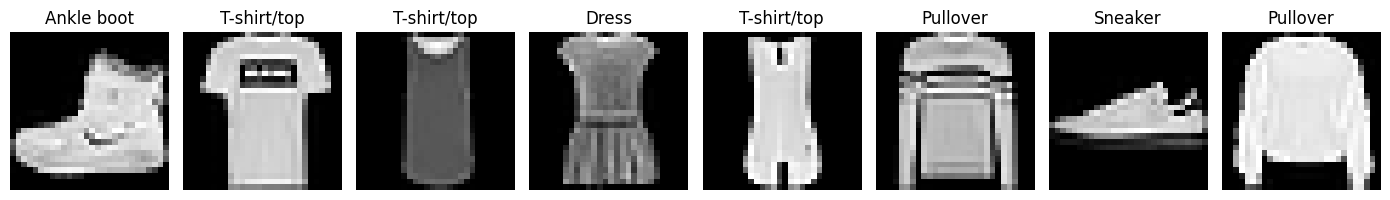

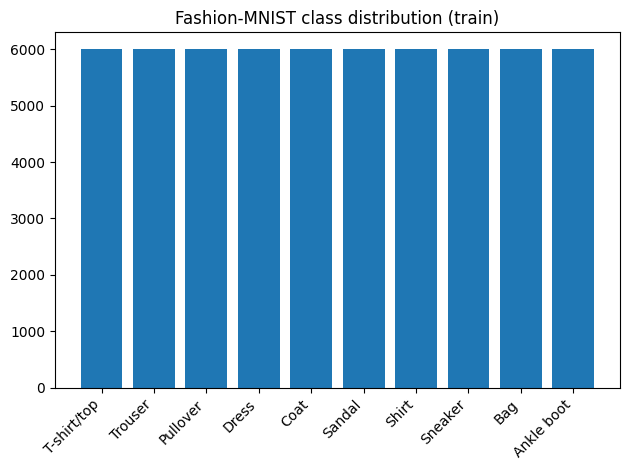

In [35]:
from torchvision import datasets, transforms

RAW_DIR = DATA_DIR / "fashionmnist_raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

explore_tf = transforms.Compose([transforms.ToTensor()])

train_ds_raw = datasets.FashionMNIST(root=str(RAW_DIR), train=True, download=True, transform=explore_tf)
test_ds_raw  = datasets.FashionMNIST(root=str(RAW_DIR), train=False, download=True, transform=explore_tf)

class_names = train_ds_raw.classes
print("Classes:", class_names)
print("Train size:", len(train_ds_raw), "Test size:", len(test_ds_raw))

imgs, labels = [], []
for i in range(8):
    x, y = train_ds_raw[i]
    imgs.append(x.squeeze().numpy())
    labels.append(class_names[y])
show_image_grid(imgs, labels, n=8, figsize=(14,3))

y_train = np.array([train_ds_raw[i][1] for i in range(len(train_ds_raw))], dtype=int)
counts = np.bincount(y_train, minlength=len(class_names))
plt.figure()
plt.bar(range(len(class_names)), counts)
plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
plt.title("Fashion-MNIST class distribution (train)")
plt.tight_layout()
plt.show()


In [36]:
from torchvision import transforms, datasets

IMG_SIZE = 224

train_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

test_tf = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_ds = datasets.FashionMNIST(root=str(RAW_DIR), train=True, download=True, transform=train_tf)
test_ds  = datasets.FashionMNIST(root=str(RAW_DIR), train=False, download=True, transform=test_tf)

TRAIN_N = 15000
TEST_N  = 5000
train_idx = np.random.RandomState(SEED).choice(len(train_ds), size=TRAIN_N, replace=False)
test_idx  = np.random.RandomState(SEED+1).choice(len(test_ds), size=TEST_N, replace=False)

train_sub = Subset(train_ds, train_idx)
test_sub  = Subset(test_ds, test_idx)

BATCH = 64
train_loader = DataLoader(train_sub, batch_size=BATCH, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_sub, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))


Train batches: 235 Test batches: 79


In [37]:
from torchvision import models

num_classes = len(class_names)

vision_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
vision_model.fc = nn.Linear(vision_model.fc.in_features, num_classes)
vision_model = vision_model.to(DEVICE)

def set_backbone_trainable(model, trainable: bool):
    for name, p in model.named_parameters():
        if not name.startswith("fc."):
            p.requires_grad = trainable

set_backbone_trainable(vision_model, trainable=False)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, vision_model.parameters()),
                              lr=3e-4, weight_decay=1e-4)

print("Trainable params:", sum(p.numel() for p in vision_model.parameters() if p.requires_grad))


Trainable params: 5130


Epoch 1/2 | train loss 1.4684 acc 0.5735 | val loss 1.1146 acc 0.7062
Epoch 2/2 | train loss 0.3748 acc 0.8675 | val loss 0.2811 acc 0.9024


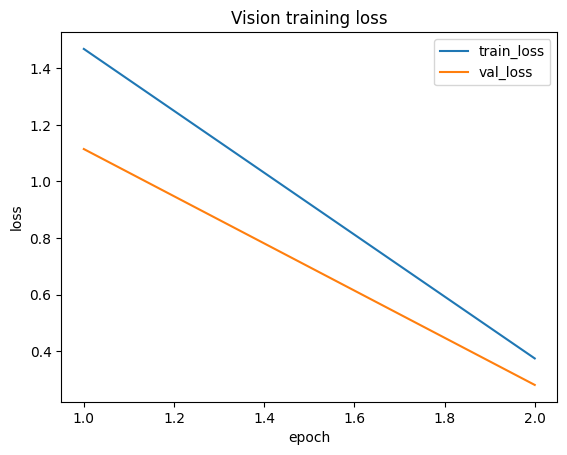

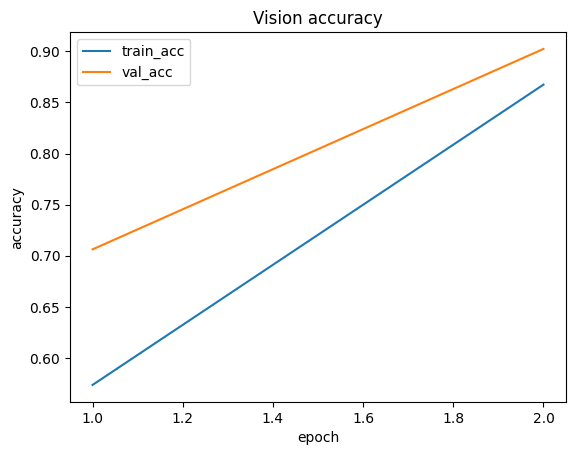

Saved: /content/mm_retail_bot/artifacts/vision_resnet18_fashionmnist.pt


In [38]:
from sklearn.metrics import accuracy_score

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    losses, y_true, y_pred = [], [], []
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
    return float(np.mean(losses)), accuracy_score(y_true, y_pred)

@torch.no_grad()
def eval_model(model, loader, criterion):
    model.eval()
    losses, y_true, y_pred = [], [], []
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        losses.append(loss.item())
        y_true.extend(y.detach().cpu().numpy().tolist())
        y_pred.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
    return float(np.mean(losses)), accuracy_score(y_true, y_pred), np.array(y_true), np.array(y_pred)

history = {"epoch": [], "train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

EPOCHS = 2
for epoch in range(1, EPOCHS+1):
    if epoch == 2:
        set_backbone_trainable(vision_model, trainable=True)
        optimizer = torch.optim.AdamW(vision_model.parameters(), lr=1e-4, weight_decay=1e-4)

    tr_loss, tr_acc = train_one_epoch(vision_model, train_loader, optimizer, criterion)
    va_loss, va_acc, _, _ = eval_model(vision_model, test_loader, criterion)

    history["epoch"].append(epoch)
    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"Epoch {epoch}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

df_hist = pd.DataFrame(history)

plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_loss"], label="train_loss")
plt.plot(df_hist["epoch"], df_hist["val_loss"], label="val_loss")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("Vision training loss")
plt.show()

plt.figure()
plt.plot(df_hist["epoch"], df_hist["train_acc"], label="train_acc")
plt.plot(df_hist["epoch"], df_hist["val_acc"], label="val_acc")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.title("Vision accuracy")
plt.show()

VISION_CKPT = ART_DIR / "vision_resnet18_fashionmnist.pt"
torch.save({"state_dict": vision_model.state_dict(), "class_names": class_names, "img_size": IMG_SIZE}, VISION_CKPT)
print("Saved:", VISION_CKPT)


Final vision val acc: 0.9024
              precision    recall  f1-score   support

 T-shirt/top     0.9298    0.8485    0.8873       515
     Trouser     0.9922    0.9770    0.9846       522
    Pullover     0.7893    0.9237    0.8512       511
       Dress     0.8702    0.9145    0.8918       491
        Coat     0.8992    0.6933    0.7829       489
      Sandal     0.9920    0.9688    0.9803       513
       Shirt     0.6853    0.7731    0.7266       476
     Sneaker     0.9440    0.9760    0.9598       501
         Bag     0.9896    0.9735    0.9815       490
  Ankle boot     0.9733    0.9634    0.9683       492

    accuracy                         0.9024      5000
   macro avg     0.9065    0.9012    0.9014      5000
weighted avg     0.9078    0.9024    0.9027      5000



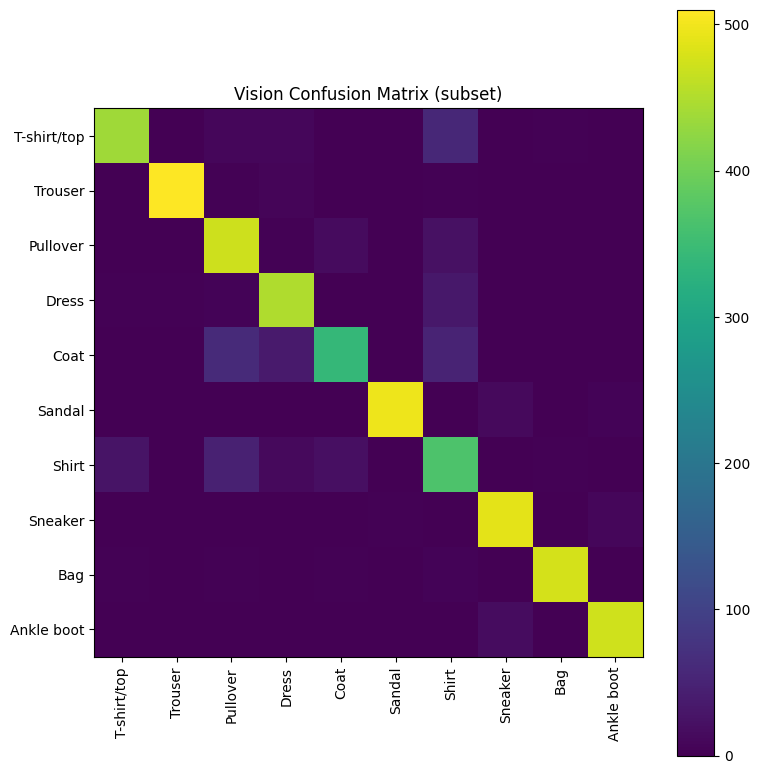

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

val_loss, val_acc, y_true, y_pred = eval_model(vision_model, test_loader, criterion)
print("Final vision val acc:", val_acc)

print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
plt.figure(figsize=(8,8))
plt.imshow(cm, interpolation="nearest")
plt.title("Vision Confusion Matrix (subset)")
plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)
plt.colorbar()
plt.tight_layout()
plt.show()


In [40]:
from pathlib import Path
from torchvision.datasets import FashionMNIST
import torchvision.transforms as T

PROJECT_DIR = Path("/content/mm_retail_bot")
DATA_DIR = PROJECT_DIR / "data"
THUMB_DIR = DATA_DIR / "faiss_thumbs"
THUMB_DIR.mkdir(parents=True, exist_ok=True)

for p in THUMB_DIR.glob("*.png"):
    p.unlink()

ds = FashionMNIST(root=str(DATA_DIR / "fashion_mnist"), train=True, download=True)

N = 3000
classes = ds.classes
print("Classes:", classes)
print("Exporting", N, "images to", THUMB_DIR)

for i in range(N):
    img, label = ds[i]
    img = img.convert("RGB")
    safe = classes[label].replace(" ", "_").replace("/", "_")
    out = THUMB_DIR / f"{i:05d}_c{label}_{safe}.png"
    img.save(out)

print("Done. Example files:", list(THUMB_DIR.glob("*.png"))[:3])

Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Exporting 3000 images to /content/mm_retail_bot/data/faiss_thumbs
✅ Done. Example files: [PosixPath('/content/mm_retail_bot/data/faiss_thumbs/01983_c3_Dress.png'), PosixPath('/content/mm_retail_bot/data/faiss_thumbs/01327_c0_T-shirt_top.png'), PosixPath('/content/mm_retail_bot/data/faiss_thumbs/02232_c7_Sneaker.png')]


In [41]:
%%bash
ls -lah /content/mm_retail_bot/data/faiss_thumbs | head -n 10
python - << 'PY'
from pathlib import Path
p = Path("/content/mm_retail_bot/data/faiss_thumbs")
print("thumbs exist:", p.exists())
print("thumb count:", len(list(p.glob("*.png"))))
PY

total 12M
drwxr-xr-x 2 root root 120K Feb  5 19:28 .
drwxr-xr-x 5 root root 4.0K Feb  5 18:21 ..
-rw-r--r-- 1 root root 1.3K Feb  5 19:28 00000_c9_Ankle_boot.png
-rw-r--r-- 1 root root 1.2K Feb  5 19:28 00001_c0_T-shirt_top.png
-rw-r--r-- 1 root root  704 Feb  5 19:28 00002_c0_T-shirt_top.png
-rw-r--r-- 1 root root 1.1K Feb  5 19:28 00003_c3_Dress.png
-rw-r--r-- 1 root root  816 Feb  5 19:28 00004_c0_T-shirt_top.png
-rw-r--r-- 1 root root 1.3K Feb  5 19:28 00005_c2_Pullover.png
-rw-r--r-- 1 root root  766 Feb  5 19:28 00006_c7_Sneaker.png
thumbs exist: True
thumb count: 3000


In [42]:
import os, json
from pathlib import Path
import numpy as np
from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

PROJECT_DIR = Path("/content/mm_retail_bot")
DATA_DIR = PROJECT_DIR / "data"
ART_DIR = PROJECT_DIR / "artifacts"
ART_DIR.mkdir(parents=True, exist_ok=True)

THUMB_DIR = DATA_DIR / "faiss_thumbs"
INDEX_PATH = ART_DIR / "clip_faiss.index"
META_PATH  = ART_DIR / "clip_faiss_meta.json"

img_paths = sorted(THUMB_DIR.glob("*.png"))
if len(img_paths) == 0:
    raise FileNotFoundError(
        f"No thumbnails found in {THUMB_DIR}\n"
        "Run the thumbnail export cell first."
    )

print("Found thumbnails:", len(img_paths))

try:
    import faiss
except Exception:
    !pip -q install faiss-cpu
    import faiss

import torch
from transformers import CLIPModel, CLIPProcessor

DEVICE = "cpu"
clip_name = "openai/clip-vit-base-patch32"
clip_proc = CLIPProcessor.from_pretrained(clip_name)
clip_model = CLIPModel.from_pretrained(clip_name).to(DEVICE).eval()

@torch.no_grad()
def embed_batch(pil_imgs):
    inputs = clip_proc(images=pil_imgs, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    emb_candidate = None
    if hasattr(clip_model, "get_image_features"):
        emb_candidate = clip_model.get_image_features(**inputs)
    else:
        out = clip_model.vision_model(pixel_values=inputs["pixel_values"])
        emb_candidate = getattr(out, "pooler_output", out[0][:, 0, :])

    if not isinstance(emb_candidate, torch.Tensor):
        extracted_tensor = None
        if hasattr(emb_candidate, "image_embeds") and emb_candidate.image_embeds is not None:
            extracted_tensor = emb_candidate.image_embeds
        elif hasattr(emb_candidate, "pooler_output") and emb_candidate.pooler_output is not None:
            extracted_tensor = emb_candidate.pooler_output
        elif isinstance(emb_candidate, (tuple, list)) and len(emb_candidate) > 0 and isinstance(emb_candidate[0], torch.Tensor):
            extracted_tensor = emb_candidate[0]

        if extracted_tensor is not None:
            emb = extracted_tensor
        else:
            raise TypeError(f"Could not extract valid tensor from model output: {type(emb_candidate)}")
    else:
        emb = emb_candidate

    emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
    return emb.detach().cpu().numpy().astype("float32")

MAX_N = 3000
img_paths = img_paths[:MAX_N]

with Image.open(img_paths[0]) as im:
    v0 = embed_batch([im.convert("RGB")])
d = v0.shape[1]

index = faiss.IndexFlatIP(d)
meta = []

BATCH = 32
added = 0
skipped = 0

for i in range(0, len(img_paths), BATCH):
    batch_paths = img_paths[i:i+BATCH]
    batch_imgs = []
    keep_paths = []

    for p in batch_paths:
        try:
            with Image.open(p) as im:
                batch_imgs.append(im.convert("RGB"))
            keep_paths.append(p)
        except Exception:
            skipped += 1

    if not batch_imgs:
        continue

    vecs = embed_batch(batch_imgs)
    if not np.isfinite(vecs).all():
        vecs = np.nan_to_num(vecs, nan=0.0, posinf=0.0, neginf=0.0).astype("float32")

    index.add(vecs)
    added += vecs.shape[0]

    for p in keep_paths:
        meta.append({"path": str(p), "label": p.stem})

    if (i // BATCH) % 10 == 0:
        print(f"Embedded+Indexed {min(i+BATCH, len(img_paths))}/{len(img_paths)} | added={added} | skipped={skipped}")

faiss.write_index(index, str(INDEX_PATH))
META_PATH.write_text(json.dumps(meta, indent=2))

print("FAISS index saved:", INDEX_PATH)
print("Meta saved:", META_PATH)
print("Total indexed:", index.ntotal, "| meta:", len(meta), "| skipped:", skipped)

D, I = index.search(v0.astype("float32"), 5)
print("Top-5 distances:", D[0])
print("Top-5 items:", [meta[int(j)]["path"] for j in I[0]])

✅ Found thumbnails: 3000


Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Embedded+Indexed 32/3000 | added=32 | skipped=0
Embedded+Indexed 352/3000 | added=352 | skipped=0
Embedded+Indexed 672/3000 | added=672 | skipped=0
Embedded+Indexed 992/3000 | added=992 | skipped=0
Embedded+Indexed 1312/3000 | added=1312 | skipped=0
Embedded+Indexed 1632/3000 | added=1632 | skipped=0
Embedded+Indexed 1952/3000 | added=1952 | skipped=0
Embedded+Indexed 2272/3000 | added=2272 | skipped=0
Embedded+Indexed 2592/3000 | added=2592 | skipped=0
Embedded+Indexed 2912/3000 | added=2912 | skipped=0
✅ FAISS index saved: /content/mm_retail_bot/artifacts/clip_faiss.index
✅ Meta saved: /content/mm_retail_bot/artifacts/clip_faiss_meta.json
Total indexed: 3000 | meta: 3000 | skipped: 0
Top-5 distances: [0.9999999  0.9706466  0.9679296  0.96779895 0.9660004 ]
Top-5 items: ['/content/mm_retail_bot/data/faiss_thumbs/00000_c9_Ankle_boot.png', '/content/mm_retail_bot/data/faiss_thumbs/02869_c7_Sneaker.png', '/content/mm_retail_bot/data/faiss_thumbs/00299_c9_Ankle_boot.png', '/content/mm_ret

In [43]:
import whisper
from jiwer import wer

whisper_model_size = "tiny"
stt_model = whisper.load_model(whisper_model_size, device=DEVICE)

audio_path = str(SAMPLE_AUDIO_PATH)
print("Transcribing:", audio_path)

result = stt_model.transcribe(audio_path, fp16=(DEVICE=="cuda"))
transcript = result.get("text","").strip()
print("Transcript:", transcript)

GROUND_TRUTH = ""
if GROUND_TRUTH.strip():
    print("WER:", wer(GROUND_TRUTH.lower(), transcript.lower()))
else:
    print("WER skipped (no ground truth provided).")


Transcribing: /content/mm_retail_bot/data/sample_query.mp3


/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:130: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")


Transcript: Show me similar shoes but cheaper.
WER skipped (no ground truth provided).


In [44]:
import re

INTENTS = ["find_similar","filter_color","filter_price","ask_size","ask_material","greeting","goodbye"]

TEMPLATES = {
    "find_similar": ["show me similar items","find something like this","recommend alternatives","similar products please","more like this"],
    "filter_color": ["in black","in white","in red","in blue","in green","show me {color} ones","i want it in {color}"],
    "filter_price": ["cheaper options","something cheaper","under 20 euros","premium version","budget friendly","less expensive"],
    "ask_size": ["do you have size m","size chart","what sizes are available","i need a large","is there a small size"],
    "ask_material": ["what material is it","is it cotton","is it leather","tell me the fabric","is it waterproof"],
    "greeting": ["hi","hello","hey","good morning","good evening"],
    "goodbye": ["bye","thanks bye","see you","goodbye","that is all"],
}

COLORS = ["black","white","red","blue","green","beige","brown"]

def normalize_text(t: str) -> str:
    t = t.lower().strip()
    t = re.sub(r"[^a-z0-9\s€$]", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def build_intent_dataset(n_per_intent=120, seed=SEED):
    rng = random.Random(seed)
    texts, labels = [], []
    for intent in INTENTS:
        base = TEMPLATES[intent]
        for _ in range(n_per_intent):
            t = rng.choice(base)
            if "{color}" in t:
                t = t.format(color=rng.choice(COLORS))
            texts.append(normalize_text(t))
            labels.append(intent)
    df = pd.DataFrame({"text": texts, "intent": labels})
    df = df.sample(frac=1.0, random_state=seed).reset_index(drop=True)
    return df

df_intent = build_intent_dataset(n_per_intent=120)
print(df_intent.head())
print("Dataset size:", len(df_intent))
print(df_intent["intent"].value_counts())

                      text        intent
0                       hi      greeting
1              that is all       goodbye
2   recommend alternatives  find_similar
3       tell me the fabric  ask_material
4  similar products please  find_similar
Dataset size: 840
intent
greeting        120
goodbye         120
find_similar    120
ask_material    120
filter_price    120
ask_size        120
filter_color    120
Name: count, dtype: int64


In [45]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import evaluate as hf_evaluate

label2id = {lab:i for i,lab in enumerate(INTENTS)}
id2label = {i:lab for lab,i in label2id.items()}

df_intent["label"] = df_intent["intent"].map(label2id)
ds = Dataset.from_pandas(df_intent[["text","label"]])
ds = ds.train_test_split(test_size=0.2, seed=SEED)

tok = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tok_fn(batch):
    return tok(batch["text"], truncation=True, padding="max_length", max_length=32)

train_tok = ds["train"].map(tok_fn, batched=True)
val_tok   = ds["test"].map(tok_fn, batched=True)

model_intent = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(INTENTS),
    id2label=id2label,
    label2id=label2id
).to(DEVICE)

metric_acc = hf_evaluate.load("accuracy")
metric_f1  = hf_evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": metric_acc.compute(predictions=preds, references=labels)["accuracy"],
        "f1_macro": metric_f1.compute(predictions=preds, references=labels, average="macro")["f1"],
    }


import transformers
print('Transformers version:', transformers.__version__)
args = TrainingArguments(
    output_dir=str(ART_DIR / "intent_model"),
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    report_to=[],
    fp16=(DEVICE=="cuda")
)

trainer = Trainer(
    model=model_intent,
    args=args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    compute_metrics=compute_metrics
)

trainer.train()
print(trainer.evaluate())

trainer.save_model(str(ART_DIR / "intent_distilbert"))
tok.save_pretrained(str(ART_DIR / "intent_distilbert"))print("Saved intent model to:", ART_DIR / "intent_distilbert")

Map:   0%|          | 0/672 [00:00<?, ? examples/s]

Map:   0%|          | 0/168 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Transformers version: 5.0.0


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,1.469048,0.779762,0.754978
2,No log,1.216968,0.928571,0.931534


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': 1.2169684171676636, 'eval_accuracy': 0.9285714285714286, 'eval_f1_macro': 0.9315339038841344, 'eval_runtime': 0.227, 'eval_samples_per_second': 740.195, 'eval_steps_per_second': 13.218, 'epoch': 2.0}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved intent model to: /content/mm_retail_bot/artifacts/intent_distilbert


In [46]:
from transformers import AutoModel

vision_backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
vision_backbone.fc = nn.Identity()
vision_backbone = vision_backbone.to(DEVICE).eval()

text_backbone = AutoModel.from_pretrained(str(ART_DIR / "intent_distilbert")).to(DEVICE).eval()

@torch.no_grad()
def vision_embed(batch_imgs):
    feats = vision_backbone(batch_imgs.to(DEVICE))
    feats = feats / feats.norm(dim=-1, keepdim=True)
    return feats

@torch.no_grad()
def text_embed(texts):
    inputs = tok(texts, return_tensors="pt", truncation=True, padding=True, max_length=32).to(DEVICE)
    out = text_backbone(**inputs)
    cls = out.last_hidden_state[:, 0, :]
    cls = cls / cls.norm(dim=-1, keepdim=True)
    return cls

PAIR_N = 5000
pair_idx = np.random.RandomState(SEED+3).choice(len(train_ds), size=PAIR_N, replace=False)

rng = random.Random(SEED+4)
pair_texts, pair_labels = [], []
for i in pair_idx:
    intent = rng.choice(INTENTS)
    t = rng.choice(TEMPLATES[intent])
    if "{color}" in t:
        t = t.format(color=rng.choice(COLORS))
    pair_texts.append(normalize_text(t))
    _, y = train_ds_raw[int(i)]
    pair_labels.append(int(y))

tmp_imgs = torch.stack([train_ds[int(i)][0] for i in pair_idx[:128]])
v_dim = vision_embed(tmp_imgs).shape[1]
t_dim = text_embed(pair_texts[:16]).shape[1]
print("Vision emb dim:", v_dim, "| Text emb dim:", t_dim)

class FusionMLP(nn.Module):
    def __init__(self, v_dim, t_dim, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(v_dim + t_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )
    def forward(self, v, t):
        return self.net(torch.cat([v, t], dim=1))

fusion_model = FusionMLP(v_dim, t_dim, len(class_names)).to(DEVICE)
opt = torch.optim.AdamW(fusion_model.parameters(), lr=2e-4, weight_decay=1e-4)
loss_fn = nn.CrossEntropyLoss()

perm = np.random.RandomState(SEED+5).permutation(PAIR_N)
split = int(PAIR_N * 0.8)
tr_ids = perm[:split]
va_ids = perm[split:]

def fusion_epoch(idxs, train=True, batch=64):
    fusion_model.train(train)
    losses, yt, yp = [], [], []
    for start in range(0, len(idxs), batch):
        b_ids = idxs[start:start+batch]
        x_batch = torch.stack([train_ds[int(pair_idx[i])][0] for i in b_ids])
        y_batch = torch.tensor([pair_labels[i] for i in b_ids], dtype=torch.long)
        txt_batch = [pair_texts[i] for i in b_ids]

        with torch.no_grad():
            v = vision_embed(x_batch)
            t = text_embed(txt_batch)

        logits = fusion_model(v, t)
        loss = loss_fn(logits, y_batch.to(DEVICE))

        if train:
            opt.zero_grad(set_to_none=True)
            loss.backward()
            opt.step()

        losses.append(loss.item())
        yt.extend(y_batch.numpy().tolist())
        yp.extend(logits.argmax(dim=1).detach().cpu().numpy().tolist())
    return float(np.mean(losses)), accuracy_score(yt, yp)

for ep in range(1, 3):
    tr_loss, tr_acc = fusion_epoch(tr_ids, train=True, batch=64)
    va_loss, va_acc = fusion_epoch(va_ids, train=False, batch=64)
    print(f"Fusion epoch {ep}/2 | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")

FUSION_CKPT = ART_DIR / "fusion_mlp.pt"
torch.save({"state_dict": fusion_model.state_dict(), "v_dim": v_dim, "t_dim": t_dim, "class_names": class_names}, FUSION_CKPT)
print("Saved fusion model:", FUSION_CKPT)

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: /content/mm_retail_bot/artifacts/intent_distilbert
Key                   | Status     |  | 
----------------------+------------+--+-
classifier.weight     | UNEXPECTED |  | 
classifier.bias       | UNEXPECTED |  | 
pre_classifier.weight | UNEXPECTED |  | 
pre_classifier.bias   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Vision emb dim: 512 | Text emb dim: 768
Fusion epoch 1/2 | train loss 2.2646 acc 0.2870 | val loss 2.1658 acc 0.3960
Fusion epoch 2/2 | train loss 1.8580 acc 0.4605 | val loss 1.4937 acc 0.5730
Saved fusion model: /content/mm_retail_bot/artifacts/fusion_mlp.pt


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/398 [00:00<?, ?it/s]

CLIPModel LOAD REPORT from: openai/clip-vit-base-patch32
Key                                  | Status     |  | 
-------------------------------------+------------+--+-
vision_model.embeddings.position_ids | UNEXPECTED |  | 
text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
/usr/local/lib/python3.12/dist-packages/whisper/transcribe.py:130: UserWarning: Performing inference on CPU when CUDA is available
  warnings.warn("Performing inference on CPU when CUDA is available")


User text: Show me similar shoes but cheaper.
Predicted intent: filter_price (conf=0.190)
Predicted category: Bag (conf=0.623)


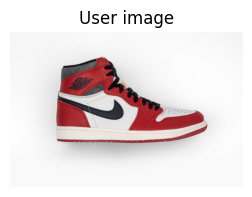

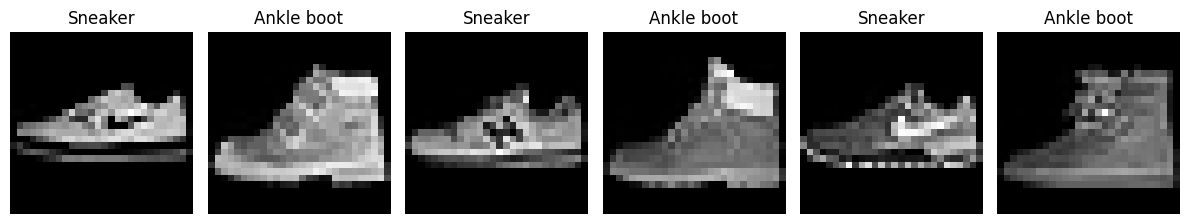

In [47]:
from PIL import Image
from torchvision import transforms
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, CLIPModel, CLIPProcessor
import whisper
import faiss
import json
import matplotlib.pyplot as plt

DEVICE = "cpu"

VISION_CKPT = ART_DIR / "vision_resnet18_fashionmnist.pt"
ckpt = torch.load(VISION_CKPT, map_location="cpu")
vision_infer = models.resnet18(weights=None)
vision_infer.fc = nn.Linear(vision_infer.fc.in_features, len(ckpt["class_names"]))
vision_infer.load_state_dict(ckpt["state_dict"])
vision_infer = vision_infer.to(DEVICE).eval()
infer_classes = ckpt["class_names"]
img_size = ckpt["img_size"]

infer_tf = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

@torch.no_grad()
def predict_category(image_path: str):
    pil = Image.open(image_path).convert("RGB")
    x = infer_tf(pil).unsqueeze(0).to(DEVICE)
    logits = vision_infer(x)
    prob = torch.softmax(logits, dim=1).squeeze(0).detach().cpu().numpy()
    top = int(prob.argmax())
    return infer_classes[top], float(prob[top])

whisper_model_size = "tiny"
stt_model = whisper.load_model(whisper_model_size, device=DEVICE)

def transcribe_audio_if_present(audio_path: str):
    if audio_path and os.path.exists(audio_path):
        res = stt_model.transcribe(audio_path, fp16=False)
        return res.get("text","").strip()
    return ""

intent_model_dir = ART_DIR / "intent_distilbert"
tok = AutoTokenizer.from_pretrained(str(intent_model_dir))
model_intent = AutoModelForSequenceClassification.from_pretrained(
    str(intent_model_dir)
).to(DEVICE).eval()
id2label = model_intent.config.id2label

@torch.no_grad()
def predict_intent(text: str):
    if not text.strip():
        return ("", 0.0)
    inputs = tok(text, return_tensors="pt", truncation=True, padding=True, max_length=32).to(DEVICE)
    out = model_intent(**inputs).logits
    probs = torch.softmax(out, dim=1).squeeze(0).detach().cpu().numpy()
    idx = int(probs.argmax())
    return id2label[idx], float(probs[idx])

clip_name = "openai/clip-vit-base-patch32"
clip_proc = CLIPProcessor.from_pretrained(clip_name)
clip_model = CLIPModel.from_pretrained(clip_name).to(DEVICE).eval()

INDEX_PATH = ART_DIR / "clip_faiss.index"
META_PATH  = ART_DIR / "clip_faiss_meta.json"
faiss_index = faiss.read_index(str(INDEX_PATH))
faiss_meta = json.loads(META_PATH.read_text())

@torch.no_grad()
def clip_image_embed_for_recommendation(pil_imgs):
    inputs = clip_proc(images=pil_imgs, return_tensors="pt")
    inputs = {k: v.to(DEVICE) for k, v in inputs.items()}

    emb_candidate = None
    if hasattr(clip_model, "get_image_features"):
        emb_candidate = clip_model.get_image_features(**inputs)
    else:
        out = clip_model.vision_model(pixel_values=inputs["pixel_values"])
        emb_candidate = getattr(out, "pooler_output", out[0][:, 0, :])

    if not isinstance(emb_candidate, torch.Tensor):
        extracted_tensor = None
        if hasattr(emb_candidate, "image_embeds") and emb_candidate.image_embeds is not None:
            extracted_tensor = emb_candidate.image_embeds
        elif hasattr(emb_candidate, "pooler_output") and emb_candidate.pooler_output is not None:
            extracted_tensor = emb_candidate.pooler_output
        elif isinstance(emb_candidate, (tuple, list)) and len(emb_candidate) > 0 and isinstance(emb_candidate[0], torch.Tensor):
            extracted_tensor = emb_candidate[0]

        if extracted_tensor is not None:
            emb = extracted_tensor
        else:
            raise TypeError(f"Could not extract valid tensor from model output: {type(emb_candidate)}")
    else:
        emb = emb_candidate

    emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
    return emb.detach().cpu().numpy().astype("float32")

def recommend_similar(image_path: str, k=6):
    pil = Image.open(image_path).convert("RGB")
    q = clip_image_embed_for_recommendation([pil])
    D, I = faiss_index.search(q, k=k)

    recs = []
    rec_labels = []
    for j in I[0]:
        meta_item = faiss_meta[int(j)]
        thumb_path = meta_item["path"]
        if len(label_parts) > 2:
            class_label_str = ' '.join(label_parts[2:])
            class_label_str = class_label_str.replace('_', '/')
        else:
            class_label_str = meta_item['label']

        recs.append(Image.open(thumb_path).convert("RGB"))
        rec_labels.append(class_label_str)

    return recs, rec_labels, D[0].tolist()

img_path = str(SAMPLE_IMAGE_PATH)
audio_path = str(SAMPLE_AUDIO_PATH)

spoken = transcribe_audio_if_present(audio_path)
user_text = spoken if spoken else "show me similar items in black"

intent, intent_conf = predict_intent(normalize_text(user_text))
cat, cat_conf = predict_category(img_path)
recs, rec_labels, sim_scores = recommend_similar(img_path, k=6)

print("User text:", user_text)
print("Predicted intent:", intent, f"(conf={intent_conf:.3f})")
print("Predicted category:", cat, f"(conf={cat_conf:.3f})")

plt.figure(figsize=(3,3))
plt.imshow(Image.open(img_path).convert("RGB"))
plt.axis("off")
plt.title("User image")
plt.show()

show_image_grid([np.array(r.convert("L")) for r in recs], rec_labels, n=6, figsize=(12,3))

In [48]:
app_py = UI_DIR / "app.py"
requirements_txt = UI_DIR / "requirements.txt"
dockerfile = UI_DIR / "Dockerfile"
compose = UI_DIR / "docker-compose.yml"

app_code = '''
import os, json, gc
from pathlib import Path

import numpy as np
import streamlit as st
from PIL import Image

import torch
from torch import nn
from torchvision import models, transforms

import faiss
from transformers import CLIPModel, CLIPProcessor, AutoTokenizer, AutoModelForSequenceClassification
import whisper

st.set_page_config(page_title="Multimodal Retail Bot", layout="wide")

PROJECT_DIR = Path("/content/mm_retail_bot")
DATA_DIR = PROJECT_DIR / "data"
ART_DIR  = PROJECT_DIR / "artifacts"

# Prefer CPU for Streamlit stability in Colab (avoids GPU OOM when notebook also holds models).
# If you want GPU, set USE_GPU=1 in env and restart Streamlit.
USE_GPU = os.environ.get("USE_GPU", "0").strip() == "1" and torch.cuda.is_available()
DEVICE = "cuda" if USE_GPU else "cpu"

# --------- Helpers ---------
def pil_to_tensor(img: Image.Image, img_size: int):
    tfm = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    return tfm(img.convert("RGB")).unsqueeze(0)

# --------- Cached loaders ---------
@st.cache_resource(show_spinner=False)
def load_vision():
    ckpt_path = ART_DIR / "vision_resnet18_fashionmnist.pt"
    ckpt = torch.load(ckpt_path, map_location="cpu")
    class_names = ckpt["class_names"]
    img_size = int(ckpt.get("img_size", 224))

    m = models.resnet18(weights=None)
    m.fc = nn.Linear(m.fc.in_features, len(class_names))
    m.load_state_dict(ckpt["state_dict"])
    m.eval()
    m.to(DEVICE)
    return m, class_names, img_size

@st.cache_resource(show_spinner=False)
def load_intent():
    model_dir = ART_DIR / "intent_distilbert"
    tok = AutoTokenizer.from_pretrained(str(model_dir))
    mdl = AutoModelForSequenceClassification.from_pretrained(str(model_dir)).to(DEVICE).eval()
    # label names stored in config if present; fallback to indices
    id2label = getattr(mdl.config, "id2label", None) or {i: f"intent_{i}" for i in range(mdl.config.num_labels)}
    return tok, mdl, id2label

@st.cache_resource(show_spinner=False)
def load_clip():
    # Use a small CLIP variant (same as used to build FAISS) — cached by HF.
    name = "openai/clip-vit-base-patch32"
    proc = CLIPProcessor.from_pretrained(name)
    mdl = CLIPModel.from_pretrained(name).to(DEVICE).eval()
    return proc, mdl

@st.cache_resource(show_spinner=False)
def load_faiss():
    idx_path = ART_DIR / "clip_faiss.index"
    meta_path = ART_DIR / "clip_faiss_meta.json"
    index = faiss.read_index(str(idx_path))
    meta = json.loads(meta_path.read_text())
    return index, meta

@st.cache_resource(show_spinner=False)
def load_whisper():
    # Tiny is fast and enough for demo
    mdl = whisper.load_model("tiny")
    return mdl

# --------- UI ---------
st.title("🛍️ Multimodal Retail Chatbot (Image + Speech + Text)")
st.caption(f"Device: {DEVICE}  |  Tip: set USE_GPU=1 to enable GPU in Streamlit.")

colA, colB = st.columns([1,1])

with colA:
    img_file = st.file_uploader("Upload a product image (PNG/JPG)", type=["png","jpg","jpeg"])
    if img_file:
        img = Image.open(img_file).convert("RGB")
        st.image(img, caption="Uploaded image", use_container_width=True)
    else:
        img = None

with colB:
    audio_file = st.file_uploader("Upload a query audio (WAV/MP3)", type=["wav","mp3","m4a"])
    text_query = st.text_input("Or type your query (optional)", value="")
    run_btn = st.button("Run analysis")

# --------- Run pipeline on demand (prevents blank pages while models download/load) ---------
if run_btn:
    with st.spinner("Loading models and artifacts (first run may take ~1-2 minutes)..."):
        vision_model, class_names, img_size = load_vision()
        tok, intent_model, id2label = load_intent()
        clip_proc, clip_model = load_clip()
        faiss_index, faiss_meta = load_faiss()
        whisper_model = load_whisper()

    # ---- Image classification ----
    if img is not None:
        with st.spinner("Classifying image..."):
            x = pil_to_tensor(img, img_size).to(DEVICE)
            with torch.no_grad():
                logits = vision_model(x)
                probs = torch.softmax(logits, dim=-1)[0].detach().cpu().numpy()
            pred = int(np.argmax(probs))
            st.subheader("Image category prediction")
            st.write(f"**Predicted class:** {class_names[pred]}")
            st.write(f"**Confidence:** {float(probs[pred]):.3f}")

        # ---- Similar items (CLIP + FAISS) ----
        with st.spinner("Retrieving similar items (CLIP + FAISS)..."):
            inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)
            with torch.no_grad():
                emb = clip_model.get_image_features(**inputs)
                # If emb is a ModelOutput (e.g., BaseModelOutputWithPooling), take pooler_output
                if not isinstance(emb, torch.Tensor):
                    emb = getattr(emb, 'image_embeds', None) or getattr(emb, 'pooler_output', None) or emb[0]
                emb = emb / emb.norm(p=2, dim=-1, keepdim=True)
            q = emb.detach().cpu().numpy().astype("float32")
            D, I = faiss_index.search(q, 6)

        st.subheader("Similar items")
        cols = st.columns(6)
        for j, idx in enumerate(I[0]):
            meta = faiss_meta[int(idx)]
            # meta may store path strings
            p = meta.get("path") or meta.get("img_path") or meta.get("image_path")
            caption = meta.get("label") or meta.get("class") or ""
            if p and Path(p).exists():
                try:
                    cols[j].image(Image.open(p).convert("RGB"), caption=caption, use_container_width=True)
                except Exception:
                    cols[j].write(f"#{j+1}: {caption}")
            else:
                cols[j].write(f"#{j+1}: {caption}")

    # ---- Speech to text ----
    transcript = ""
    if audio_file is not None:
        with st.spinner("Transcribing audio (Whisper)..."):
            # Streamlit upload -> bytes -> temp file
            import tempfile
            with tempfile.NamedTemporaryFile(delete=False, suffix=".wav") as tmp:
                tmp.write(audio_file.read())
                tmp_path = tmp.name
            result = whisper_model.transcribe(tmp_path)
            transcript = (result.get("text") or "").strip()
        st.subheader("Speech transcript")
        st.write(transcript if transcript else "_(empty transcript)_")

    # ---- Intent classification (text query or transcript) ----
    query_text = (text_query or "").strip() or transcript
    if query_text:
        with st.spinner("Predicting intent (DistilBERT)..."):
            enc = tok([query_text], return_tensors="pt", truncation=True, padding=True).to(DEVICE)
            with torch.no_grad():
                out = intent_model(**enc)
                probs = torch.softmax(out.logits, dim=-1)[0].detach().cpu().numpy()
            pred = int(np.argmax(probs))
            label = id2label.get(pred, str(pred))
        st.subheader("Intent prediction")
        st.write(f"**Intent:** {label}")
        st.write(f"**Confidence:** {float(probs[pred]):.3f}")
    else:
        st.info("Provide a text query or audio to predict intent.")

    # cleanup (helps Colab stability)
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
'''


app_py.write_text(app_code)

requirements_txt.write_text("""streamlit>=1.33.0
torch
torchvision
transformers>=4.41.0
faiss-cpu>=1.7.4
openai-whisper>=20231117
pillow
numpy
""")

dockerfile.write_text("""FROM python:3.10-slim
RUN apt-get update && apt-get install -y ffmpeg && rm -rf /var/lib/apt/lists/*
WORKDIR /app
COPY requirements.txt /app/requirements.txt
RUN pip install --no-cache-dir -r requirements.txt
COPY app.py /app/app.py
EXPOSE 8501
CMD [\"streamlit\", \"run\", \"app.py\", \"--server.port=8501\", \"--server.address=0.0.0.0\"]
""")

compose.write_text("""version: "3.8"
services:
  ui:
    build: .
    ports:
      - "8501:8501"
""")

print("Wrote Streamlit + Docker artifacts to:", UI_DIR)
print(" -", app_py)
print(" -", dockerfile)
print(" -", compose)


Wrote Streamlit + Docker artifacts to: /content/mm_retail_bot/ui
 - /content/mm_retail_bot/ui/app.py
 - /content/mm_retail_bot/ui/Dockerfile
 - /content/mm_retail_bot/ui/docker-compose.yml


In [49]:
from pathlib import Path
import re

APP = Path("/content/mm_retail_bot/ui/app.py")
txt = APP.read_text()

pat = re.compile(
    r"(?P<ind>[ \t]*)emb\s*=\s*getattr\(emb,\s*['\"]image_embeds['\"],\s*None\)\s*or\s*getattr\(emb,\s*['\"]pooler_output['\"],\s*None\)\s*or\s*emb\[0\]\s*"
)

def repl(m):
    ind = m.group("ind")
    return (
        f"{ind}tmp = getattr(emb, \"image_embeds\", None)\n"
        f"{ind}if isinstance(tmp, torch.Tensor):\n"
        f"{ind}    emb = tmp\n"
        f"{ind}else:\n"
        f"{ind}    tmp = getattr(emb, \"pooler_output\", None)\n"
        f"{ind}    if isinstance(tmp, torch.Tensor):\n"
        f"{ind}        emb = tmp\n"
        f"{ind}    else:\n"
        f"{ind}        emb = emb[0]\n"
    )

new_txt, n = pat.subn(repl, txt)
APP.write_text(new_txt)
print("patched:", n, "occurrence(s)")

✅ patched: 1 occurrence(s)


In [51]:
from pathlib import Path
import re

APP = Path("/content/mm_retail_bot/ui/app.py")
assert APP.exists(), f"Missing {APP}. Run the cell that creates the Streamlit app first."

text = APP.read_text()
text = text.replace("\t", "    ")
lines = text.splitlines()

start = None
end = None

for i, l in enumerate(lines):
    if "Similar items (CLIP + FAISS)" in l:
        start = i
        break

if start is None:
    raise RuntimeError("Couldn't find 'Similar items (CLIP + FAISS)' block in app.py")

for i in range(start + 1, len(lines)):
    if 'st.subheader("Similar items")' in lines[i]:
        end = i
        break

if end is None:
    raise RuntimeError('Could not find st.subheader("Similar items") after the CLIP+FAISS block')

base = re.match(r'^(\s*)', lines[start]).group(1)

new_block = [
f"{base}# ---- Similar items (CLIP + FAISS) ----",
f'{base}with st.spinner("Retrieving similar items (CLIP + FAISS)..."):',
f'{base}    inputs = clip_proc(images=img, return_tensors="pt").to(DEVICE)',
f"{base}    with torch.no_grad():",
f"{base}        emb = clip_model.get_image_features(**inputs)",
f"{base}        # Robust: if emb is a ModelOutput, extract a tensor safely",
f"{base}        if not isinstance(emb, torch.Tensor):",
f'{base}            tmp = getattr(emb, "image_embeds", None)',
f"{base}            if isinstance(tmp, torch.Tensor):",
f"{base}                emb = tmp",
f"{base}            else:",
f'{base}                tmp = getattr(emb, "pooler_output", None)',
f"{base}                if isinstance(tmp, torch.Tensor):",
f"{base}                    emb = tmp",
f"{base}                else:",
f"{base}                    emb = emb[0]",
f"{base}        emb = emb / emb.norm(p=2, dim=-1, keepdim=True)",
f'{base}    q = emb.detach().cpu().numpy().astype("float32")',
f"{base}    D, I = faiss_index.search(q, 6)",
]

lines = lines[:start] + new_block + lines[end:]
APP.write_text("\n".join(lines) + "\n")

print("app.py patched successfully:", APP)
print(f"Rewrote CLIP+FAISS block lines {start+1}..{end}")
print("Now restart Streamlit and rerun your Streamlit launch cell:")
print('  !pkill -f "streamlit run" || true')

✅ app.py patched successfully: /content/mm_retail_bot/ui/app.py
Rewrote CLIP+FAISS block lines 123..142
Now restart Streamlit and rerun your Streamlit launch cell:
  !pkill -f "streamlit run" || true


In [52]:
import os, time, socket, subprocess
from pathlib import Path
from google.colab import output

port = 8501
LOG = "/content/streamlit.log"

subprocess.run(["bash","-lc","pkill -f 'streamlit run' || true"], check=False)

app_path = UI_DIR / "app.py"
assert app_path.exists(), f"Missing Streamlit app: {app_path}"

cmd = f'''
cd "{UI_DIR}" && nohup bash -lc '
  export USE_GPU=1
  streamlit run "{app_path}"     --server.address 0.0.0.0     --server.port {port}     --server.headless true     --server.enableCORS false     --server.enableXsrfProtection false     --browser.gatherUsageStats false
' > "{LOG}" 2>&1 &
'''
subprocess.run(["bash","-lc", cmd], check=True)

def port_open(p):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.settimeout(0.5)
        return s.connect_ex(("127.0.0.1", p)) == 0

t0 = time.time()
while time.time() - t0 < 25:
    if port_open(port):
        break
    time.sleep(0.5)

if not port_open(port):
    print("Streamlit did not start. Logs:")
    print(Path(LOG).read_text()[-4000:])
    raise RuntimeError("Streamlit failed to start.")

proxy_url = output.eval_js(f"google.colab.kernel.proxyPort({port})")
print("Streamlit is running.")
print("Open this URL in a new tab if iframe is blank:\n", proxy_url)

output.serve_kernel_port_as_iframe(port, height=800)

print("\n--- Last 200 log lines ---")
log_text = Path(LOG).read_text(errors="ignore")
print("\n".join(log_text.splitlines()[-200:]))

✅ Streamlit is running.
✅ Open this URL in a new tab if iframe is blank:
 https://8501-gpu-t4-s-8zox7d375fmo-a.us-west4-2.prod.colab.dev


<IPython.core.display.Javascript object>


--- Last 200 log lines ---

